# AstraDB ColBERT or Pinecone/Weaviate Hybrid Search?
Author: Tiernan Lindauer, Datastax Inc.

## Step 1: Setup

Install the required packages (`requirements.txt`)

In [65]:
# Some minor setup for the notebook
import warnings
import nest_asyncio

# Ignore all warnings
warnings.filterwarnings("ignore")

# Allows for running async code in Jupyter notebooks
nest_asyncio.apply()

In [66]:
import os
import time
import openai
import weaviate
from dotenv import load_dotenv
from langchain_community.retrievers import (
    WeaviateHybridSearchRetriever,
)
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

Load the corpus.

In [25]:
corpus_path = "dataset/movie_scripts/test"

In [24]:
def load_and_split_text(folder_path):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    texts = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            text = file.read()
            texts.extend(text_splitter.split_text(text))
    return texts


corpus = load_and_split_text(corpus_path)

Alternatively, load a dataset from the Hugging Face Datasets library.

In [67]:
from datasets import load_dataset

datasets = {}
def configure_dataset(name: str, lang:str=None):
    if lang:
        datasets[name] = load_dataset(name, lang)
    else:
        datasets[name] = load_dataset(name)

In [68]:
configure_dataset("mteb/amazon_polarity")
configure_dataset("mteb/amazon_counterfactual", "en")
configure_dataset("mteb/quora-retrieval")
configure_dataset("mteb/askubuntudupquestions-reranking")
configure_dataset("mteb/stackexchange-clustering")
configure_dataset("mteb/reddit-clustering-p2p")
configure_dataset("mteb/emotion")
configure_dataset("mteb/arxiv-clustering-p2p")
configure_dataset("mteb/cqadupstack-english", "corpus")
print(list(datasets.keys()))

['mteb/amazon_polarity', 'mteb/amazon_counterfactual', 'mteb/quora-retrieval', 'mteb/askubuntudupquestions-reranking', 'mteb/stackexchange-clustering', 'mteb/reddit-clustering-p2p', 'mteb/emotion', 'mteb/arxiv-clustering-p2p', 'mteb/cqadupstack-english']


In [69]:
corpus = (
    datasets["mteb/amazon_polarity"]['train']['text'] +
    datasets["mteb/amazon_polarity"]['test']['text'] +
    datasets["mteb/amazon_counterfactual"]['train']['text'] +
    datasets["mteb/amazon_counterfactual"]['test']['text'] +
    datasets["mteb/amazon_counterfactual"]['validation']['text'] +
    datasets["mteb/askubuntudupquestions-reranking"]['test']['positive'] +
    datasets["mteb/askubuntudupquestions-reranking"]['test']['negative'] +
    datasets["mteb/reddit-clustering-p2p"]['test']['sentences'] +
    datasets["mteb/emotion"]['train']['text'] +
    datasets["mteb/emotion"]['test']['text'] +
    datasets["mteb/emotion"]['validation']['text'] +
    datasets["mteb/arxiv-clustering-p2p"]['test']['sentences'] +
    datasets["mteb/cqadupstack-english"]['corpus']['text']
)

In [70]:
corpus = [text for text in corpus if type(text) == str]

In [71]:
print(len(corpus))
corpus = corpus[:10_000]  # Limit the number of documents to 10,000

4065244


In [72]:
# Specify the number of results for each search.
n_results = 10

Create Weaviate cluster (using authentication) -- **you need to create this, then come back**!

In [76]:
WEAVIATE_URL = input("Enter your weaviate cluster URL: ")

In [ ]:
WEAVIATE_API_KEY = input("Enter your weaviate API key: ")

In [11]:
OPENAI_API_KEY = input("Enter your OpenAI API key: ")

In [77]:
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
openai.api_key = OPENAI_API_KEY
auth_config = weaviate.AuthApiKey(api_key=WEAVIATE_API_KEY)
client = weaviate.Client(
    url=WEAVIATE_URL,
    auth_client_secret=auth_config,
    additional_headers={
        "X-Openai-Api-Key": OPENAI_API_KEY,
    },
)
embeddings = OpenAIEmbeddings()

AuthenticationFailedError: "No login credentials provided. The weaviate instance at https://mteb-small-i775s7qd.weaviate.network requires login credentials.

                    For more information, see: https://weaviate.io/developers/weaviate/client-libraries/python#authentication

In [13]:
weaviate_retriever = WeaviateHybridSearchRetriever(
    client=client,
    index_name="LangChain",
    text_key="text",
    attributes=['index'],
    create_schema_if_missing=True,
    k=n_results,
)

In [36]:
# ONLY RUN ONCE!
import time
from tqdm import tqdm
corpus_docs = []
index_val = 0
for doc in tqdm(corpus):
    if type(doc) != str:
        raise ValueError("Document is not a string: ", doc)
    corpus_docs.append(Document(
        metadata={
            "name": "montypython",
            "date": time.strftime("%m/%d/%Y"),
            "index": index_val,
        },
        page_content=doc
    ))
    index_val += 1
weaviate_retriever.add_documents(corpus_docs)
# Now let's load Pinecone

100%|██████████| 10000/10000 [00:00<00:00, 294837.83it/s]


In [73]:
import certifi
from pinecone_text.sparse import BM25Encoder

os.environ['SSL_CERT_FILE'] = certifi.where()

bm25_encoder = BM25Encoder().default()

In [74]:
bm25_encoder.fit(corpus)
current_directory = os.getcwd()
json_file_path = os.path.join(current_directory, "bm25_values.json")

  0%|          | 0/10000 [00:00<?, ?it/s]

In [75]:
from pinecone import Pinecone, ServerlessSpec

pc_api_key = input("Enter your Pinecone API key: ")
# initialize Pinecone client
pc = Pinecone(api_key=pc_api_key)

In [78]:
index_name = "mteb-3"

In [80]:
# create the index
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=1536,  # dimensionality of dense model
        metric="dotproduct",  # sparse values supported only for dotproduct
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )

    metadatas = []
    for i in range(len(corpus)):
        metadatas.append({
            "name": index_name,
            "date": time.strftime("%m/%d/%Y"),
            "index": i,
        })


In [81]:
index = pc.Index(index_name)

In [82]:
from langchain_community.retrievers import PineconeHybridSearchRetriever

pinecone_retriever = PineconeHybridSearchRetriever(
    embeddings=embeddings, sparse_encoder=bm25_encoder, index=index, top_k=n_results
)

In [ ]:
pinecone_retriever.add_texts(corpus, metadatas=metadatas)

  0%|          | 0/313 [00:00<?, ?it/s]

Pure BM25 implementation setup:

In [37]:
from langchain_community.retrievers import BM25Retriever

In [49]:
bm25_retriever = BM25Retriever.from_documents(corpus_docs)
bm25_retriever.k = n_results

Let's run an example query to compare the results of Weaviate/Pinecone to the perfect K-Nearest-Neighbors (KNN) search later.

In [47]:
question = "Who is the director of \"Monty Python and the Holy Grail\"?"

In [50]:
print("Weaviate results:")
weaviate_results = weaviate_retriever.invoke(question, score=True)
weaviate_indices = [result.metadata['index'] for result in weaviate_results]
print("    Metadata: ", weaviate_indices)
print("Pinecone results:")
pinecone_results = pinecone_retriever.invoke(question, score=True)
pinecone_indices = [int(result.metadata['index']) for result in pinecone_results]
print("    Metadata: ", pinecone_indices)
print("BM25 results:")
bm25_results = bm25_retriever.invoke(question, score=True)
bm25_indices = [result.metadata['index'] for result in bm25_results]
print("    Indices: ", bm25_indices)

Weaviate results:
    Metadata:  [2537, 2537, 7070, 7070, 9137, 2512, 2512, 1469, 1469, 5601]
Pinecone results:
    Metadata:  [5601, 2301, 6519, 1469, 3183, 2537, 8120, 8133, 7806, 5458]
BM25 results:
    Indices:  [6764, 9328, 8244, 7908, 9883, 3103, 788, 7926, 2298, 3833]


## Step 2: Process the Perfect K-Nearest-Neighbors (KNN) Search 

In [53]:
from sklearn.neighbors import NearestNeighbors

In [54]:
def embed_texts(texts):
    return embeddings.embed_documents(texts)


corpus_embeddings = embed_texts(corpus)

# Use KNN to find the closest 5 documents
knn = NearestNeighbors(n_neighbors=n_results, metric='cosine').fit(corpus_embeddings)

In [55]:
distances, knn_indices = knn.kneighbors([embeddings.embed_query(question)])
knn_indices = knn_indices[0]
print("KNN results:")
print("    Indices: ", knn_indices)

KNN results:
    Indices:  [7070 7071 9289 9153 9152 2512 9287 9984 7457 9810]


In [56]:
import numpy as np
from scipy.stats import kendalltau


def dcg(relevances, k):
    relevances = np.array(relevances)[:k]
    if relevances.size:
        return np.sum((2 ** relevances - 1) / np.log2(np.arange(2, relevances.size + 2)))
    return 0.0


def ndcg(relevances, k):
    ideal_relevances = sorted(relevances, reverse=True)
    return dcg(relevances, k) / dcg(ideal_relevances, k) if dcg(ideal_relevances, k) > 0 else 0.0

def calculate_kendall_tau(ground_truth, algorithm_result):
    assert len(ground_truth) == len(algorithm_result), "The input lists must have the same length"
    
    total_tau = 0
    num_lists = len(ground_truth)
    
    for gt_list, alg_list in zip(ground_truth, algorithm_result):
        tau, _ = kendalltau(gt_list, alg_list)
        total_tau += tau
    
    average_tau = total_tau / num_lists
    return average_tau


def get_result_stats(retrieved_docs, ground_truth, k):
    precisions = []
    recalls = []
    f1_scores = []

    for retrieved, relevant in zip(retrieved_docs, ground_truth):
        # Ensure relevant is a list
        relevant = set(relevant)

        # Calculate true positives
        retrieved_set = set(retrieved[:k])
        true_positives = len(retrieved_set & relevant)

        # Calculate Precision
        precision = true_positives / len(retrieved_set) if len(retrieved_set) > 0 else 0
        precisions.append(precision)

        # Calculate Recall
        recall = true_positives / len(relevant) if len(relevant) > 0 else 0
        recalls.append(recall)

        # Calculate F1 Score
        if precision + recall > 0:
            f1_score = 2 * (precision * recall) / (precision + recall)
        else:
            f1_score = 0
        f1_scores.append(f1_score)

    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1_scores)

    mrr = []
    ndcg_scores = []

    for retrieved, relevant in zip(retrieved_docs, ground_truth):
        # Create relevance scores
        relevances = [1 if doc in relevant else 0 for doc in retrieved]

        # Calculate MRR
        reciprocal_rank = 0
        for i, rel in enumerate(relevances):
            if rel == 1:
                reciprocal_rank = 1 / (i + 1)
                break
        mrr.append(reciprocal_rank)

        # Calculate nDCG
        ndcg_score = ndcg(relevances, k)
        ndcg_scores.append(ndcg_score)

    avg_mrr = np.mean(mrr)
    avg_ndcg = np.mean(ndcg_scores)
    
    avg_kendall_tau = calculate_kendall_tau(ground_truth, retrieved_docs)

    return {
        'Precision': avg_precision,
        'Recall': avg_recall,
        'F1-Score': avg_f1,
        'MRR': avg_mrr,
        'nDCG': avg_ndcg,
        'Kendall-Tau': avg_kendall_tau
    }

Evaluate the results of the example query above.

## Step 3: Setup ColBERT through AstraDB

In [57]:
print("Weaviate results:", get_result_stats([weaviate_indices], [knn_indices], n_results))
print("Pinecone results: ", get_result_stats([pinecone_indices], [knn_indices], n_results))
print("BM25 results: ", get_result_stats([bm25_indices], [knn_indices], n_results))

Weaviate results: {'Precision': 0.3333333333333333, 'Recall': 0.2, 'F1-Score': 0.25, 'MRR': 0.3333333333333333, 'nDCG': 0.6325004241086446, 'Kendall-Tau': 0.023281009858985943}
Pinecone results:  {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'MRR': 0.0, 'nDCG': 0.0, 'Kendall-Tau': 0.3333333333333333}
BM25 results:  {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'MRR': 0.0, 'nDCG': 0.0, 'Kendall-Tau': 0.06666666666666667}


In [28]:
import time
from langchain.text_splitter import RecursiveCharacterTextSplitter
from ragstack_colbert import CassandraDatabase, ColbertEmbeddingModel, ColbertVectorStore, ColbertRetriever

/Users/tiernan.lindauer/PycharmProjects/BenchmarkRAG/.venv/lib/python3.10/site-packages/pydantic/_internal/_config.py:284: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.7/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)


In [29]:
astra_database_id = input("Enter your AstraDB database ID: ")

In [30]:
astra_token = input("Enter your AstraDB token: ")

In [58]:
keyspace = "benchmarking"
database = CassandraDatabase.from_astra(astra_token=astra_token, database_id=astra_database_id, keyspace=keyspace)
embedding_model = ColbertEmbeddingModel()
vector_store = ColbertVectorStore(database=database, embedding_model=embedding_model)

/Users/tiernan.lindauer/PycharmProjects/BenchmarkRAG/.venv/lib/python3.10/site-packages/cassandra/datastax/cloud/__init__.py:172: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  ssl_context = SSLContext(PROTOCOL_TLS)
/Users/tiernan.lindauer/PycharmProjects/BenchmarkRAG/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/tiernan.lindauer/PycharmProjects/BenchmarkRAG/.venv/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [32]:
def store_in_astra(chunks):
    metadatas = []
    for i in range(len(chunks)):
        metadatas.append({"name": "mteb", "date": time.strftime("%m/%d/%Y"), 'index': i})
    vector_store.add_texts(texts=chunks, metadatas=metadatas, doc_id="benchmarking")


store_in_astra(corpus)

/Users/tiernan.lindauer/PycharmProjects/BenchmarkRAG/.venv/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/tiernan.lindauer/PycharmProjects/BenchmarkRAG/.venv/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
ERROR:cassandra.cluster:Error preparing query:
Traceback (most recent call last):
  File "cassandra/cluster.py", line 3128, in cassandra.cluster.Session.prepare
  File "cassandra/cluster.py", line 4956, in cassandra.cluster.ResponseFuture.result
cassandra.InvalidRequest: Error from server: code=2200 [Invalid query] message="table colbert does not exist"
ERROR:root:issue inserting document data: benchmarking chunk: 0: Error from server: code=2200 [Invalid query] message="table colbert does not exist"
ERROR:cassandra.cluster:Error preparing query:


Exception: add failed for these chunks: [('benchmarking', 0), ('benchmarking', 1), ('benchmarking', 2), ('benchmarking', 3), ('benchmarking', 4), ('benchmarking', 5), ('benchmarking', 6), ('benchmarking', 7), ('benchmarking', 8), ('benchmarking', 9), ('benchmarking', 10), ('benchmarking', 11), ('benchmarking', 12), ('benchmarking', 13), ('benchmarking', 14), ('benchmarking', 15), ('benchmarking', 16), ('benchmarking', 17), ('benchmarking', 18), ('benchmarking', 19), ('benchmarking', 20), ('benchmarking', 21), ('benchmarking', 22), ('benchmarking', 23), ('benchmarking', 24), ('benchmarking', 25), ('benchmarking', 26), ('benchmarking', 27), ('benchmarking', 28), ('benchmarking', 29), ('benchmarking', 30), ('benchmarking', 31), ('benchmarking', 32), ('benchmarking', 33), ('benchmarking', 34), ('benchmarking', 35), ('benchmarking', 36), ('benchmarking', 37), ('benchmarking', 38), ('benchmarking', 39), ('benchmarking', 40), ('benchmarking', 41), ('benchmarking', 42), ('benchmarking', 43), ('benchmarking', 44), ('benchmarking', 45), ('benchmarking', 46), ('benchmarking', 47), ('benchmarking', 48), ('benchmarking', 49), ('benchmarking', 50), ('benchmarking', 51), ('benchmarking', 52), ('benchmarking', 53), ('benchmarking', 54), ('benchmarking', 55), ('benchmarking', 56), ('benchmarking', 57), ('benchmarking', 58), ('benchmarking', 59), ('benchmarking', 60), ('benchmarking', 61), ('benchmarking', 62), ('benchmarking', 63), ('benchmarking', 64), ('benchmarking', 65), ('benchmarking', 66), ('benchmarking', 67), ('benchmarking', 68), ('benchmarking', 69), ('benchmarking', 70), ('benchmarking', 71), ('benchmarking', 72), ('benchmarking', 73), ('benchmarking', 74), ('benchmarking', 75), ('benchmarking', 76), ('benchmarking', 77), ('benchmarking', 78), ('benchmarking', 79), ('benchmarking', 80), ('benchmarking', 81), ('benchmarking', 82), ('benchmarking', 83), ('benchmarking', 84), ('benchmarking', 85), ('benchmarking', 86), ('benchmarking', 87), ('benchmarking', 88), ('benchmarking', 89), ('benchmarking', 90), ('benchmarking', 91), ('benchmarking', 92), ('benchmarking', 93), ('benchmarking', 94), ('benchmarking', 95), ('benchmarking', 96), ('benchmarking', 97), ('benchmarking', 98), ('benchmarking', 99), ('benchmarking', 100), ('benchmarking', 101), ('benchmarking', 102), ('benchmarking', 103), ('benchmarking', 104), ('benchmarking', 105), ('benchmarking', 106), ('benchmarking', 107), ('benchmarking', 108), ('benchmarking', 109), ('benchmarking', 110), ('benchmarking', 111), ('benchmarking', 112), ('benchmarking', 113), ('benchmarking', 114), ('benchmarking', 115), ('benchmarking', 116), ('benchmarking', 117), ('benchmarking', 118), ('benchmarking', 119), ('benchmarking', 120), ('benchmarking', 121), ('benchmarking', 122), ('benchmarking', 123), ('benchmarking', 124), ('benchmarking', 125), ('benchmarking', 126), ('benchmarking', 127), ('benchmarking', 128), ('benchmarking', 129), ('benchmarking', 130), ('benchmarking', 131), ('benchmarking', 132), ('benchmarking', 133), ('benchmarking', 134), ('benchmarking', 135), ('benchmarking', 136), ('benchmarking', 137), ('benchmarking', 138), ('benchmarking', 139), ('benchmarking', 140), ('benchmarking', 141), ('benchmarking', 142), ('benchmarking', 143), ('benchmarking', 144), ('benchmarking', 145), ('benchmarking', 146), ('benchmarking', 147), ('benchmarking', 148), ('benchmarking', 149), ('benchmarking', 150), ('benchmarking', 151), ('benchmarking', 152), ('benchmarking', 153), ('benchmarking', 154), ('benchmarking', 155), ('benchmarking', 156), ('benchmarking', 157), ('benchmarking', 158), ('benchmarking', 159), ('benchmarking', 160), ('benchmarking', 161), ('benchmarking', 162), ('benchmarking', 163), ('benchmarking', 164), ('benchmarking', 165), ('benchmarking', 166), ('benchmarking', 167), ('benchmarking', 168), ('benchmarking', 169), ('benchmarking', 170), ('benchmarking', 171), ('benchmarking', 172), ('benchmarking', 173), ('benchmarking', 174), ('benchmarking', 175), ('benchmarking', 176), ('benchmarking', 177), ('benchmarking', 178), ('benchmarking', 179), ('benchmarking', 180), ('benchmarking', 181), ('benchmarking', 182), ('benchmarking', 183), ('benchmarking', 184), ('benchmarking', 185), ('benchmarking', 186), ('benchmarking', 187), ('benchmarking', 188), ('benchmarking', 189), ('benchmarking', 190), ('benchmarking', 191), ('benchmarking', 192), ('benchmarking', 193), ('benchmarking', 194), ('benchmarking', 195), ('benchmarking', 196), ('benchmarking', 197), ('benchmarking', 198), ('benchmarking', 199), ('benchmarking', 200), ('benchmarking', 201), ('benchmarking', 202), ('benchmarking', 203), ('benchmarking', 204), ('benchmarking', 205), ('benchmarking', 206), ('benchmarking', 207), ('benchmarking', 208), ('benchmarking', 209), ('benchmarking', 210), ('benchmarking', 211), ('benchmarking', 212), ('benchmarking', 213), ('benchmarking', 214), ('benchmarking', 215), ('benchmarking', 216), ('benchmarking', 217), ('benchmarking', 218), ('benchmarking', 219), ('benchmarking', 220), ('benchmarking', 221), ('benchmarking', 222), ('benchmarking', 223), ('benchmarking', 224), ('benchmarking', 225), ('benchmarking', 226), ('benchmarking', 227), ('benchmarking', 228), ('benchmarking', 229), ('benchmarking', 230), ('benchmarking', 231), ('benchmarking', 232), ('benchmarking', 233), ('benchmarking', 234), ('benchmarking', 235), ('benchmarking', 236), ('benchmarking', 237), ('benchmarking', 238), ('benchmarking', 239), ('benchmarking', 240), ('benchmarking', 241), ('benchmarking', 242), ('benchmarking', 243), ('benchmarking', 244), ('benchmarking', 245), ('benchmarking', 246), ('benchmarking', 247), ('benchmarking', 248), ('benchmarking', 249), ('benchmarking', 250), ('benchmarking', 251), ('benchmarking', 252), ('benchmarking', 253), ('benchmarking', 254), ('benchmarking', 255), ('benchmarking', 256), ('benchmarking', 257), ('benchmarking', 258), ('benchmarking', 259), ('benchmarking', 260), ('benchmarking', 261), ('benchmarking', 262), ('benchmarking', 263), ('benchmarking', 264), ('benchmarking', 265), ('benchmarking', 266), ('benchmarking', 267), ('benchmarking', 268), ('benchmarking', 269), ('benchmarking', 270), ('benchmarking', 271), ('benchmarking', 272), ('benchmarking', 273), ('benchmarking', 274), ('benchmarking', 275), ('benchmarking', 276), ('benchmarking', 277), ('benchmarking', 278), ('benchmarking', 279), ('benchmarking', 280), ('benchmarking', 281), ('benchmarking', 282), ('benchmarking', 283), ('benchmarking', 284), ('benchmarking', 285), ('benchmarking', 286), ('benchmarking', 287), ('benchmarking', 288), ('benchmarking', 289), ('benchmarking', 290), ('benchmarking', 291), ('benchmarking', 292), ('benchmarking', 293), ('benchmarking', 294), ('benchmarking', 295), ('benchmarking', 296), ('benchmarking', 297), ('benchmarking', 298), ('benchmarking', 299), ('benchmarking', 300), ('benchmarking', 301), ('benchmarking', 302), ('benchmarking', 303), ('benchmarking', 304), ('benchmarking', 305), ('benchmarking', 306), ('benchmarking', 307), ('benchmarking', 308), ('benchmarking', 309), ('benchmarking', 310), ('benchmarking', 311), ('benchmarking', 312), ('benchmarking', 313), ('benchmarking', 314), ('benchmarking', 315), ('benchmarking', 316), ('benchmarking', 317), ('benchmarking', 318), ('benchmarking', 319), ('benchmarking', 320), ('benchmarking', 321), ('benchmarking', 322), ('benchmarking', 323), ('benchmarking', 324), ('benchmarking', 325), ('benchmarking', 326), ('benchmarking', 327), ('benchmarking', 328), ('benchmarking', 329), ('benchmarking', 330), ('benchmarking', 331), ('benchmarking', 332), ('benchmarking', 333), ('benchmarking', 334), ('benchmarking', 335), ('benchmarking', 336), ('benchmarking', 337), ('benchmarking', 338), ('benchmarking', 339), ('benchmarking', 340), ('benchmarking', 341), ('benchmarking', 342), ('benchmarking', 343), ('benchmarking', 344), ('benchmarking', 345), ('benchmarking', 346), ('benchmarking', 347), ('benchmarking', 348), ('benchmarking', 349), ('benchmarking', 350), ('benchmarking', 351), ('benchmarking', 352), ('benchmarking', 353), ('benchmarking', 354), ('benchmarking', 355), ('benchmarking', 356), ('benchmarking', 357), ('benchmarking', 358), ('benchmarking', 359), ('benchmarking', 360), ('benchmarking', 361), ('benchmarking', 362), ('benchmarking', 363), ('benchmarking', 364), ('benchmarking', 365), ('benchmarking', 366), ('benchmarking', 367), ('benchmarking', 368), ('benchmarking', 369), ('benchmarking', 370), ('benchmarking', 371), ('benchmarking', 372), ('benchmarking', 373), ('benchmarking', 374), ('benchmarking', 375), ('benchmarking', 376), ('benchmarking', 377), ('benchmarking', 378), ('benchmarking', 379), ('benchmarking', 380), ('benchmarking', 381), ('benchmarking', 382), ('benchmarking', 383), ('benchmarking', 384), ('benchmarking', 385), ('benchmarking', 386), ('benchmarking', 387), ('benchmarking', 388), ('benchmarking', 389), ('benchmarking', 390), ('benchmarking', 391), ('benchmarking', 392), ('benchmarking', 393), ('benchmarking', 394), ('benchmarking', 395), ('benchmarking', 396), ('benchmarking', 397), ('benchmarking', 398), ('benchmarking', 399), ('benchmarking', 400), ('benchmarking', 401), ('benchmarking', 402), ('benchmarking', 403), ('benchmarking', 404), ('benchmarking', 405), ('benchmarking', 406), ('benchmarking', 407), ('benchmarking', 408), ('benchmarking', 409), ('benchmarking', 410), ('benchmarking', 411), ('benchmarking', 412), ('benchmarking', 413), ('benchmarking', 414), ('benchmarking', 415), ('benchmarking', 416), ('benchmarking', 417), ('benchmarking', 418), ('benchmarking', 419), ('benchmarking', 420), ('benchmarking', 421), ('benchmarking', 422), ('benchmarking', 423), ('benchmarking', 424), ('benchmarking', 425), ('benchmarking', 426), ('benchmarking', 427), ('benchmarking', 428), ('benchmarking', 429), ('benchmarking', 430), ('benchmarking', 431), ('benchmarking', 432), ('benchmarking', 433), ('benchmarking', 434), ('benchmarking', 435), ('benchmarking', 436), ('benchmarking', 437), ('benchmarking', 438), ('benchmarking', 439), ('benchmarking', 440), ('benchmarking', 441), ('benchmarking', 442), ('benchmarking', 443), ('benchmarking', 444), ('benchmarking', 445), ('benchmarking', 446), ('benchmarking', 447), ('benchmarking', 448), ('benchmarking', 449), ('benchmarking', 450), ('benchmarking', 451), ('benchmarking', 452), ('benchmarking', 453), ('benchmarking', 454), ('benchmarking', 455), ('benchmarking', 456), ('benchmarking', 457), ('benchmarking', 458), ('benchmarking', 459), ('benchmarking', 460), ('benchmarking', 461), ('benchmarking', 462), ('benchmarking', 463), ('benchmarking', 464), ('benchmarking', 465), ('benchmarking', 466), ('benchmarking', 467), ('benchmarking', 468), ('benchmarking', 469), ('benchmarking', 470), ('benchmarking', 471), ('benchmarking', 472), ('benchmarking', 473), ('benchmarking', 474), ('benchmarking', 475), ('benchmarking', 476), ('benchmarking', 477), ('benchmarking', 478), ('benchmarking', 479), ('benchmarking', 480), ('benchmarking', 481), ('benchmarking', 482), ('benchmarking', 483), ('benchmarking', 484), ('benchmarking', 485), ('benchmarking', 486), ('benchmarking', 487), ('benchmarking', 488), ('benchmarking', 489), ('benchmarking', 490), ('benchmarking', 491), ('benchmarking', 492), ('benchmarking', 493), ('benchmarking', 494), ('benchmarking', 495), ('benchmarking', 496), ('benchmarking', 497), ('benchmarking', 498), ('benchmarking', 499), ('benchmarking', 500), ('benchmarking', 501), ('benchmarking', 502), ('benchmarking', 503), ('benchmarking', 504), ('benchmarking', 505), ('benchmarking', 506), ('benchmarking', 507), ('benchmarking', 508), ('benchmarking', 509), ('benchmarking', 510), ('benchmarking', 511), ('benchmarking', 512), ('benchmarking', 513), ('benchmarking', 514), ('benchmarking', 515), ('benchmarking', 516), ('benchmarking', 517), ('benchmarking', 518), ('benchmarking', 519), ('benchmarking', 520), ('benchmarking', 521), ('benchmarking', 522), ('benchmarking', 523), ('benchmarking', 524), ('benchmarking', 525), ('benchmarking', 526), ('benchmarking', 527), ('benchmarking', 528), ('benchmarking', 529), ('benchmarking', 530), ('benchmarking', 531), ('benchmarking', 532), ('benchmarking', 533), ('benchmarking', 534), ('benchmarking', 535), ('benchmarking', 536), ('benchmarking', 537), ('benchmarking', 538), ('benchmarking', 539), ('benchmarking', 540), ('benchmarking', 541), ('benchmarking', 542), ('benchmarking', 543), ('benchmarking', 544), ('benchmarking', 545), ('benchmarking', 546), ('benchmarking', 547), ('benchmarking', 548), ('benchmarking', 549), ('benchmarking', 550), ('benchmarking', 551), ('benchmarking', 552), ('benchmarking', 553), ('benchmarking', 554), ('benchmarking', 555), ('benchmarking', 556), ('benchmarking', 557), ('benchmarking', 558), ('benchmarking', 559), ('benchmarking', 560), ('benchmarking', 561), ('benchmarking', 562), ('benchmarking', 563), ('benchmarking', 564), ('benchmarking', 565), ('benchmarking', 566), ('benchmarking', 567), ('benchmarking', 568), ('benchmarking', 569), ('benchmarking', 570), ('benchmarking', 571), ('benchmarking', 572), ('benchmarking', 573), ('benchmarking', 574), ('benchmarking', 575), ('benchmarking', 576), ('benchmarking', 577), ('benchmarking', 578), ('benchmarking', 579), ('benchmarking', 580), ('benchmarking', 581), ('benchmarking', 582), ('benchmarking', 583), ('benchmarking', 584), ('benchmarking', 585), ('benchmarking', 586), ('benchmarking', 587), ('benchmarking', 588), ('benchmarking', 589), ('benchmarking', 590), ('benchmarking', 591), ('benchmarking', 592), ('benchmarking', 593), ('benchmarking', 594), ('benchmarking', 595), ('benchmarking', 596), ('benchmarking', 597), ('benchmarking', 598), ('benchmarking', 599), ('benchmarking', 600), ('benchmarking', 601), ('benchmarking', 602), ('benchmarking', 603), ('benchmarking', 604), ('benchmarking', 605), ('benchmarking', 606), ('benchmarking', 607), ('benchmarking', 608), ('benchmarking', 609), ('benchmarking', 610), ('benchmarking', 611), ('benchmarking', 612), ('benchmarking', 613), ('benchmarking', 614), ('benchmarking', 615), ('benchmarking', 616), ('benchmarking', 617), ('benchmarking', 618), ('benchmarking', 619), ('benchmarking', 620), ('benchmarking', 621), ('benchmarking', 622), ('benchmarking', 623), ('benchmarking', 624), ('benchmarking', 625), ('benchmarking', 626), ('benchmarking', 627), ('benchmarking', 628), ('benchmarking', 629), ('benchmarking', 630), ('benchmarking', 631), ('benchmarking', 632), ('benchmarking', 633), ('benchmarking', 634), ('benchmarking', 635), ('benchmarking', 636), ('benchmarking', 637), ('benchmarking', 638), ('benchmarking', 639), ('benchmarking', 640), ('benchmarking', 641), ('benchmarking', 642), ('benchmarking', 643), ('benchmarking', 644), ('benchmarking', 645), ('benchmarking', 646), ('benchmarking', 647), ('benchmarking', 648), ('benchmarking', 649), ('benchmarking', 650), ('benchmarking', 651), ('benchmarking', 652), ('benchmarking', 653), ('benchmarking', 654), ('benchmarking', 655), ('benchmarking', 656), ('benchmarking', 657), ('benchmarking', 658), ('benchmarking', 659), ('benchmarking', 660), ('benchmarking', 661), ('benchmarking', 662), ('benchmarking', 663), ('benchmarking', 664), ('benchmarking', 665), ('benchmarking', 666), ('benchmarking', 667), ('benchmarking', 668), ('benchmarking', 669), ('benchmarking', 670), ('benchmarking', 671), ('benchmarking', 672), ('benchmarking', 673), ('benchmarking', 674), ('benchmarking', 675), ('benchmarking', 676), ('benchmarking', 677), ('benchmarking', 678), ('benchmarking', 679), ('benchmarking', 680), ('benchmarking', 681), ('benchmarking', 682), ('benchmarking', 683), ('benchmarking', 684), ('benchmarking', 685), ('benchmarking', 686), ('benchmarking', 687), ('benchmarking', 688), ('benchmarking', 689), ('benchmarking', 690), ('benchmarking', 691), ('benchmarking', 692), ('benchmarking', 693), ('benchmarking', 694), ('benchmarking', 695), ('benchmarking', 696), ('benchmarking', 697), ('benchmarking', 698), ('benchmarking', 699), ('benchmarking', 700), ('benchmarking', 701), ('benchmarking', 702), ('benchmarking', 703), ('benchmarking', 704), ('benchmarking', 705), ('benchmarking', 706), ('benchmarking', 707), ('benchmarking', 708), ('benchmarking', 709), ('benchmarking', 710), ('benchmarking', 711), ('benchmarking', 712), ('benchmarking', 713), ('benchmarking', 714), ('benchmarking', 715), ('benchmarking', 716), ('benchmarking', 717), ('benchmarking', 718), ('benchmarking', 719), ('benchmarking', 720), ('benchmarking', 721), ('benchmarking', 722), ('benchmarking', 723), ('benchmarking', 724), ('benchmarking', 725), ('benchmarking', 726), ('benchmarking', 727), ('benchmarking', 728), ('benchmarking', 729), ('benchmarking', 730), ('benchmarking', 731), ('benchmarking', 732), ('benchmarking', 733), ('benchmarking', 734), ('benchmarking', 735), ('benchmarking', 736), ('benchmarking', 737), ('benchmarking', 738), ('benchmarking', 739), ('benchmarking', 740), ('benchmarking', 741), ('benchmarking', 742), ('benchmarking', 743), ('benchmarking', 744), ('benchmarking', 745), ('benchmarking', 746), ('benchmarking', 747), ('benchmarking', 748), ('benchmarking', 749), ('benchmarking', 750), ('benchmarking', 751), ('benchmarking', 752), ('benchmarking', 753), ('benchmarking', 754), ('benchmarking', 755), ('benchmarking', 756), ('benchmarking', 757), ('benchmarking', 758), ('benchmarking', 759), ('benchmarking', 760), ('benchmarking', 761), ('benchmarking', 762), ('benchmarking', 763), ('benchmarking', 764), ('benchmarking', 765), ('benchmarking', 766), ('benchmarking', 767), ('benchmarking', 768), ('benchmarking', 769), ('benchmarking', 770), ('benchmarking', 771), ('benchmarking', 772), ('benchmarking', 773), ('benchmarking', 774), ('benchmarking', 775), ('benchmarking', 776), ('benchmarking', 777), ('benchmarking', 778), ('benchmarking', 779), ('benchmarking', 780), ('benchmarking', 781), ('benchmarking', 782), ('benchmarking', 783), ('benchmarking', 784), ('benchmarking', 785), ('benchmarking', 786), ('benchmarking', 787), ('benchmarking', 788), ('benchmarking', 789), ('benchmarking', 790), ('benchmarking', 791), ('benchmarking', 792), ('benchmarking', 793), ('benchmarking', 794), ('benchmarking', 795), ('benchmarking', 796), ('benchmarking', 797), ('benchmarking', 798), ('benchmarking', 799), ('benchmarking', 800), ('benchmarking', 801), ('benchmarking', 802), ('benchmarking', 803), ('benchmarking', 804), ('benchmarking', 805), ('benchmarking', 806), ('benchmarking', 807), ('benchmarking', 808), ('benchmarking', 809), ('benchmarking', 810), ('benchmarking', 811), ('benchmarking', 812), ('benchmarking', 813), ('benchmarking', 814), ('benchmarking', 815), ('benchmarking', 816), ('benchmarking', 817), ('benchmarking', 818), ('benchmarking', 819), ('benchmarking', 820), ('benchmarking', 821), ('benchmarking', 822), ('benchmarking', 823), ('benchmarking', 824), ('benchmarking', 825), ('benchmarking', 826), ('benchmarking', 827), ('benchmarking', 828), ('benchmarking', 829), ('benchmarking', 830), ('benchmarking', 831), ('benchmarking', 832), ('benchmarking', 833), ('benchmarking', 834), ('benchmarking', 835), ('benchmarking', 836), ('benchmarking', 837), ('benchmarking', 838), ('benchmarking', 839), ('benchmarking', 840), ('benchmarking', 841), ('benchmarking', 842), ('benchmarking', 843), ('benchmarking', 844), ('benchmarking', 845), ('benchmarking', 846), ('benchmarking', 847), ('benchmarking', 848), ('benchmarking', 849), ('benchmarking', 850), ('benchmarking', 851), ('benchmarking', 852), ('benchmarking', 853), ('benchmarking', 854), ('benchmarking', 855), ('benchmarking', 856), ('benchmarking', 857), ('benchmarking', 858), ('benchmarking', 859), ('benchmarking', 860), ('benchmarking', 861), ('benchmarking', 862), ('benchmarking', 863), ('benchmarking', 864), ('benchmarking', 865), ('benchmarking', 866), ('benchmarking', 867), ('benchmarking', 868), ('benchmarking', 869), ('benchmarking', 870), ('benchmarking', 871), ('benchmarking', 872), ('benchmarking', 873), ('benchmarking', 874), ('benchmarking', 875), ('benchmarking', 876), ('benchmarking', 877), ('benchmarking', 878), ('benchmarking', 879), ('benchmarking', 880), ('benchmarking', 881), ('benchmarking', 882), ('benchmarking', 883), ('benchmarking', 884), ('benchmarking', 885), ('benchmarking', 886), ('benchmarking', 887), ('benchmarking', 888), ('benchmarking', 889), ('benchmarking', 890), ('benchmarking', 891), ('benchmarking', 892), ('benchmarking', 893), ('benchmarking', 894), ('benchmarking', 895), ('benchmarking', 896), ('benchmarking', 897), ('benchmarking', 898), ('benchmarking', 899), ('benchmarking', 900), ('benchmarking', 901), ('benchmarking', 902), ('benchmarking', 903), ('benchmarking', 904), ('benchmarking', 905), ('benchmarking', 906), ('benchmarking', 907), ('benchmarking', 908), ('benchmarking', 909), ('benchmarking', 910), ('benchmarking', 911), ('benchmarking', 912), ('benchmarking', 913), ('benchmarking', 914), ('benchmarking', 915), ('benchmarking', 916), ('benchmarking', 917), ('benchmarking', 918), ('benchmarking', 919), ('benchmarking', 920), ('benchmarking', 921), ('benchmarking', 922), ('benchmarking', 923), ('benchmarking', 924), ('benchmarking', 925), ('benchmarking', 926), ('benchmarking', 927), ('benchmarking', 928), ('benchmarking', 929), ('benchmarking', 930), ('benchmarking', 931), ('benchmarking', 932), ('benchmarking', 933), ('benchmarking', 934), ('benchmarking', 935), ('benchmarking', 936), ('benchmarking', 937), ('benchmarking', 938), ('benchmarking', 939), ('benchmarking', 940), ('benchmarking', 941), ('benchmarking', 942), ('benchmarking', 943), ('benchmarking', 944), ('benchmarking', 945), ('benchmarking', 946), ('benchmarking', 947), ('benchmarking', 948), ('benchmarking', 949), ('benchmarking', 950), ('benchmarking', 951), ('benchmarking', 952), ('benchmarking', 953), ('benchmarking', 954), ('benchmarking', 955), ('benchmarking', 956), ('benchmarking', 957), ('benchmarking', 958), ('benchmarking', 959), ('benchmarking', 960), ('benchmarking', 961), ('benchmarking', 962), ('benchmarking', 963), ('benchmarking', 964), ('benchmarking', 965), ('benchmarking', 966), ('benchmarking', 967), ('benchmarking', 968), ('benchmarking', 969), ('benchmarking', 970), ('benchmarking', 971), ('benchmarking', 972), ('benchmarking', 973), ('benchmarking', 974), ('benchmarking', 975), ('benchmarking', 976), ('benchmarking', 977), ('benchmarking', 978), ('benchmarking', 979), ('benchmarking', 980), ('benchmarking', 981), ('benchmarking', 982), ('benchmarking', 983), ('benchmarking', 984), ('benchmarking', 985), ('benchmarking', 986), ('benchmarking', 987), ('benchmarking', 988), ('benchmarking', 989), ('benchmarking', 990), ('benchmarking', 991), ('benchmarking', 992), ('benchmarking', 993), ('benchmarking', 994), ('benchmarking', 995), ('benchmarking', 996), ('benchmarking', 997), ('benchmarking', 998), ('benchmarking', 999), ('benchmarking', 1000), ('benchmarking', 1001), ('benchmarking', 1002), ('benchmarking', 1003), ('benchmarking', 1004), ('benchmarking', 1005), ('benchmarking', 1006), ('benchmarking', 1007), ('benchmarking', 1008), ('benchmarking', 1009), ('benchmarking', 1010), ('benchmarking', 1011), ('benchmarking', 1012), ('benchmarking', 1013), ('benchmarking', 1014), ('benchmarking', 1015), ('benchmarking', 1016), ('benchmarking', 1017), ('benchmarking', 1018), ('benchmarking', 1019), ('benchmarking', 1020), ('benchmarking', 1021), ('benchmarking', 1022), ('benchmarking', 1023), ('benchmarking', 1024), ('benchmarking', 1025), ('benchmarking', 1026), ('benchmarking', 1027), ('benchmarking', 1028), ('benchmarking', 1029), ('benchmarking', 1030), ('benchmarking', 1031), ('benchmarking', 1032), ('benchmarking', 1033), ('benchmarking', 1034), ('benchmarking', 1035), ('benchmarking', 1036), ('benchmarking', 1037), ('benchmarking', 1038), ('benchmarking', 1039), ('benchmarking', 1040), ('benchmarking', 1041), ('benchmarking', 1042), ('benchmarking', 1043), ('benchmarking', 1044), ('benchmarking', 1045), ('benchmarking', 1046), ('benchmarking', 1047), ('benchmarking', 1048), ('benchmarking', 1049), ('benchmarking', 1050), ('benchmarking', 1051), ('benchmarking', 1052), ('benchmarking', 1053), ('benchmarking', 1054), ('benchmarking', 1055), ('benchmarking', 1056), ('benchmarking', 1057), ('benchmarking', 1058), ('benchmarking', 1059), ('benchmarking', 1060), ('benchmarking', 1061), ('benchmarking', 1062), ('benchmarking', 1063), ('benchmarking', 1064), ('benchmarking', 1065), ('benchmarking', 1066), ('benchmarking', 1067), ('benchmarking', 1068), ('benchmarking', 1069), ('benchmarking', 1070), ('benchmarking', 1071), ('benchmarking', 1072), ('benchmarking', 1073), ('benchmarking', 1074), ('benchmarking', 1075), ('benchmarking', 1076), ('benchmarking', 1077), ('benchmarking', 1078), ('benchmarking', 1079), ('benchmarking', 1080), ('benchmarking', 1081), ('benchmarking', 1082), ('benchmarking', 1083), ('benchmarking', 1084), ('benchmarking', 1085), ('benchmarking', 1086), ('benchmarking', 1087), ('benchmarking', 1088), ('benchmarking', 1089), ('benchmarking', 1090), ('benchmarking', 1091), ('benchmarking', 1092), ('benchmarking', 1093), ('benchmarking', 1094), ('benchmarking', 1095), ('benchmarking', 1096), ('benchmarking', 1097), ('benchmarking', 1098), ('benchmarking', 1099), ('benchmarking', 1100), ('benchmarking', 1101), ('benchmarking', 1102), ('benchmarking', 1103), ('benchmarking', 1104), ('benchmarking', 1105), ('benchmarking', 1106), ('benchmarking', 1107), ('benchmarking', 1108), ('benchmarking', 1109), ('benchmarking', 1110), ('benchmarking', 1111), ('benchmarking', 1112), ('benchmarking', 1113), ('benchmarking', 1114), ('benchmarking', 1115), ('benchmarking', 1116), ('benchmarking', 1117), ('benchmarking', 1118), ('benchmarking', 1119), ('benchmarking', 1120), ('benchmarking', 1121), ('benchmarking', 1122), ('benchmarking', 1123), ('benchmarking', 1124), ('benchmarking', 1125), ('benchmarking', 1126), ('benchmarking', 1127), ('benchmarking', 1128), ('benchmarking', 1129), ('benchmarking', 1130), ('benchmarking', 1131), ('benchmarking', 1132), ('benchmarking', 1133), ('benchmarking', 1134), ('benchmarking', 1135), ('benchmarking', 1136), ('benchmarking', 1137), ('benchmarking', 1138), ('benchmarking', 1139), ('benchmarking', 1140), ('benchmarking', 1141), ('benchmarking', 1142), ('benchmarking', 1143), ('benchmarking', 1144), ('benchmarking', 1145), ('benchmarking', 1146), ('benchmarking', 1147), ('benchmarking', 1148), ('benchmarking', 1149), ('benchmarking', 1150), ('benchmarking', 1151), ('benchmarking', 1152), ('benchmarking', 1153), ('benchmarking', 1154), ('benchmarking', 1155), ('benchmarking', 1156), ('benchmarking', 1157), ('benchmarking', 1158), ('benchmarking', 1159), ('benchmarking', 1160), ('benchmarking', 1161), ('benchmarking', 1162), ('benchmarking', 1163), ('benchmarking', 1164), ('benchmarking', 1165), ('benchmarking', 1166), ('benchmarking', 1167), ('benchmarking', 1168), ('benchmarking', 1169), ('benchmarking', 1170), ('benchmarking', 1171), ('benchmarking', 1172), ('benchmarking', 1173), ('benchmarking', 1174), ('benchmarking', 1175), ('benchmarking', 1176), ('benchmarking', 1177), ('benchmarking', 1178), ('benchmarking', 1179), ('benchmarking', 1180), ('benchmarking', 1181), ('benchmarking', 1182), ('benchmarking', 1183), ('benchmarking', 1184), ('benchmarking', 1185), ('benchmarking', 1186), ('benchmarking', 1187), ('benchmarking', 1188), ('benchmarking', 1189), ('benchmarking', 1190), ('benchmarking', 1191), ('benchmarking', 1192), ('benchmarking', 1193), ('benchmarking', 1194), ('benchmarking', 1195), ('benchmarking', 1196), ('benchmarking', 1197), ('benchmarking', 1198), ('benchmarking', 1199), ('benchmarking', 1200), ('benchmarking', 1201), ('benchmarking', 1202), ('benchmarking', 1203), ('benchmarking', 1204), ('benchmarking', 1205), ('benchmarking', 1206), ('benchmarking', 1207), ('benchmarking', 1208), ('benchmarking', 1209), ('benchmarking', 1210), ('benchmarking', 1211), ('benchmarking', 1212), ('benchmarking', 1213), ('benchmarking', 1214), ('benchmarking', 1215), ('benchmarking', 1216), ('benchmarking', 1217), ('benchmarking', 1218), ('benchmarking', 1219), ('benchmarking', 1220), ('benchmarking', 1221), ('benchmarking', 1222), ('benchmarking', 1223), ('benchmarking', 1224), ('benchmarking', 1225), ('benchmarking', 1226), ('benchmarking', 1227), ('benchmarking', 1228), ('benchmarking', 1229), ('benchmarking', 1230), ('benchmarking', 1231), ('benchmarking', 1232), ('benchmarking', 1233), ('benchmarking', 1234), ('benchmarking', 1235), ('benchmarking', 1236), ('benchmarking', 1237), ('benchmarking', 1238), ('benchmarking', 1239), ('benchmarking', 1240), ('benchmarking', 1241), ('benchmarking', 1242), ('benchmarking', 1243), ('benchmarking', 1244), ('benchmarking', 1245), ('benchmarking', 1246), ('benchmarking', 1247), ('benchmarking', 1248), ('benchmarking', 1249), ('benchmarking', 1250), ('benchmarking', 1251), ('benchmarking', 1252), ('benchmarking', 1253), ('benchmarking', 1254), ('benchmarking', 1255), ('benchmarking', 1256), ('benchmarking', 1257), ('benchmarking', 1258), ('benchmarking', 1259), ('benchmarking', 1260), ('benchmarking', 1261), ('benchmarking', 1262), ('benchmarking', 1263), ('benchmarking', 1264), ('benchmarking', 1265), ('benchmarking', 1266), ('benchmarking', 1267), ('benchmarking', 1268), ('benchmarking', 1269), ('benchmarking', 1270), ('benchmarking', 1271), ('benchmarking', 1272), ('benchmarking', 1273), ('benchmarking', 1274), ('benchmarking', 1275), ('benchmarking', 1276), ('benchmarking', 1277), ('benchmarking', 1278), ('benchmarking', 1279), ('benchmarking', 1280), ('benchmarking', 1281), ('benchmarking', 1282), ('benchmarking', 1283), ('benchmarking', 1284), ('benchmarking', 1285), ('benchmarking', 1286), ('benchmarking', 1287), ('benchmarking', 1288), ('benchmarking', 1289), ('benchmarking', 1290), ('benchmarking', 1291), ('benchmarking', 1292), ('benchmarking', 1293), ('benchmarking', 1294), ('benchmarking', 1295), ('benchmarking', 1296), ('benchmarking', 1297), ('benchmarking', 1298), ('benchmarking', 1299), ('benchmarking', 1300), ('benchmarking', 1301), ('benchmarking', 1302), ('benchmarking', 1303), ('benchmarking', 1304), ('benchmarking', 1305), ('benchmarking', 1306), ('benchmarking', 1307), ('benchmarking', 1308), ('benchmarking', 1309), ('benchmarking', 1310), ('benchmarking', 1311), ('benchmarking', 1312), ('benchmarking', 1313), ('benchmarking', 1314), ('benchmarking', 1315), ('benchmarking', 1316), ('benchmarking', 1317), ('benchmarking', 1318), ('benchmarking', 1319), ('benchmarking', 1320), ('benchmarking', 1321), ('benchmarking', 1322), ('benchmarking', 1323), ('benchmarking', 1324), ('benchmarking', 1325), ('benchmarking', 1326), ('benchmarking', 1327), ('benchmarking', 1328), ('benchmarking', 1329), ('benchmarking', 1330), ('benchmarking', 1331), ('benchmarking', 1332), ('benchmarking', 1333), ('benchmarking', 1334), ('benchmarking', 1335), ('benchmarking', 1336), ('benchmarking', 1337), ('benchmarking', 1338), ('benchmarking', 1339), ('benchmarking', 1340), ('benchmarking', 1341), ('benchmarking', 1342), ('benchmarking', 1343), ('benchmarking', 1344), ('benchmarking', 1345), ('benchmarking', 1346), ('benchmarking', 1347), ('benchmarking', 1348), ('benchmarking', 1349), ('benchmarking', 1350), ('benchmarking', 1351), ('benchmarking', 1352), ('benchmarking', 1353), ('benchmarking', 1354), ('benchmarking', 1355), ('benchmarking', 1356), ('benchmarking', 1357), ('benchmarking', 1358), ('benchmarking', 1359), ('benchmarking', 1360), ('benchmarking', 1361), ('benchmarking', 1362), ('benchmarking', 1363), ('benchmarking', 1364), ('benchmarking', 1365), ('benchmarking', 1366), ('benchmarking', 1367), ('benchmarking', 1368), ('benchmarking', 1369), ('benchmarking', 1370), ('benchmarking', 1371), ('benchmarking', 1372), ('benchmarking', 1373), ('benchmarking', 1374), ('benchmarking', 1375), ('benchmarking', 1376), ('benchmarking', 1377), ('benchmarking', 1378), ('benchmarking', 1379), ('benchmarking', 1380), ('benchmarking', 1381), ('benchmarking', 1382), ('benchmarking', 1383), ('benchmarking', 1384), ('benchmarking', 1385), ('benchmarking', 1386), ('benchmarking', 1387), ('benchmarking', 1388), ('benchmarking', 1389), ('benchmarking', 1390), ('benchmarking', 1391), ('benchmarking', 1392), ('benchmarking', 1393), ('benchmarking', 1394), ('benchmarking', 1395), ('benchmarking', 1396), ('benchmarking', 1397), ('benchmarking', 1398), ('benchmarking', 1399), ('benchmarking', 1400), ('benchmarking', 1401), ('benchmarking', 1402), ('benchmarking', 1403), ('benchmarking', 1404), ('benchmarking', 1405), ('benchmarking', 1406), ('benchmarking', 1407), ('benchmarking', 1408), ('benchmarking', 1409), ('benchmarking', 1410), ('benchmarking', 1411), ('benchmarking', 1412), ('benchmarking', 1413), ('benchmarking', 1414), ('benchmarking', 1415), ('benchmarking', 1416), ('benchmarking', 1417), ('benchmarking', 1418), ('benchmarking', 1419), ('benchmarking', 1420), ('benchmarking', 1421), ('benchmarking', 1422), ('benchmarking', 1423), ('benchmarking', 1424), ('benchmarking', 1425), ('benchmarking', 1426), ('benchmarking', 1427), ('benchmarking', 1428), ('benchmarking', 1429), ('benchmarking', 1430), ('benchmarking', 1431), ('benchmarking', 1432), ('benchmarking', 1433), ('benchmarking', 1434), ('benchmarking', 1435), ('benchmarking', 1436), ('benchmarking', 1437), ('benchmarking', 1438), ('benchmarking', 1439), ('benchmarking', 1440), ('benchmarking', 1441), ('benchmarking', 1442), ('benchmarking', 1443), ('benchmarking', 1444), ('benchmarking', 1445), ('benchmarking', 1446), ('benchmarking', 1447), ('benchmarking', 1448), ('benchmarking', 1449), ('benchmarking', 1450), ('benchmarking', 1451), ('benchmarking', 1452), ('benchmarking', 1453), ('benchmarking', 1454), ('benchmarking', 1455), ('benchmarking', 1456), ('benchmarking', 1457), ('benchmarking', 1458), ('benchmarking', 1459), ('benchmarking', 1460), ('benchmarking', 1461), ('benchmarking', 1462), ('benchmarking', 1463), ('benchmarking', 1464), ('benchmarking', 1465), ('benchmarking', 1466), ('benchmarking', 1467), ('benchmarking', 1468), ('benchmarking', 1469), ('benchmarking', 1470), ('benchmarking', 1471), ('benchmarking', 1472), ('benchmarking', 1473), ('benchmarking', 1474), ('benchmarking', 1475), ('benchmarking', 1476), ('benchmarking', 1477), ('benchmarking', 1478), ('benchmarking', 1479), ('benchmarking', 1480), ('benchmarking', 1481), ('benchmarking', 1482), ('benchmarking', 1483), ('benchmarking', 1484), ('benchmarking', 1485), ('benchmarking', 1486), ('benchmarking', 1487), ('benchmarking', 1488), ('benchmarking', 1489), ('benchmarking', 1490), ('benchmarking', 1491), ('benchmarking', 1492), ('benchmarking', 1493), ('benchmarking', 1494), ('benchmarking', 1495), ('benchmarking', 1496), ('benchmarking', 1497), ('benchmarking', 1498), ('benchmarking', 1499), ('benchmarking', 1500), ('benchmarking', 1501), ('benchmarking', 1502), ('benchmarking', 1503), ('benchmarking', 1504), ('benchmarking', 1505), ('benchmarking', 1506), ('benchmarking', 1507), ('benchmarking', 1508), ('benchmarking', 1509), ('benchmarking', 1510), ('benchmarking', 1511), ('benchmarking', 1512), ('benchmarking', 1513), ('benchmarking', 1514), ('benchmarking', 1515), ('benchmarking', 1516), ('benchmarking', 1517), ('benchmarking', 1518), ('benchmarking', 1519), ('benchmarking', 1520), ('benchmarking', 1521), ('benchmarking', 1522), ('benchmarking', 1523), ('benchmarking', 1524), ('benchmarking', 1525), ('benchmarking', 1526), ('benchmarking', 1527), ('benchmarking', 1528), ('benchmarking', 1529), ('benchmarking', 1530), ('benchmarking', 1531), ('benchmarking', 1532), ('benchmarking', 1533), ('benchmarking', 1534), ('benchmarking', 1535), ('benchmarking', 1536), ('benchmarking', 1537), ('benchmarking', 1538), ('benchmarking', 1539), ('benchmarking', 1540), ('benchmarking', 1541), ('benchmarking', 1542), ('benchmarking', 1543), ('benchmarking', 1544), ('benchmarking', 1545), ('benchmarking', 1546), ('benchmarking', 1547), ('benchmarking', 1548), ('benchmarking', 1549), ('benchmarking', 1550), ('benchmarking', 1551), ('benchmarking', 1552), ('benchmarking', 1553), ('benchmarking', 1554), ('benchmarking', 1555), ('benchmarking', 1556), ('benchmarking', 1557), ('benchmarking', 1558), ('benchmarking', 1559), ('benchmarking', 1560), ('benchmarking', 1561), ('benchmarking', 1562), ('benchmarking', 1563), ('benchmarking', 1564), ('benchmarking', 1565), ('benchmarking', 1566), ('benchmarking', 1567), ('benchmarking', 1568), ('benchmarking', 1569), ('benchmarking', 1570), ('benchmarking', 1571), ('benchmarking', 1572), ('benchmarking', 1573), ('benchmarking', 1574), ('benchmarking', 1575), ('benchmarking', 1576), ('benchmarking', 1577), ('benchmarking', 1578), ('benchmarking', 1579), ('benchmarking', 1580), ('benchmarking', 1581), ('benchmarking', 1582), ('benchmarking', 1583), ('benchmarking', 1584), ('benchmarking', 1585), ('benchmarking', 1586), ('benchmarking', 1587), ('benchmarking', 1588), ('benchmarking', 1589), ('benchmarking', 1590), ('benchmarking', 1591), ('benchmarking', 1592), ('benchmarking', 1593), ('benchmarking', 1594), ('benchmarking', 1595), ('benchmarking', 1596), ('benchmarking', 1597), ('benchmarking', 1598), ('benchmarking', 1599), ('benchmarking', 1600), ('benchmarking', 1601), ('benchmarking', 1602), ('benchmarking', 1603), ('benchmarking', 1604), ('benchmarking', 1605), ('benchmarking', 1606), ('benchmarking', 1607), ('benchmarking', 1608), ('benchmarking', 1609), ('benchmarking', 1610), ('benchmarking', 1611), ('benchmarking', 1612), ('benchmarking', 1613), ('benchmarking', 1614), ('benchmarking', 1615), ('benchmarking', 1616), ('benchmarking', 1617), ('benchmarking', 1618), ('benchmarking', 1619), ('benchmarking', 1620), ('benchmarking', 1621), ('benchmarking', 1622), ('benchmarking', 1623), ('benchmarking', 1624), ('benchmarking', 1625), ('benchmarking', 1626), ('benchmarking', 1627), ('benchmarking', 1628), ('benchmarking', 1629), ('benchmarking', 1630), ('benchmarking', 1631), ('benchmarking', 1632), ('benchmarking', 1633), ('benchmarking', 1634), ('benchmarking', 1635), ('benchmarking', 1636), ('benchmarking', 1637), ('benchmarking', 1638), ('benchmarking', 1639), ('benchmarking', 1640), ('benchmarking', 1641), ('benchmarking', 1642), ('benchmarking', 1643), ('benchmarking', 1644), ('benchmarking', 1645), ('benchmarking', 1646), ('benchmarking', 1647), ('benchmarking', 1648), ('benchmarking', 1649), ('benchmarking', 1650), ('benchmarking', 1651), ('benchmarking', 1652), ('benchmarking', 1653), ('benchmarking', 1654), ('benchmarking', 1655), ('benchmarking', 1656), ('benchmarking', 1657), ('benchmarking', 1658), ('benchmarking', 1659), ('benchmarking', 1660), ('benchmarking', 1661), ('benchmarking', 1662), ('benchmarking', 1663), ('benchmarking', 1664), ('benchmarking', 1665), ('benchmarking', 1666), ('benchmarking', 1667), ('benchmarking', 1668), ('benchmarking', 1669), ('benchmarking', 1670), ('benchmarking', 1671), ('benchmarking', 1672), ('benchmarking', 1673), ('benchmarking', 1674), ('benchmarking', 1675), ('benchmarking', 1676), ('benchmarking', 1677), ('benchmarking', 1678), ('benchmarking', 1679), ('benchmarking', 1680), ('benchmarking', 1681), ('benchmarking', 1682), ('benchmarking', 1683), ('benchmarking', 1684), ('benchmarking', 1685), ('benchmarking', 1686), ('benchmarking', 1687), ('benchmarking', 1688), ('benchmarking', 1689), ('benchmarking', 1690), ('benchmarking', 1691), ('benchmarking', 1692), ('benchmarking', 1693), ('benchmarking', 1694), ('benchmarking', 1695), ('benchmarking', 1696), ('benchmarking', 1697), ('benchmarking', 1698), ('benchmarking', 1699), ('benchmarking', 1700), ('benchmarking', 1701), ('benchmarking', 1702), ('benchmarking', 1703), ('benchmarking', 1704), ('benchmarking', 1705), ('benchmarking', 1706), ('benchmarking', 1707), ('benchmarking', 1708), ('benchmarking', 1709), ('benchmarking', 1710), ('benchmarking', 1711), ('benchmarking', 1712), ('benchmarking', 1713), ('benchmarking', 1714), ('benchmarking', 1715), ('benchmarking', 1716), ('benchmarking', 1717), ('benchmarking', 1718), ('benchmarking', 1719), ('benchmarking', 1720), ('benchmarking', 1721), ('benchmarking', 1722), ('benchmarking', 1723), ('benchmarking', 1724), ('benchmarking', 1725), ('benchmarking', 1726), ('benchmarking', 1727), ('benchmarking', 1728), ('benchmarking', 1729), ('benchmarking', 1730), ('benchmarking', 1731), ('benchmarking', 1732), ('benchmarking', 1733), ('benchmarking', 1734), ('benchmarking', 1735), ('benchmarking', 1736), ('benchmarking', 1737), ('benchmarking', 1738), ('benchmarking', 1739), ('benchmarking', 1740), ('benchmarking', 1741), ('benchmarking', 1742), ('benchmarking', 1743), ('benchmarking', 1744), ('benchmarking', 1745), ('benchmarking', 1746), ('benchmarking', 1747), ('benchmarking', 1748), ('benchmarking', 1749), ('benchmarking', 1750), ('benchmarking', 1751), ('benchmarking', 1752), ('benchmarking', 1753), ('benchmarking', 1754), ('benchmarking', 1755), ('benchmarking', 1756), ('benchmarking', 1757), ('benchmarking', 1758), ('benchmarking', 1759), ('benchmarking', 1760), ('benchmarking', 1761), ('benchmarking', 1762), ('benchmarking', 1763), ('benchmarking', 1764), ('benchmarking', 1765), ('benchmarking', 1766), ('benchmarking', 1767), ('benchmarking', 1768), ('benchmarking', 1769), ('benchmarking', 1770), ('benchmarking', 1771), ('benchmarking', 1772), ('benchmarking', 1773), ('benchmarking', 1774), ('benchmarking', 1775), ('benchmarking', 1776), ('benchmarking', 1777), ('benchmarking', 1778), ('benchmarking', 1779), ('benchmarking', 1780), ('benchmarking', 1781), ('benchmarking', 1782), ('benchmarking', 1783), ('benchmarking', 1784), ('benchmarking', 1785), ('benchmarking', 1786), ('benchmarking', 1787), ('benchmarking', 1788), ('benchmarking', 1789), ('benchmarking', 1790), ('benchmarking', 1791), ('benchmarking', 1792), ('benchmarking', 1793), ('benchmarking', 1794), ('benchmarking', 1795), ('benchmarking', 1796), ('benchmarking', 1797), ('benchmarking', 1798), ('benchmarking', 1799), ('benchmarking', 1800), ('benchmarking', 1801), ('benchmarking', 1802), ('benchmarking', 1803), ('benchmarking', 1804), ('benchmarking', 1805), ('benchmarking', 1806), ('benchmarking', 1807), ('benchmarking', 1808), ('benchmarking', 1809), ('benchmarking', 1810), ('benchmarking', 1811), ('benchmarking', 1812), ('benchmarking', 1813), ('benchmarking', 1814), ('benchmarking', 1815), ('benchmarking', 1816), ('benchmarking', 1817), ('benchmarking', 1818), ('benchmarking', 1819), ('benchmarking', 1820), ('benchmarking', 1821), ('benchmarking', 1822), ('benchmarking', 1823), ('benchmarking', 1824), ('benchmarking', 1825), ('benchmarking', 1826), ('benchmarking', 1827), ('benchmarking', 1828), ('benchmarking', 1829), ('benchmarking', 1830), ('benchmarking', 1831), ('benchmarking', 1832), ('benchmarking', 1833), ('benchmarking', 1834), ('benchmarking', 1835), ('benchmarking', 1836), ('benchmarking', 1837), ('benchmarking', 1838), ('benchmarking', 1839), ('benchmarking', 1840), ('benchmarking', 1841), ('benchmarking', 1842), ('benchmarking', 1843), ('benchmarking', 1844), ('benchmarking', 1845), ('benchmarking', 1846), ('benchmarking', 1847), ('benchmarking', 1848), ('benchmarking', 1849), ('benchmarking', 1850), ('benchmarking', 1851), ('benchmarking', 1852), ('benchmarking', 1853), ('benchmarking', 1854), ('benchmarking', 1855), ('benchmarking', 1856), ('benchmarking', 1857), ('benchmarking', 1858), ('benchmarking', 1859), ('benchmarking', 1860), ('benchmarking', 1861), ('benchmarking', 1862), ('benchmarking', 1863), ('benchmarking', 1864), ('benchmarking', 1865), ('benchmarking', 1866), ('benchmarking', 1867), ('benchmarking', 1868), ('benchmarking', 1869), ('benchmarking', 1870), ('benchmarking', 1871), ('benchmarking', 1872), ('benchmarking', 1873), ('benchmarking', 1874), ('benchmarking', 1875), ('benchmarking', 1876), ('benchmarking', 1877), ('benchmarking', 1878), ('benchmarking', 1879), ('benchmarking', 1880), ('benchmarking', 1881), ('benchmarking', 1882), ('benchmarking', 1883), ('benchmarking', 1884), ('benchmarking', 1885), ('benchmarking', 1886), ('benchmarking', 1887), ('benchmarking', 1888), ('benchmarking', 1889), ('benchmarking', 1890), ('benchmarking', 1891), ('benchmarking', 1892), ('benchmarking', 1893), ('benchmarking', 1894), ('benchmarking', 1895), ('benchmarking', 1896), ('benchmarking', 1897), ('benchmarking', 1898), ('benchmarking', 1899), ('benchmarking', 1900), ('benchmarking', 1901), ('benchmarking', 1902), ('benchmarking', 1903), ('benchmarking', 1904), ('benchmarking', 1905), ('benchmarking', 1906), ('benchmarking', 1907), ('benchmarking', 1908), ('benchmarking', 1909), ('benchmarking', 1910), ('benchmarking', 1911), ('benchmarking', 1912), ('benchmarking', 1913), ('benchmarking', 1914), ('benchmarking', 1915), ('benchmarking', 1916), ('benchmarking', 1917), ('benchmarking', 1918), ('benchmarking', 1919), ('benchmarking', 1920), ('benchmarking', 1921), ('benchmarking', 1922), ('benchmarking', 1923), ('benchmarking', 1924), ('benchmarking', 1925), ('benchmarking', 1926), ('benchmarking', 1927), ('benchmarking', 1928), ('benchmarking', 1929), ('benchmarking', 1930), ('benchmarking', 1931), ('benchmarking', 1932), ('benchmarking', 1933), ('benchmarking', 1934), ('benchmarking', 1935), ('benchmarking', 1936), ('benchmarking', 1937), ('benchmarking', 1938), ('benchmarking', 1939), ('benchmarking', 1940), ('benchmarking', 1941), ('benchmarking', 1942), ('benchmarking', 1943), ('benchmarking', 1944), ('benchmarking', 1945), ('benchmarking', 1946), ('benchmarking', 1947), ('benchmarking', 1948), ('benchmarking', 1949), ('benchmarking', 1950), ('benchmarking', 1951), ('benchmarking', 1952), ('benchmarking', 1953), ('benchmarking', 1954), ('benchmarking', 1955), ('benchmarking', 1956), ('benchmarking', 1957), ('benchmarking', 1958), ('benchmarking', 1959), ('benchmarking', 1960), ('benchmarking', 1961), ('benchmarking', 1962), ('benchmarking', 1963), ('benchmarking', 1964), ('benchmarking', 1965), ('benchmarking', 1966), ('benchmarking', 1967), ('benchmarking', 1968), ('benchmarking', 1969), ('benchmarking', 1970), ('benchmarking', 1971), ('benchmarking', 1972), ('benchmarking', 1973), ('benchmarking', 1974), ('benchmarking', 1975), ('benchmarking', 1976), ('benchmarking', 1977), ('benchmarking', 1978), ('benchmarking', 1979), ('benchmarking', 1980), ('benchmarking', 1981), ('benchmarking', 1982), ('benchmarking', 1983), ('benchmarking', 1984), ('benchmarking', 1985), ('benchmarking', 1986), ('benchmarking', 1987), ('benchmarking', 1988), ('benchmarking', 1989), ('benchmarking', 1990), ('benchmarking', 1991), ('benchmarking', 1992), ('benchmarking', 1993), ('benchmarking', 1994), ('benchmarking', 1995), ('benchmarking', 1996), ('benchmarking', 1997), ('benchmarking', 1998), ('benchmarking', 1999), ('benchmarking', 2000), ('benchmarking', 2001), ('benchmarking', 2002), ('benchmarking', 2003), ('benchmarking', 2004), ('benchmarking', 2005), ('benchmarking', 2006), ('benchmarking', 2007), ('benchmarking', 2008), ('benchmarking', 2009), ('benchmarking', 2010), ('benchmarking', 2011), ('benchmarking', 2012), ('benchmarking', 2013), ('benchmarking', 2014), ('benchmarking', 2015), ('benchmarking', 2016), ('benchmarking', 2017), ('benchmarking', 2018), ('benchmarking', 2019), ('benchmarking', 2020), ('benchmarking', 2021), ('benchmarking', 2022), ('benchmarking', 2023), ('benchmarking', 2024), ('benchmarking', 2025), ('benchmarking', 2026), ('benchmarking', 2027), ('benchmarking', 2028), ('benchmarking', 2029), ('benchmarking', 2030), ('benchmarking', 2031), ('benchmarking', 2032), ('benchmarking', 2033), ('benchmarking', 2034), ('benchmarking', 2035), ('benchmarking', 2036), ('benchmarking', 2037), ('benchmarking', 2038), ('benchmarking', 2039), ('benchmarking', 2040), ('benchmarking', 2041), ('benchmarking', 2042), ('benchmarking', 2043), ('benchmarking', 2044), ('benchmarking', 2045), ('benchmarking', 2046), ('benchmarking', 2047), ('benchmarking', 2048), ('benchmarking', 2049), ('benchmarking', 2050), ('benchmarking', 2051), ('benchmarking', 2052), ('benchmarking', 2053), ('benchmarking', 2054), ('benchmarking', 2055), ('benchmarking', 2056), ('benchmarking', 2057), ('benchmarking', 2058), ('benchmarking', 2059), ('benchmarking', 2060), ('benchmarking', 2061), ('benchmarking', 2062), ('benchmarking', 2063), ('benchmarking', 2064), ('benchmarking', 2065), ('benchmarking', 2066), ('benchmarking', 2067), ('benchmarking', 2068), ('benchmarking', 2069), ('benchmarking', 2070), ('benchmarking', 2071), ('benchmarking', 2072), ('benchmarking', 2073), ('benchmarking', 2074), ('benchmarking', 2075), ('benchmarking', 2076), ('benchmarking', 2077), ('benchmarking', 2078), ('benchmarking', 2079), ('benchmarking', 2080), ('benchmarking', 2081), ('benchmarking', 2082), ('benchmarking', 2083), ('benchmarking', 2084), ('benchmarking', 2085), ('benchmarking', 2086), ('benchmarking', 2087), ('benchmarking', 2088), ('benchmarking', 2089), ('benchmarking', 2090), ('benchmarking', 2091), ('benchmarking', 2092), ('benchmarking', 2093), ('benchmarking', 2094), ('benchmarking', 2095), ('benchmarking', 2096), ('benchmarking', 2097), ('benchmarking', 2098), ('benchmarking', 2099), ('benchmarking', 2100), ('benchmarking', 2101), ('benchmarking', 2102), ('benchmarking', 2103), ('benchmarking', 2104), ('benchmarking', 2105), ('benchmarking', 2106), ('benchmarking', 2107), ('benchmarking', 2108), ('benchmarking', 2109), ('benchmarking', 2110), ('benchmarking', 2111), ('benchmarking', 2112), ('benchmarking', 2113), ('benchmarking', 2114), ('benchmarking', 2115), ('benchmarking', 2116), ('benchmarking', 2117), ('benchmarking', 2118), ('benchmarking', 2119), ('benchmarking', 2120), ('benchmarking', 2121), ('benchmarking', 2122), ('benchmarking', 2123), ('benchmarking', 2124), ('benchmarking', 2125), ('benchmarking', 2126), ('benchmarking', 2127), ('benchmarking', 2128), ('benchmarking', 2129), ('benchmarking', 2130), ('benchmarking', 2131), ('benchmarking', 2132), ('benchmarking', 2133), ('benchmarking', 2134), ('benchmarking', 2135), ('benchmarking', 2136), ('benchmarking', 2137), ('benchmarking', 2138), ('benchmarking', 2139), ('benchmarking', 2140), ('benchmarking', 2141), ('benchmarking', 2142), ('benchmarking', 2143), ('benchmarking', 2144), ('benchmarking', 2145), ('benchmarking', 2146), ('benchmarking', 2147), ('benchmarking', 2148), ('benchmarking', 2149), ('benchmarking', 2150), ('benchmarking', 2151), ('benchmarking', 2152), ('benchmarking', 2153), ('benchmarking', 2154), ('benchmarking', 2155), ('benchmarking', 2156), ('benchmarking', 2157), ('benchmarking', 2158), ('benchmarking', 2159), ('benchmarking', 2160), ('benchmarking', 2161), ('benchmarking', 2162), ('benchmarking', 2163), ('benchmarking', 2164), ('benchmarking', 2165), ('benchmarking', 2166), ('benchmarking', 2167), ('benchmarking', 2168), ('benchmarking', 2169), ('benchmarking', 2170), ('benchmarking', 2171), ('benchmarking', 2172), ('benchmarking', 2173), ('benchmarking', 2174), ('benchmarking', 2175), ('benchmarking', 2176), ('benchmarking', 2177), ('benchmarking', 2178), ('benchmarking', 2179), ('benchmarking', 2180), ('benchmarking', 2181), ('benchmarking', 2182), ('benchmarking', 2183), ('benchmarking', 2184), ('benchmarking', 2185), ('benchmarking', 2186), ('benchmarking', 2187), ('benchmarking', 2188), ('benchmarking', 2189), ('benchmarking', 2190), ('benchmarking', 2191), ('benchmarking', 2192), ('benchmarking', 2193), ('benchmarking', 2194), ('benchmarking', 2195), ('benchmarking', 2196), ('benchmarking', 2197), ('benchmarking', 2198), ('benchmarking', 2199), ('benchmarking', 2200), ('benchmarking', 2201), ('benchmarking', 2202), ('benchmarking', 2203), ('benchmarking', 2204), ('benchmarking', 2205), ('benchmarking', 2206), ('benchmarking', 2207), ('benchmarking', 2208), ('benchmarking', 2209), ('benchmarking', 2210), ('benchmarking', 2211), ('benchmarking', 2212), ('benchmarking', 2213), ('benchmarking', 2214), ('benchmarking', 2215), ('benchmarking', 2216), ('benchmarking', 2217), ('benchmarking', 2218), ('benchmarking', 2219), ('benchmarking', 2220), ('benchmarking', 2221), ('benchmarking', 2222), ('benchmarking', 2223), ('benchmarking', 2224), ('benchmarking', 2225), ('benchmarking', 2226), ('benchmarking', 2227), ('benchmarking', 2228), ('benchmarking', 2229), ('benchmarking', 2230), ('benchmarking', 2231), ('benchmarking', 2232), ('benchmarking', 2233), ('benchmarking', 2234), ('benchmarking', 2235), ('benchmarking', 2236), ('benchmarking', 2237), ('benchmarking', 2238), ('benchmarking', 2239), ('benchmarking', 2240), ('benchmarking', 2241), ('benchmarking', 2242), ('benchmarking', 2243), ('benchmarking', 2244), ('benchmarking', 2245), ('benchmarking', 2246), ('benchmarking', 2247), ('benchmarking', 2248), ('benchmarking', 2249), ('benchmarking', 2250), ('benchmarking', 2251), ('benchmarking', 2252), ('benchmarking', 2253), ('benchmarking', 2254), ('benchmarking', 2255), ('benchmarking', 2256), ('benchmarking', 2257), ('benchmarking', 2258), ('benchmarking', 2259), ('benchmarking', 2260), ('benchmarking', 2261), ('benchmarking', 2262), ('benchmarking', 2263), ('benchmarking', 2264), ('benchmarking', 2265), ('benchmarking', 2266), ('benchmarking', 2267), ('benchmarking', 2268), ('benchmarking', 2269), ('benchmarking', 2270), ('benchmarking', 2271), ('benchmarking', 2272), ('benchmarking', 2273), ('benchmarking', 2274), ('benchmarking', 2275), ('benchmarking', 2276), ('benchmarking', 2277), ('benchmarking', 2278), ('benchmarking', 2279), ('benchmarking', 2280), ('benchmarking', 2281), ('benchmarking', 2282), ('benchmarking', 2283), ('benchmarking', 2284), ('benchmarking', 2285), ('benchmarking', 2286), ('benchmarking', 2287), ('benchmarking', 2288), ('benchmarking', 2289), ('benchmarking', 2290), ('benchmarking', 2291), ('benchmarking', 2292), ('benchmarking', 2293), ('benchmarking', 2294), ('benchmarking', 2295), ('benchmarking', 2296), ('benchmarking', 2297), ('benchmarking', 2298), ('benchmarking', 2299), ('benchmarking', 2300), ('benchmarking', 2301), ('benchmarking', 2302), ('benchmarking', 2303), ('benchmarking', 2304), ('benchmarking', 2305), ('benchmarking', 2306), ('benchmarking', 2307), ('benchmarking', 2308), ('benchmarking', 2309), ('benchmarking', 2310), ('benchmarking', 2311), ('benchmarking', 2312), ('benchmarking', 2313), ('benchmarking', 2314), ('benchmarking', 2315), ('benchmarking', 2316), ('benchmarking', 2317), ('benchmarking', 2318), ('benchmarking', 2319), ('benchmarking', 2320), ('benchmarking', 2321), ('benchmarking', 2322), ('benchmarking', 2323), ('benchmarking', 2324), ('benchmarking', 2325), ('benchmarking', 2326), ('benchmarking', 2327), ('benchmarking', 2328), ('benchmarking', 2329), ('benchmarking', 2330), ('benchmarking', 2331), ('benchmarking', 2332), ('benchmarking', 2333), ('benchmarking', 2334), ('benchmarking', 2335), ('benchmarking', 2336), ('benchmarking', 2337), ('benchmarking', 2338), ('benchmarking', 2339), ('benchmarking', 2340), ('benchmarking', 2341), ('benchmarking', 2342), ('benchmarking', 2343), ('benchmarking', 2344), ('benchmarking', 2345), ('benchmarking', 2346), ('benchmarking', 2347), ('benchmarking', 2348), ('benchmarking', 2349), ('benchmarking', 2350), ('benchmarking', 2351), ('benchmarking', 2352), ('benchmarking', 2353), ('benchmarking', 2354), ('benchmarking', 2355), ('benchmarking', 2356), ('benchmarking', 2357), ('benchmarking', 2358), ('benchmarking', 2359), ('benchmarking', 2360), ('benchmarking', 2361), ('benchmarking', 2362), ('benchmarking', 2363), ('benchmarking', 2364), ('benchmarking', 2365), ('benchmarking', 2366), ('benchmarking', 2367), ('benchmarking', 2368), ('benchmarking', 2369), ('benchmarking', 2370), ('benchmarking', 2371), ('benchmarking', 2372), ('benchmarking', 2373), ('benchmarking', 2374), ('benchmarking', 2375), ('benchmarking', 2376), ('benchmarking', 2377), ('benchmarking', 2378), ('benchmarking', 2379), ('benchmarking', 2380), ('benchmarking', 2381), ('benchmarking', 2382), ('benchmarking', 2383), ('benchmarking', 2384), ('benchmarking', 2385), ('benchmarking', 2386), ('benchmarking', 2387), ('benchmarking', 2388), ('benchmarking', 2389), ('benchmarking', 2390), ('benchmarking', 2391), ('benchmarking', 2392), ('benchmarking', 2393), ('benchmarking', 2394), ('benchmarking', 2395), ('benchmarking', 2396), ('benchmarking', 2397), ('benchmarking', 2398), ('benchmarking', 2399), ('benchmarking', 2400), ('benchmarking', 2401), ('benchmarking', 2402), ('benchmarking', 2403), ('benchmarking', 2404), ('benchmarking', 2405), ('benchmarking', 2406), ('benchmarking', 2407), ('benchmarking', 2408), ('benchmarking', 2409), ('benchmarking', 2410), ('benchmarking', 2411), ('benchmarking', 2412), ('benchmarking', 2413), ('benchmarking', 2414), ('benchmarking', 2415), ('benchmarking', 2416), ('benchmarking', 2417), ('benchmarking', 2418), ('benchmarking', 2419), ('benchmarking', 2420), ('benchmarking', 2421), ('benchmarking', 2422), ('benchmarking', 2423), ('benchmarking', 2424), ('benchmarking', 2425), ('benchmarking', 2426), ('benchmarking', 2427), ('benchmarking', 2428), ('benchmarking', 2429), ('benchmarking', 2430), ('benchmarking', 2431), ('benchmarking', 2432), ('benchmarking', 2433), ('benchmarking', 2434), ('benchmarking', 2435), ('benchmarking', 2436), ('benchmarking', 2437), ('benchmarking', 2438), ('benchmarking', 2439), ('benchmarking', 2440), ('benchmarking', 2441), ('benchmarking', 2442), ('benchmarking', 2443), ('benchmarking', 2444), ('benchmarking', 2445), ('benchmarking', 2446), ('benchmarking', 2447), ('benchmarking', 2448), ('benchmarking', 2449), ('benchmarking', 2450), ('benchmarking', 2451), ('benchmarking', 2452), ('benchmarking', 2453), ('benchmarking', 2454), ('benchmarking', 2455), ('benchmarking', 2456), ('benchmarking', 2457), ('benchmarking', 2458), ('benchmarking', 2459), ('benchmarking', 2460), ('benchmarking', 2461), ('benchmarking', 2462), ('benchmarking', 2463), ('benchmarking', 2464), ('benchmarking', 2465), ('benchmarking', 2466), ('benchmarking', 2467), ('benchmarking', 2468), ('benchmarking', 2469), ('benchmarking', 2470), ('benchmarking', 2471), ('benchmarking', 2472), ('benchmarking', 2473), ('benchmarking', 2474), ('benchmarking', 2475), ('benchmarking', 2476), ('benchmarking', 2477), ('benchmarking', 2478), ('benchmarking', 2479), ('benchmarking', 2480), ('benchmarking', 2481), ('benchmarking', 2482), ('benchmarking', 2483), ('benchmarking', 2484), ('benchmarking', 2485), ('benchmarking', 2486), ('benchmarking', 2487), ('benchmarking', 2488), ('benchmarking', 2489), ('benchmarking', 2490), ('benchmarking', 2491), ('benchmarking', 2492), ('benchmarking', 2493), ('benchmarking', 2494), ('benchmarking', 2495), ('benchmarking', 2496), ('benchmarking', 2497), ('benchmarking', 2498), ('benchmarking', 2499), ('benchmarking', 2500), ('benchmarking', 2501), ('benchmarking', 2502), ('benchmarking', 2503), ('benchmarking', 2504), ('benchmarking', 2505), ('benchmarking', 2506), ('benchmarking', 2507), ('benchmarking', 2508), ('benchmarking', 2509), ('benchmarking', 2510), ('benchmarking', 2511), ('benchmarking', 2512), ('benchmarking', 2513), ('benchmarking', 2514), ('benchmarking', 2515), ('benchmarking', 2516), ('benchmarking', 2517), ('benchmarking', 2518), ('benchmarking', 2519), ('benchmarking', 2520), ('benchmarking', 2521), ('benchmarking', 2522), ('benchmarking', 2523), ('benchmarking', 2524), ('benchmarking', 2525), ('benchmarking', 2526), ('benchmarking', 2527), ('benchmarking', 2528), ('benchmarking', 2529), ('benchmarking', 2530), ('benchmarking', 2531), ('benchmarking', 2532), ('benchmarking', 2533), ('benchmarking', 2534), ('benchmarking', 2535), ('benchmarking', 2536), ('benchmarking', 2537), ('benchmarking', 2538), ('benchmarking', 2539), ('benchmarking', 2540), ('benchmarking', 2541), ('benchmarking', 2542), ('benchmarking', 2543), ('benchmarking', 2544), ('benchmarking', 2545), ('benchmarking', 2546), ('benchmarking', 2547), ('benchmarking', 2548), ('benchmarking', 2549), ('benchmarking', 2550), ('benchmarking', 2551), ('benchmarking', 2552), ('benchmarking', 2553), ('benchmarking', 2554), ('benchmarking', 2555), ('benchmarking', 2556), ('benchmarking', 2557), ('benchmarking', 2558), ('benchmarking', 2559), ('benchmarking', 2560), ('benchmarking', 2561), ('benchmarking', 2562), ('benchmarking', 2563), ('benchmarking', 2564), ('benchmarking', 2565), ('benchmarking', 2566), ('benchmarking', 2567), ('benchmarking', 2568), ('benchmarking', 2569), ('benchmarking', 2570), ('benchmarking', 2571), ('benchmarking', 2572), ('benchmarking', 2573), ('benchmarking', 2574), ('benchmarking', 2575), ('benchmarking', 2576), ('benchmarking', 2577), ('benchmarking', 2578), ('benchmarking', 2579), ('benchmarking', 2580), ('benchmarking', 2581), ('benchmarking', 2582), ('benchmarking', 2583), ('benchmarking', 2584), ('benchmarking', 2585), ('benchmarking', 2586), ('benchmarking', 2587), ('benchmarking', 2588), ('benchmarking', 2589), ('benchmarking', 2590), ('benchmarking', 2591), ('benchmarking', 2592), ('benchmarking', 2593), ('benchmarking', 2594), ('benchmarking', 2595), ('benchmarking', 2596), ('benchmarking', 2597), ('benchmarking', 2598), ('benchmarking', 2599), ('benchmarking', 2600), ('benchmarking', 2601), ('benchmarking', 2602), ('benchmarking', 2603), ('benchmarking', 2604), ('benchmarking', 2605), ('benchmarking', 2606), ('benchmarking', 2607), ('benchmarking', 2608), ('benchmarking', 2609), ('benchmarking', 2610), ('benchmarking', 2611), ('benchmarking', 2612), ('benchmarking', 2613), ('benchmarking', 2614), ('benchmarking', 2615), ('benchmarking', 2616), ('benchmarking', 2617), ('benchmarking', 2618), ('benchmarking', 2619), ('benchmarking', 2620), ('benchmarking', 2621), ('benchmarking', 2622), ('benchmarking', 2623), ('benchmarking', 2624), ('benchmarking', 2625), ('benchmarking', 2626), ('benchmarking', 2627), ('benchmarking', 2628), ('benchmarking', 2629), ('benchmarking', 2630), ('benchmarking', 2631), ('benchmarking', 2632), ('benchmarking', 2633), ('benchmarking', 2634), ('benchmarking', 2635), ('benchmarking', 2636), ('benchmarking', 2637), ('benchmarking', 2638), ('benchmarking', 2639), ('benchmarking', 2640), ('benchmarking', 2641), ('benchmarking', 2642), ('benchmarking', 2643), ('benchmarking', 2644), ('benchmarking', 2645), ('benchmarking', 2646), ('benchmarking', 2647), ('benchmarking', 2648), ('benchmarking', 2649), ('benchmarking', 2650), ('benchmarking', 2651), ('benchmarking', 2652), ('benchmarking', 2653), ('benchmarking', 2654), ('benchmarking', 2655), ('benchmarking', 2656), ('benchmarking', 2657), ('benchmarking', 2658), ('benchmarking', 2659), ('benchmarking', 2660), ('benchmarking', 2661), ('benchmarking', 2662), ('benchmarking', 2663), ('benchmarking', 2664), ('benchmarking', 2665), ('benchmarking', 2666), ('benchmarking', 2667), ('benchmarking', 2668), ('benchmarking', 2669), ('benchmarking', 2670), ('benchmarking', 2671), ('benchmarking', 2672), ('benchmarking', 2673), ('benchmarking', 2674), ('benchmarking', 2675), ('benchmarking', 2676), ('benchmarking', 2677), ('benchmarking', 2678), ('benchmarking', 2679), ('benchmarking', 2680), ('benchmarking', 2681), ('benchmarking', 2682), ('benchmarking', 2683), ('benchmarking', 2684), ('benchmarking', 2685), ('benchmarking', 2686), ('benchmarking', 2687), ('benchmarking', 2688), ('benchmarking', 2689), ('benchmarking', 2690), ('benchmarking', 2691), ('benchmarking', 2692), ('benchmarking', 2693), ('benchmarking', 2694), ('benchmarking', 2695), ('benchmarking', 2696), ('benchmarking', 2697), ('benchmarking', 2698), ('benchmarking', 2699), ('benchmarking', 2700), ('benchmarking', 2701), ('benchmarking', 2702), ('benchmarking', 2703), ('benchmarking', 2704), ('benchmarking', 2705), ('benchmarking', 2706), ('benchmarking', 2707), ('benchmarking', 2708), ('benchmarking', 2709), ('benchmarking', 2710), ('benchmarking', 2711), ('benchmarking', 2712), ('benchmarking', 2713), ('benchmarking', 2714), ('benchmarking', 2715), ('benchmarking', 2716), ('benchmarking', 2717), ('benchmarking', 2718), ('benchmarking', 2719), ('benchmarking', 2720), ('benchmarking', 2721), ('benchmarking', 2722), ('benchmarking', 2723), ('benchmarking', 2724), ('benchmarking', 2725), ('benchmarking', 2726), ('benchmarking', 2727), ('benchmarking', 2728), ('benchmarking', 2729), ('benchmarking', 2730), ('benchmarking', 2731), ('benchmarking', 2732), ('benchmarking', 2733), ('benchmarking', 2734), ('benchmarking', 2735), ('benchmarking', 2736), ('benchmarking', 2737), ('benchmarking', 2738), ('benchmarking', 2739), ('benchmarking', 2740), ('benchmarking', 2741), ('benchmarking', 2742), ('benchmarking', 2743), ('benchmarking', 2744), ('benchmarking', 2745), ('benchmarking', 2746), ('benchmarking', 2747), ('benchmarking', 2748), ('benchmarking', 2749), ('benchmarking', 2750), ('benchmarking', 2751), ('benchmarking', 2752), ('benchmarking', 2753), ('benchmarking', 2754), ('benchmarking', 2755), ('benchmarking', 2756), ('benchmarking', 2757), ('benchmarking', 2758), ('benchmarking', 2759), ('benchmarking', 2760), ('benchmarking', 2761), ('benchmarking', 2762), ('benchmarking', 2763), ('benchmarking', 2764), ('benchmarking', 2765), ('benchmarking', 2766), ('benchmarking', 2767), ('benchmarking', 2768), ('benchmarking', 2769), ('benchmarking', 2770), ('benchmarking', 2771), ('benchmarking', 2772), ('benchmarking', 2773), ('benchmarking', 2774), ('benchmarking', 2775), ('benchmarking', 2776), ('benchmarking', 2777), ('benchmarking', 2778), ('benchmarking', 2779), ('benchmarking', 2780), ('benchmarking', 2781), ('benchmarking', 2782), ('benchmarking', 2783), ('benchmarking', 2784), ('benchmarking', 2785), ('benchmarking', 2786), ('benchmarking', 2787), ('benchmarking', 2788), ('benchmarking', 2789), ('benchmarking', 2790), ('benchmarking', 2791), ('benchmarking', 2792), ('benchmarking', 2793), ('benchmarking', 2794), ('benchmarking', 2795), ('benchmarking', 2796), ('benchmarking', 2797), ('benchmarking', 2798), ('benchmarking', 2799), ('benchmarking', 2800), ('benchmarking', 2801), ('benchmarking', 2802), ('benchmarking', 2803), ('benchmarking', 2804), ('benchmarking', 2805), ('benchmarking', 2806), ('benchmarking', 2807), ('benchmarking', 2808), ('benchmarking', 2809), ('benchmarking', 2810), ('benchmarking', 2811), ('benchmarking', 2812), ('benchmarking', 2813), ('benchmarking', 2814), ('benchmarking', 2815), ('benchmarking', 2816), ('benchmarking', 2817), ('benchmarking', 2818), ('benchmarking', 2819), ('benchmarking', 2820), ('benchmarking', 2821), ('benchmarking', 2822), ('benchmarking', 2823), ('benchmarking', 2824), ('benchmarking', 2825), ('benchmarking', 2826), ('benchmarking', 2827), ('benchmarking', 2828), ('benchmarking', 2829), ('benchmarking', 2830), ('benchmarking', 2831), ('benchmarking', 2832), ('benchmarking', 2833), ('benchmarking', 2834), ('benchmarking', 2835), ('benchmarking', 2836), ('benchmarking', 2837), ('benchmarking', 2838), ('benchmarking', 2839), ('benchmarking', 2840), ('benchmarking', 2841), ('benchmarking', 2842), ('benchmarking', 2843), ('benchmarking', 2844), ('benchmarking', 2845), ('benchmarking', 2846), ('benchmarking', 2847), ('benchmarking', 2848), ('benchmarking', 2849), ('benchmarking', 2850), ('benchmarking', 2851), ('benchmarking', 2852), ('benchmarking', 2853), ('benchmarking', 2854), ('benchmarking', 2855), ('benchmarking', 2856), ('benchmarking', 2857), ('benchmarking', 2858), ('benchmarking', 2859), ('benchmarking', 2860), ('benchmarking', 2861), ('benchmarking', 2862), ('benchmarking', 2863), ('benchmarking', 2864), ('benchmarking', 2865), ('benchmarking', 2866), ('benchmarking', 2867), ('benchmarking', 2868), ('benchmarking', 2869), ('benchmarking', 2870), ('benchmarking', 2871), ('benchmarking', 2872), ('benchmarking', 2873), ('benchmarking', 2874), ('benchmarking', 2875), ('benchmarking', 2876), ('benchmarking', 2877), ('benchmarking', 2878), ('benchmarking', 2879), ('benchmarking', 2880), ('benchmarking', 2881), ('benchmarking', 2882), ('benchmarking', 2883), ('benchmarking', 2884), ('benchmarking', 2885), ('benchmarking', 2886), ('benchmarking', 2887), ('benchmarking', 2888), ('benchmarking', 2889), ('benchmarking', 2890), ('benchmarking', 2891), ('benchmarking', 2892), ('benchmarking', 2893), ('benchmarking', 2894), ('benchmarking', 2895), ('benchmarking', 2896), ('benchmarking', 2897), ('benchmarking', 2898), ('benchmarking', 2899), ('benchmarking', 2900), ('benchmarking', 2901), ('benchmarking', 2902), ('benchmarking', 2903), ('benchmarking', 2904), ('benchmarking', 2905), ('benchmarking', 2906), ('benchmarking', 2907), ('benchmarking', 2908), ('benchmarking', 2909), ('benchmarking', 2910), ('benchmarking', 2911), ('benchmarking', 2912), ('benchmarking', 2913), ('benchmarking', 2914), ('benchmarking', 2915), ('benchmarking', 2916), ('benchmarking', 2917), ('benchmarking', 2918), ('benchmarking', 2919), ('benchmarking', 2920), ('benchmarking', 2921), ('benchmarking', 2922), ('benchmarking', 2923), ('benchmarking', 2924), ('benchmarking', 2925), ('benchmarking', 2926), ('benchmarking', 2927), ('benchmarking', 2928), ('benchmarking', 2929), ('benchmarking', 2930), ('benchmarking', 2931), ('benchmarking', 2932), ('benchmarking', 2933), ('benchmarking', 2934), ('benchmarking', 2935), ('benchmarking', 2936), ('benchmarking', 2937), ('benchmarking', 2938), ('benchmarking', 2939), ('benchmarking', 2940), ('benchmarking', 2941), ('benchmarking', 2942), ('benchmarking', 2943), ('benchmarking', 2944), ('benchmarking', 2945), ('benchmarking', 2946), ('benchmarking', 2947), ('benchmarking', 2948), ('benchmarking', 2949), ('benchmarking', 2950), ('benchmarking', 2951), ('benchmarking', 2952), ('benchmarking', 2953), ('benchmarking', 2954), ('benchmarking', 2955), ('benchmarking', 2956), ('benchmarking', 2957), ('benchmarking', 2958), ('benchmarking', 2959), ('benchmarking', 2960), ('benchmarking', 2961), ('benchmarking', 2962), ('benchmarking', 2963), ('benchmarking', 2964), ('benchmarking', 2965), ('benchmarking', 2966), ('benchmarking', 2967), ('benchmarking', 2968), ('benchmarking', 2969), ('benchmarking', 2970), ('benchmarking', 2971), ('benchmarking', 2972), ('benchmarking', 2973), ('benchmarking', 2974), ('benchmarking', 2975), ('benchmarking', 2976), ('benchmarking', 2977), ('benchmarking', 2978), ('benchmarking', 2979), ('benchmarking', 2980), ('benchmarking', 2981), ('benchmarking', 2982), ('benchmarking', 2983), ('benchmarking', 2984), ('benchmarking', 2985), ('benchmarking', 2986), ('benchmarking', 2987), ('benchmarking', 2988), ('benchmarking', 2989), ('benchmarking', 2990), ('benchmarking', 2991), ('benchmarking', 2992), ('benchmarking', 2993), ('benchmarking', 2994), ('benchmarking', 2995), ('benchmarking', 2996), ('benchmarking', 2997), ('benchmarking', 2998), ('benchmarking', 2999), ('benchmarking', 3000), ('benchmarking', 3001), ('benchmarking', 3002), ('benchmarking', 3003), ('benchmarking', 3004), ('benchmarking', 3005), ('benchmarking', 3006), ('benchmarking', 3007), ('benchmarking', 3008), ('benchmarking', 3009), ('benchmarking', 3010), ('benchmarking', 3011), ('benchmarking', 3012), ('benchmarking', 3013), ('benchmarking', 3014), ('benchmarking', 3015), ('benchmarking', 3016), ('benchmarking', 3017), ('benchmarking', 3018), ('benchmarking', 3019), ('benchmarking', 3020), ('benchmarking', 3021), ('benchmarking', 3022), ('benchmarking', 3023), ('benchmarking', 3024), ('benchmarking', 3025), ('benchmarking', 3026), ('benchmarking', 3027), ('benchmarking', 3028), ('benchmarking', 3029), ('benchmarking', 3030), ('benchmarking', 3031), ('benchmarking', 3032), ('benchmarking', 3033), ('benchmarking', 3034), ('benchmarking', 3035), ('benchmarking', 3036), ('benchmarking', 3037), ('benchmarking', 3038), ('benchmarking', 3039), ('benchmarking', 3040), ('benchmarking', 3041), ('benchmarking', 3042), ('benchmarking', 3043), ('benchmarking', 3044), ('benchmarking', 3045), ('benchmarking', 3046), ('benchmarking', 3047), ('benchmarking', 3048), ('benchmarking', 3049), ('benchmarking', 3050), ('benchmarking', 3051), ('benchmarking', 3052), ('benchmarking', 3053), ('benchmarking', 3054), ('benchmarking', 3055), ('benchmarking', 3056), ('benchmarking', 3057), ('benchmarking', 3058), ('benchmarking', 3059), ('benchmarking', 3060), ('benchmarking', 3061), ('benchmarking', 3062), ('benchmarking', 3063), ('benchmarking', 3064), ('benchmarking', 3065), ('benchmarking', 3066), ('benchmarking', 3067), ('benchmarking', 3068), ('benchmarking', 3069), ('benchmarking', 3070), ('benchmarking', 3071), ('benchmarking', 3072), ('benchmarking', 3073), ('benchmarking', 3074), ('benchmarking', 3075), ('benchmarking', 3076), ('benchmarking', 3077), ('benchmarking', 3078), ('benchmarking', 3079), ('benchmarking', 3080), ('benchmarking', 3081), ('benchmarking', 3082), ('benchmarking', 3083), ('benchmarking', 3084), ('benchmarking', 3085), ('benchmarking', 3086), ('benchmarking', 3087), ('benchmarking', 3088), ('benchmarking', 3089), ('benchmarking', 3090), ('benchmarking', 3091), ('benchmarking', 3092), ('benchmarking', 3093), ('benchmarking', 3094), ('benchmarking', 3095), ('benchmarking', 3096), ('benchmarking', 3097), ('benchmarking', 3098), ('benchmarking', 3099), ('benchmarking', 3100), ('benchmarking', 3101), ('benchmarking', 3102), ('benchmarking', 3103), ('benchmarking', 3104), ('benchmarking', 3105), ('benchmarking', 3106), ('benchmarking', 3107), ('benchmarking', 3108), ('benchmarking', 3109), ('benchmarking', 3110), ('benchmarking', 3111), ('benchmarking', 3112), ('benchmarking', 3113), ('benchmarking', 3114), ('benchmarking', 3115), ('benchmarking', 3116), ('benchmarking', 3117), ('benchmarking', 3118), ('benchmarking', 3119), ('benchmarking', 3120), ('benchmarking', 3121), ('benchmarking', 3122), ('benchmarking', 3123), ('benchmarking', 3124), ('benchmarking', 3125), ('benchmarking', 3126), ('benchmarking', 3127), ('benchmarking', 3128), ('benchmarking', 3129), ('benchmarking', 3130), ('benchmarking', 3131), ('benchmarking', 3132), ('benchmarking', 3133), ('benchmarking', 3134), ('benchmarking', 3135), ('benchmarking', 3136), ('benchmarking', 3137), ('benchmarking', 3138), ('benchmarking', 3139), ('benchmarking', 3140), ('benchmarking', 3141), ('benchmarking', 3142), ('benchmarking', 3143), ('benchmarking', 3144), ('benchmarking', 3145), ('benchmarking', 3146), ('benchmarking', 3147), ('benchmarking', 3148), ('benchmarking', 3149), ('benchmarking', 3150), ('benchmarking', 3151), ('benchmarking', 3152), ('benchmarking', 3153), ('benchmarking', 3154), ('benchmarking', 3155), ('benchmarking', 3156), ('benchmarking', 3157), ('benchmarking', 3158), ('benchmarking', 3159), ('benchmarking', 3160), ('benchmarking', 3161), ('benchmarking', 3162), ('benchmarking', 3163), ('benchmarking', 3164), ('benchmarking', 3165), ('benchmarking', 3166), ('benchmarking', 3167), ('benchmarking', 3168), ('benchmarking', 3169), ('benchmarking', 3170), ('benchmarking', 3171), ('benchmarking', 3172), ('benchmarking', 3173), ('benchmarking', 3174), ('benchmarking', 3175), ('benchmarking', 3176), ('benchmarking', 3177), ('benchmarking', 3178), ('benchmarking', 3179), ('benchmarking', 3180), ('benchmarking', 3181), ('benchmarking', 3182), ('benchmarking', 3183), ('benchmarking', 3184), ('benchmarking', 3185), ('benchmarking', 3186), ('benchmarking', 3187), ('benchmarking', 3188), ('benchmarking', 3189), ('benchmarking', 3190), ('benchmarking', 3191), ('benchmarking', 3192), ('benchmarking', 3193), ('benchmarking', 3194), ('benchmarking', 3195), ('benchmarking', 3196), ('benchmarking', 3197), ('benchmarking', 3198), ('benchmarking', 3199), ('benchmarking', 3200), ('benchmarking', 3201), ('benchmarking', 3202), ('benchmarking', 3203), ('benchmarking', 3204), ('benchmarking', 3205), ('benchmarking', 3206), ('benchmarking', 3207), ('benchmarking', 3208), ('benchmarking', 3209), ('benchmarking', 3210), ('benchmarking', 3211), ('benchmarking', 3212), ('benchmarking', 3213), ('benchmarking', 3214), ('benchmarking', 3215), ('benchmarking', 3216), ('benchmarking', 3217), ('benchmarking', 3218), ('benchmarking', 3219), ('benchmarking', 3220), ('benchmarking', 3221), ('benchmarking', 3222), ('benchmarking', 3223), ('benchmarking', 3224), ('benchmarking', 3225), ('benchmarking', 3226), ('benchmarking', 3227), ('benchmarking', 3228), ('benchmarking', 3229), ('benchmarking', 3230), ('benchmarking', 3231), ('benchmarking', 3232), ('benchmarking', 3233), ('benchmarking', 3234), ('benchmarking', 3235), ('benchmarking', 3236), ('benchmarking', 3237), ('benchmarking', 3238), ('benchmarking', 3239), ('benchmarking', 3240), ('benchmarking', 3241), ('benchmarking', 3242), ('benchmarking', 3243), ('benchmarking', 3244), ('benchmarking', 3245), ('benchmarking', 3246), ('benchmarking', 3247), ('benchmarking', 3248), ('benchmarking', 3249), ('benchmarking', 3250), ('benchmarking', 3251), ('benchmarking', 3252), ('benchmarking', 3253), ('benchmarking', 3254), ('benchmarking', 3255), ('benchmarking', 3256), ('benchmarking', 3257), ('benchmarking', 3258), ('benchmarking', 3259), ('benchmarking', 3260), ('benchmarking', 3261), ('benchmarking', 3262), ('benchmarking', 3263), ('benchmarking', 3264), ('benchmarking', 3265), ('benchmarking', 3266), ('benchmarking', 3267), ('benchmarking', 3268), ('benchmarking', 3269), ('benchmarking', 3270), ('benchmarking', 3271), ('benchmarking', 3272), ('benchmarking', 3273), ('benchmarking', 3274), ('benchmarking', 3275), ('benchmarking', 3276), ('benchmarking', 3277), ('benchmarking', 3278), ('benchmarking', 3279), ('benchmarking', 3280), ('benchmarking', 3281), ('benchmarking', 3282), ('benchmarking', 3283), ('benchmarking', 3284), ('benchmarking', 3285), ('benchmarking', 3286), ('benchmarking', 3287), ('benchmarking', 3288), ('benchmarking', 3289), ('benchmarking', 3290), ('benchmarking', 3291), ('benchmarking', 3292), ('benchmarking', 3293), ('benchmarking', 3294), ('benchmarking', 3295), ('benchmarking', 3296), ('benchmarking', 3297), ('benchmarking', 3298), ('benchmarking', 3299), ('benchmarking', 3300), ('benchmarking', 3301), ('benchmarking', 3302), ('benchmarking', 3303), ('benchmarking', 3304), ('benchmarking', 3305), ('benchmarking', 3306), ('benchmarking', 3307), ('benchmarking', 3308), ('benchmarking', 3309), ('benchmarking', 3310), ('benchmarking', 3311), ('benchmarking', 3312), ('benchmarking', 3313), ('benchmarking', 3314), ('benchmarking', 3315), ('benchmarking', 3316), ('benchmarking', 3317), ('benchmarking', 3318), ('benchmarking', 3319), ('benchmarking', 3320), ('benchmarking', 3321), ('benchmarking', 3322), ('benchmarking', 3323), ('benchmarking', 3324), ('benchmarking', 3325), ('benchmarking', 3326), ('benchmarking', 3327), ('benchmarking', 3328), ('benchmarking', 3329), ('benchmarking', 3330), ('benchmarking', 3331), ('benchmarking', 3332), ('benchmarking', 3333), ('benchmarking', 3334), ('benchmarking', 3335), ('benchmarking', 3336), ('benchmarking', 3337), ('benchmarking', 3338), ('benchmarking', 3339), ('benchmarking', 3340), ('benchmarking', 3341), ('benchmarking', 3342), ('benchmarking', 3343), ('benchmarking', 3344), ('benchmarking', 3345), ('benchmarking', 3346), ('benchmarking', 3347), ('benchmarking', 3348), ('benchmarking', 3349), ('benchmarking', 3350), ('benchmarking', 3351), ('benchmarking', 3352), ('benchmarking', 3353), ('benchmarking', 3354), ('benchmarking', 3355), ('benchmarking', 3356), ('benchmarking', 3357), ('benchmarking', 3358), ('benchmarking', 3359), ('benchmarking', 3360), ('benchmarking', 3361), ('benchmarking', 3362), ('benchmarking', 3363), ('benchmarking', 3364), ('benchmarking', 3365), ('benchmarking', 3366), ('benchmarking', 3367), ('benchmarking', 3368), ('benchmarking', 3369), ('benchmarking', 3370), ('benchmarking', 3371), ('benchmarking', 3372), ('benchmarking', 3373), ('benchmarking', 3374), ('benchmarking', 3375), ('benchmarking', 3376), ('benchmarking', 3377), ('benchmarking', 3378), ('benchmarking', 3379), ('benchmarking', 3380), ('benchmarking', 3381), ('benchmarking', 3382), ('benchmarking', 3383), ('benchmarking', 3384), ('benchmarking', 3385), ('benchmarking', 3386), ('benchmarking', 3387), ('benchmarking', 3388), ('benchmarking', 3389), ('benchmarking', 3390), ('benchmarking', 3391), ('benchmarking', 3392), ('benchmarking', 3393), ('benchmarking', 3394), ('benchmarking', 3395), ('benchmarking', 3396), ('benchmarking', 3397), ('benchmarking', 3398), ('benchmarking', 3399), ('benchmarking', 3400), ('benchmarking', 3401), ('benchmarking', 3402), ('benchmarking', 3403), ('benchmarking', 3404), ('benchmarking', 3405), ('benchmarking', 3406), ('benchmarking', 3407), ('benchmarking', 3408), ('benchmarking', 3409), ('benchmarking', 3410), ('benchmarking', 3411), ('benchmarking', 3412), ('benchmarking', 3413), ('benchmarking', 3414), ('benchmarking', 3415), ('benchmarking', 3416), ('benchmarking', 3417), ('benchmarking', 3418), ('benchmarking', 3419), ('benchmarking', 3420), ('benchmarking', 3421), ('benchmarking', 3422), ('benchmarking', 3423), ('benchmarking', 3424), ('benchmarking', 3425), ('benchmarking', 3426), ('benchmarking', 3427), ('benchmarking', 3428), ('benchmarking', 3429), ('benchmarking', 3430), ('benchmarking', 3431), ('benchmarking', 3432), ('benchmarking', 3433), ('benchmarking', 3434), ('benchmarking', 3435), ('benchmarking', 3436), ('benchmarking', 3437), ('benchmarking', 3438), ('benchmarking', 3439), ('benchmarking', 3440), ('benchmarking', 3441), ('benchmarking', 3442), ('benchmarking', 3443), ('benchmarking', 3444), ('benchmarking', 3445), ('benchmarking', 3446), ('benchmarking', 3447), ('benchmarking', 3448), ('benchmarking', 3449), ('benchmarking', 3450), ('benchmarking', 3451), ('benchmarking', 3452), ('benchmarking', 3453), ('benchmarking', 3454), ('benchmarking', 3455), ('benchmarking', 3456), ('benchmarking', 3457), ('benchmarking', 3458), ('benchmarking', 3459), ('benchmarking', 3460), ('benchmarking', 3461), ('benchmarking', 3462), ('benchmarking', 3463), ('benchmarking', 3464), ('benchmarking', 3465), ('benchmarking', 3466), ('benchmarking', 3467), ('benchmarking', 3468), ('benchmarking', 3469), ('benchmarking', 3470), ('benchmarking', 3471), ('benchmarking', 3472), ('benchmarking', 3473), ('benchmarking', 3474), ('benchmarking', 3475), ('benchmarking', 3476), ('benchmarking', 3477), ('benchmarking', 3478), ('benchmarking', 3479), ('benchmarking', 3480), ('benchmarking', 3481), ('benchmarking', 3482), ('benchmarking', 3483), ('benchmarking', 3484), ('benchmarking', 3485), ('benchmarking', 3486), ('benchmarking', 3487), ('benchmarking', 3488), ('benchmarking', 3489), ('benchmarking', 3490), ('benchmarking', 3491), ('benchmarking', 3492), ('benchmarking', 3493), ('benchmarking', 3494), ('benchmarking', 3495), ('benchmarking', 3496), ('benchmarking', 3497), ('benchmarking', 3498), ('benchmarking', 3499), ('benchmarking', 3500), ('benchmarking', 3501), ('benchmarking', 3502), ('benchmarking', 3503), ('benchmarking', 3504), ('benchmarking', 3505), ('benchmarking', 3506), ('benchmarking', 3507), ('benchmarking', 3508), ('benchmarking', 3509), ('benchmarking', 3510), ('benchmarking', 3511), ('benchmarking', 3512), ('benchmarking', 3513), ('benchmarking', 3514), ('benchmarking', 3515), ('benchmarking', 3516), ('benchmarking', 3517), ('benchmarking', 3518), ('benchmarking', 3519), ('benchmarking', 3520), ('benchmarking', 3521), ('benchmarking', 3522), ('benchmarking', 3523), ('benchmarking', 3524), ('benchmarking', 3525), ('benchmarking', 3526), ('benchmarking', 3527), ('benchmarking', 3528), ('benchmarking', 3529), ('benchmarking', 3530), ('benchmarking', 3531), ('benchmarking', 3532), ('benchmarking', 3533), ('benchmarking', 3534), ('benchmarking', 3535), ('benchmarking', 3536), ('benchmarking', 3537), ('benchmarking', 3538), ('benchmarking', 3539), ('benchmarking', 3540), ('benchmarking', 3541), ('benchmarking', 3542), ('benchmarking', 3543), ('benchmarking', 3544), ('benchmarking', 3545), ('benchmarking', 3546), ('benchmarking', 3547), ('benchmarking', 3548), ('benchmarking', 3549), ('benchmarking', 3550), ('benchmarking', 3551), ('benchmarking', 3552), ('benchmarking', 3553), ('benchmarking', 3554), ('benchmarking', 3555), ('benchmarking', 3556), ('benchmarking', 3557), ('benchmarking', 3558), ('benchmarking', 3559), ('benchmarking', 3560), ('benchmarking', 3561), ('benchmarking', 3562), ('benchmarking', 3563), ('benchmarking', 3564), ('benchmarking', 3565), ('benchmarking', 3566), ('benchmarking', 3567), ('benchmarking', 3568), ('benchmarking', 3569), ('benchmarking', 3570), ('benchmarking', 3571), ('benchmarking', 3572), ('benchmarking', 3573), ('benchmarking', 3574), ('benchmarking', 3575), ('benchmarking', 3576), ('benchmarking', 3577), ('benchmarking', 3578), ('benchmarking', 3579), ('benchmarking', 3580), ('benchmarking', 3581), ('benchmarking', 3582), ('benchmarking', 3583), ('benchmarking', 3584), ('benchmarking', 3585), ('benchmarking', 3586), ('benchmarking', 3587), ('benchmarking', 3588), ('benchmarking', 3589), ('benchmarking', 3590), ('benchmarking', 3591), ('benchmarking', 3592), ('benchmarking', 3593), ('benchmarking', 3594), ('benchmarking', 3595), ('benchmarking', 3596), ('benchmarking', 3597), ('benchmarking', 3598), ('benchmarking', 3599), ('benchmarking', 3600), ('benchmarking', 3601), ('benchmarking', 3602), ('benchmarking', 3603), ('benchmarking', 3604), ('benchmarking', 3605), ('benchmarking', 3606), ('benchmarking', 3607), ('benchmarking', 3608), ('benchmarking', 3609), ('benchmarking', 3610), ('benchmarking', 3611), ('benchmarking', 3612), ('benchmarking', 3613), ('benchmarking', 3614), ('benchmarking', 3615), ('benchmarking', 3616), ('benchmarking', 3617), ('benchmarking', 3618), ('benchmarking', 3619), ('benchmarking', 3620), ('benchmarking', 3621), ('benchmarking', 3622), ('benchmarking', 3623), ('benchmarking', 3624), ('benchmarking', 3625), ('benchmarking', 3626), ('benchmarking', 3627), ('benchmarking', 3628), ('benchmarking', 3629), ('benchmarking', 3630), ('benchmarking', 3631), ('benchmarking', 3632), ('benchmarking', 3633), ('benchmarking', 3634), ('benchmarking', 3635), ('benchmarking', 3636), ('benchmarking', 3637), ('benchmarking', 3638), ('benchmarking', 3639), ('benchmarking', 3640), ('benchmarking', 3641), ('benchmarking', 3642), ('benchmarking', 3643), ('benchmarking', 3644), ('benchmarking', 3645), ('benchmarking', 3646), ('benchmarking', 3647), ('benchmarking', 3648), ('benchmarking', 3649), ('benchmarking', 3650), ('benchmarking', 3651), ('benchmarking', 3652), ('benchmarking', 3653), ('benchmarking', 3654), ('benchmarking', 3655), ('benchmarking', 3656), ('benchmarking', 3657), ('benchmarking', 3658), ('benchmarking', 3659), ('benchmarking', 3660), ('benchmarking', 3661), ('benchmarking', 3662), ('benchmarking', 3663), ('benchmarking', 3664), ('benchmarking', 3665), ('benchmarking', 3666), ('benchmarking', 3667), ('benchmarking', 3668), ('benchmarking', 3669), ('benchmarking', 3670), ('benchmarking', 3671), ('benchmarking', 3672), ('benchmarking', 3673), ('benchmarking', 3674), ('benchmarking', 3675), ('benchmarking', 3676), ('benchmarking', 3677), ('benchmarking', 3678), ('benchmarking', 3679), ('benchmarking', 3680), ('benchmarking', 3681), ('benchmarking', 3682), ('benchmarking', 3683), ('benchmarking', 3684), ('benchmarking', 3685), ('benchmarking', 3686), ('benchmarking', 3687), ('benchmarking', 3688), ('benchmarking', 3689), ('benchmarking', 3690), ('benchmarking', 3691), ('benchmarking', 3692), ('benchmarking', 3693), ('benchmarking', 3694), ('benchmarking', 3695), ('benchmarking', 3696), ('benchmarking', 3697), ('benchmarking', 3698), ('benchmarking', 3699), ('benchmarking', 3700), ('benchmarking', 3701), ('benchmarking', 3702), ('benchmarking', 3703), ('benchmarking', 3704), ('benchmarking', 3705), ('benchmarking', 3706), ('benchmarking', 3707), ('benchmarking', 3708), ('benchmarking', 3709), ('benchmarking', 3710), ('benchmarking', 3711), ('benchmarking', 3712), ('benchmarking', 3713), ('benchmarking', 3714), ('benchmarking', 3715), ('benchmarking', 3716), ('benchmarking', 3717), ('benchmarking', 3718), ('benchmarking', 3719), ('benchmarking', 3720), ('benchmarking', 3721), ('benchmarking', 3722), ('benchmarking', 3723), ('benchmarking', 3724), ('benchmarking', 3725), ('benchmarking', 3726), ('benchmarking', 3727), ('benchmarking', 3728), ('benchmarking', 3729), ('benchmarking', 3730), ('benchmarking', 3731), ('benchmarking', 3732), ('benchmarking', 3733), ('benchmarking', 3734), ('benchmarking', 3735), ('benchmarking', 3736), ('benchmarking', 3737), ('benchmarking', 3738), ('benchmarking', 3739), ('benchmarking', 3740), ('benchmarking', 3741), ('benchmarking', 3742), ('benchmarking', 3743), ('benchmarking', 3744), ('benchmarking', 3745), ('benchmarking', 3746), ('benchmarking', 3747), ('benchmarking', 3748), ('benchmarking', 3749), ('benchmarking', 3750), ('benchmarking', 3751), ('benchmarking', 3752), ('benchmarking', 3753), ('benchmarking', 3754), ('benchmarking', 3755), ('benchmarking', 3756), ('benchmarking', 3757), ('benchmarking', 3758), ('benchmarking', 3759), ('benchmarking', 3760), ('benchmarking', 3761), ('benchmarking', 3762), ('benchmarking', 3763), ('benchmarking', 3764), ('benchmarking', 3765), ('benchmarking', 3766), ('benchmarking', 3767), ('benchmarking', 3768), ('benchmarking', 3769), ('benchmarking', 3770), ('benchmarking', 3771), ('benchmarking', 3772), ('benchmarking', 3773), ('benchmarking', 3774), ('benchmarking', 3775), ('benchmarking', 3776), ('benchmarking', 3777), ('benchmarking', 3778), ('benchmarking', 3779), ('benchmarking', 3780), ('benchmarking', 3781), ('benchmarking', 3782), ('benchmarking', 3783), ('benchmarking', 3784), ('benchmarking', 3785), ('benchmarking', 3786), ('benchmarking', 3787), ('benchmarking', 3788), ('benchmarking', 3789), ('benchmarking', 3790), ('benchmarking', 3791), ('benchmarking', 3792), ('benchmarking', 3793), ('benchmarking', 3794), ('benchmarking', 3795), ('benchmarking', 3796), ('benchmarking', 3797), ('benchmarking', 3798), ('benchmarking', 3799), ('benchmarking', 3800), ('benchmarking', 3801), ('benchmarking', 3802), ('benchmarking', 3803), ('benchmarking', 3804), ('benchmarking', 3805), ('benchmarking', 3806), ('benchmarking', 3807), ('benchmarking', 3808), ('benchmarking', 3809), ('benchmarking', 3810), ('benchmarking', 3811), ('benchmarking', 3812), ('benchmarking', 3813), ('benchmarking', 3814), ('benchmarking', 3815), ('benchmarking', 3816), ('benchmarking', 3817), ('benchmarking', 3818), ('benchmarking', 3819), ('benchmarking', 3820), ('benchmarking', 3821), ('benchmarking', 3822), ('benchmarking', 3823), ('benchmarking', 3824), ('benchmarking', 3825), ('benchmarking', 3826), ('benchmarking', 3827), ('benchmarking', 3828), ('benchmarking', 3829), ('benchmarking', 3830), ('benchmarking', 3831), ('benchmarking', 3832), ('benchmarking', 3833), ('benchmarking', 3834), ('benchmarking', 3835), ('benchmarking', 3836), ('benchmarking', 3837), ('benchmarking', 3838), ('benchmarking', 3839), ('benchmarking', 3840), ('benchmarking', 3841), ('benchmarking', 3842), ('benchmarking', 3843), ('benchmarking', 3844), ('benchmarking', 3845), ('benchmarking', 3846), ('benchmarking', 3847), ('benchmarking', 3848), ('benchmarking', 3849), ('benchmarking', 3850), ('benchmarking', 3851), ('benchmarking', 3852), ('benchmarking', 3853), ('benchmarking', 3854), ('benchmarking', 3855), ('benchmarking', 3856), ('benchmarking', 3857), ('benchmarking', 3858), ('benchmarking', 3859), ('benchmarking', 3860), ('benchmarking', 3861), ('benchmarking', 3862), ('benchmarking', 3863), ('benchmarking', 3864), ('benchmarking', 3865), ('benchmarking', 3866), ('benchmarking', 3867), ('benchmarking', 3868), ('benchmarking', 3869), ('benchmarking', 3870), ('benchmarking', 3871), ('benchmarking', 3872), ('benchmarking', 3873), ('benchmarking', 3874), ('benchmarking', 3875), ('benchmarking', 3876), ('benchmarking', 3877), ('benchmarking', 3878), ('benchmarking', 3879), ('benchmarking', 3880), ('benchmarking', 3881), ('benchmarking', 3882), ('benchmarking', 3883), ('benchmarking', 3884), ('benchmarking', 3885), ('benchmarking', 3886), ('benchmarking', 3887), ('benchmarking', 3888), ('benchmarking', 3889), ('benchmarking', 3890), ('benchmarking', 3891), ('benchmarking', 3892), ('benchmarking', 3893), ('benchmarking', 3894), ('benchmarking', 3895), ('benchmarking', 3896), ('benchmarking', 3897), ('benchmarking', 3898), ('benchmarking', 3899), ('benchmarking', 3900), ('benchmarking', 3901), ('benchmarking', 3902), ('benchmarking', 3903), ('benchmarking', 3904), ('benchmarking', 3905), ('benchmarking', 3906), ('benchmarking', 3907), ('benchmarking', 3908), ('benchmarking', 3909), ('benchmarking', 3910), ('benchmarking', 3911), ('benchmarking', 3912), ('benchmarking', 3913), ('benchmarking', 3914), ('benchmarking', 3915), ('benchmarking', 3916), ('benchmarking', 3917), ('benchmarking', 3918), ('benchmarking', 3919), ('benchmarking', 3920), ('benchmarking', 3921), ('benchmarking', 3922), ('benchmarking', 3923), ('benchmarking', 3924), ('benchmarking', 3925), ('benchmarking', 3926), ('benchmarking', 3927), ('benchmarking', 3928), ('benchmarking', 3929), ('benchmarking', 3930), ('benchmarking', 3931), ('benchmarking', 3932), ('benchmarking', 3933), ('benchmarking', 3934), ('benchmarking', 3935), ('benchmarking', 3936), ('benchmarking', 3937), ('benchmarking', 3938), ('benchmarking', 3939), ('benchmarking', 3940), ('benchmarking', 3941), ('benchmarking', 3942), ('benchmarking', 3943), ('benchmarking', 3944), ('benchmarking', 3945), ('benchmarking', 3946), ('benchmarking', 3947), ('benchmarking', 3948), ('benchmarking', 3949), ('benchmarking', 3950), ('benchmarking', 3951), ('benchmarking', 3952), ('benchmarking', 3953), ('benchmarking', 3954), ('benchmarking', 3955), ('benchmarking', 3956), ('benchmarking', 3957), ('benchmarking', 3958), ('benchmarking', 3959), ('benchmarking', 3960), ('benchmarking', 3961), ('benchmarking', 3962), ('benchmarking', 3963), ('benchmarking', 3964), ('benchmarking', 3965), ('benchmarking', 3966), ('benchmarking', 3967), ('benchmarking', 3968), ('benchmarking', 3969), ('benchmarking', 3970), ('benchmarking', 3971), ('benchmarking', 3972), ('benchmarking', 3973), ('benchmarking', 3974), ('benchmarking', 3975), ('benchmarking', 3976), ('benchmarking', 3977), ('benchmarking', 3978), ('benchmarking', 3979), ('benchmarking', 3980), ('benchmarking', 3981), ('benchmarking', 3982), ('benchmarking', 3983), ('benchmarking', 3984), ('benchmarking', 3985), ('benchmarking', 3986), ('benchmarking', 3987), ('benchmarking', 3988), ('benchmarking', 3989), ('benchmarking', 3990), ('benchmarking', 3991), ('benchmarking', 3992), ('benchmarking', 3993), ('benchmarking', 3994), ('benchmarking', 3995), ('benchmarking', 3996), ('benchmarking', 3997), ('benchmarking', 3998), ('benchmarking', 3999), ('benchmarking', 4000), ('benchmarking', 4001), ('benchmarking', 4002), ('benchmarking', 4003), ('benchmarking', 4004), ('benchmarking', 4005), ('benchmarking', 4006), ('benchmarking', 4007), ('benchmarking', 4008), ('benchmarking', 4009), ('benchmarking', 4010), ('benchmarking', 4011), ('benchmarking', 4012), ('benchmarking', 4013), ('benchmarking', 4014), ('benchmarking', 4015), ('benchmarking', 4016), ('benchmarking', 4017), ('benchmarking', 4018), ('benchmarking', 4019), ('benchmarking', 4020), ('benchmarking', 4021), ('benchmarking', 4022), ('benchmarking', 4023), ('benchmarking', 4024), ('benchmarking', 4025), ('benchmarking', 4026), ('benchmarking', 4027), ('benchmarking', 4028), ('benchmarking', 4029), ('benchmarking', 4030), ('benchmarking', 4031), ('benchmarking', 4032), ('benchmarking', 4033), ('benchmarking', 4034), ('benchmarking', 4035), ('benchmarking', 4036), ('benchmarking', 4037), ('benchmarking', 4038), ('benchmarking', 4039), ('benchmarking', 4040), ('benchmarking', 4041), ('benchmarking', 4042), ('benchmarking', 4043), ('benchmarking', 4044), ('benchmarking', 4045), ('benchmarking', 4046), ('benchmarking', 4047), ('benchmarking', 4048), ('benchmarking', 4049), ('benchmarking', 4050), ('benchmarking', 4051), ('benchmarking', 4052), ('benchmarking', 4053), ('benchmarking', 4054), ('benchmarking', 4055), ('benchmarking', 4056), ('benchmarking', 4057), ('benchmarking', 4058), ('benchmarking', 4059), ('benchmarking', 4060), ('benchmarking', 4061), ('benchmarking', 4062), ('benchmarking', 4063), ('benchmarking', 4064), ('benchmarking', 4065), ('benchmarking', 4066), ('benchmarking', 4067), ('benchmarking', 4068), ('benchmarking', 4069), ('benchmarking', 4070), ('benchmarking', 4071), ('benchmarking', 4072), ('benchmarking', 4073), ('benchmarking', 4074), ('benchmarking', 4075), ('benchmarking', 4076), ('benchmarking', 4077), ('benchmarking', 4078), ('benchmarking', 4079), ('benchmarking', 4080), ('benchmarking', 4081), ('benchmarking', 4082), ('benchmarking', 4083), ('benchmarking', 4084), ('benchmarking', 4085), ('benchmarking', 4086), ('benchmarking', 4087), ('benchmarking', 4088), ('benchmarking', 4089), ('benchmarking', 4090), ('benchmarking', 4091), ('benchmarking', 4092), ('benchmarking', 4093), ('benchmarking', 4094), ('benchmarking', 4095), ('benchmarking', 4096), ('benchmarking', 4097), ('benchmarking', 4098), ('benchmarking', 4099), ('benchmarking', 4100), ('benchmarking', 4101), ('benchmarking', 4102), ('benchmarking', 4103), ('benchmarking', 4104), ('benchmarking', 4105), ('benchmarking', 4106), ('benchmarking', 4107), ('benchmarking', 4108), ('benchmarking', 4109), ('benchmarking', 4110), ('benchmarking', 4111), ('benchmarking', 4112), ('benchmarking', 4113), ('benchmarking', 4114), ('benchmarking', 4115), ('benchmarking', 4116), ('benchmarking', 4117), ('benchmarking', 4118), ('benchmarking', 4119), ('benchmarking', 4120), ('benchmarking', 4121), ('benchmarking', 4122), ('benchmarking', 4123), ('benchmarking', 4124), ('benchmarking', 4125), ('benchmarking', 4126), ('benchmarking', 4127), ('benchmarking', 4128), ('benchmarking', 4129), ('benchmarking', 4130), ('benchmarking', 4131), ('benchmarking', 4132), ('benchmarking', 4133), ('benchmarking', 4134), ('benchmarking', 4135), ('benchmarking', 4136), ('benchmarking', 4137), ('benchmarking', 4138), ('benchmarking', 4139), ('benchmarking', 4140), ('benchmarking', 4141), ('benchmarking', 4142), ('benchmarking', 4143), ('benchmarking', 4144), ('benchmarking', 4145), ('benchmarking', 4146), ('benchmarking', 4147), ('benchmarking', 4148), ('benchmarking', 4149), ('benchmarking', 4150), ('benchmarking', 4151), ('benchmarking', 4152), ('benchmarking', 4153), ('benchmarking', 4154), ('benchmarking', 4155), ('benchmarking', 4156), ('benchmarking', 4157), ('benchmarking', 4158), ('benchmarking', 4159), ('benchmarking', 4160), ('benchmarking', 4161), ('benchmarking', 4162), ('benchmarking', 4163), ('benchmarking', 4164), ('benchmarking', 4165), ('benchmarking', 4166), ('benchmarking', 4167), ('benchmarking', 4168), ('benchmarking', 4169), ('benchmarking', 4170), ('benchmarking', 4171), ('benchmarking', 4172), ('benchmarking', 4173), ('benchmarking', 4174), ('benchmarking', 4175), ('benchmarking', 4176), ('benchmarking', 4177), ('benchmarking', 4178), ('benchmarking', 4179), ('benchmarking', 4180), ('benchmarking', 4181), ('benchmarking', 4182), ('benchmarking', 4183), ('benchmarking', 4184), ('benchmarking', 4185), ('benchmarking', 4186), ('benchmarking', 4187), ('benchmarking', 4188), ('benchmarking', 4189), ('benchmarking', 4190), ('benchmarking', 4191), ('benchmarking', 4192), ('benchmarking', 4193), ('benchmarking', 4194), ('benchmarking', 4195), ('benchmarking', 4196), ('benchmarking', 4197), ('benchmarking', 4198), ('benchmarking', 4199), ('benchmarking', 4200), ('benchmarking', 4201), ('benchmarking', 4202), ('benchmarking', 4203), ('benchmarking', 4204), ('benchmarking', 4205), ('benchmarking', 4206), ('benchmarking', 4207), ('benchmarking', 4208), ('benchmarking', 4209), ('benchmarking', 4210), ('benchmarking', 4211), ('benchmarking', 4212), ('benchmarking', 4213), ('benchmarking', 4214), ('benchmarking', 4215), ('benchmarking', 4216), ('benchmarking', 4217), ('benchmarking', 4218), ('benchmarking', 4219), ('benchmarking', 4220), ('benchmarking', 4221), ('benchmarking', 4222), ('benchmarking', 4223), ('benchmarking', 4224), ('benchmarking', 4225), ('benchmarking', 4226), ('benchmarking', 4227), ('benchmarking', 4228), ('benchmarking', 4229), ('benchmarking', 4230), ('benchmarking', 4231), ('benchmarking', 4232), ('benchmarking', 4233), ('benchmarking', 4234), ('benchmarking', 4235), ('benchmarking', 4236), ('benchmarking', 4237), ('benchmarking', 4238), ('benchmarking', 4239), ('benchmarking', 4240), ('benchmarking', 4241), ('benchmarking', 4242), ('benchmarking', 4243), ('benchmarking', 4244), ('benchmarking', 4245), ('benchmarking', 4246), ('benchmarking', 4247), ('benchmarking', 4248), ('benchmarking', 4249), ('benchmarking', 4250), ('benchmarking', 4251), ('benchmarking', 4252), ('benchmarking', 4253), ('benchmarking', 4254), ('benchmarking', 4255), ('benchmarking', 4256), ('benchmarking', 4257), ('benchmarking', 4258), ('benchmarking', 4259), ('benchmarking', 4260), ('benchmarking', 4261), ('benchmarking', 4262), ('benchmarking', 4263), ('benchmarking', 4264), ('benchmarking', 4265), ('benchmarking', 4266), ('benchmarking', 4267), ('benchmarking', 4268), ('benchmarking', 4269), ('benchmarking', 4270), ('benchmarking', 4271), ('benchmarking', 4272), ('benchmarking', 4273), ('benchmarking', 4274), ('benchmarking', 4275), ('benchmarking', 4276), ('benchmarking', 4277), ('benchmarking', 4278), ('benchmarking', 4279), ('benchmarking', 4280), ('benchmarking', 4281), ('benchmarking', 4282), ('benchmarking', 4283), ('benchmarking', 4284), ('benchmarking', 4285), ('benchmarking', 4286), ('benchmarking', 4287), ('benchmarking', 4288), ('benchmarking', 4289), ('benchmarking', 4290), ('benchmarking', 4291), ('benchmarking', 4292), ('benchmarking', 4293), ('benchmarking', 4294), ('benchmarking', 4295), ('benchmarking', 4296), ('benchmarking', 4297), ('benchmarking', 4298), ('benchmarking', 4299), ('benchmarking', 4300), ('benchmarking', 4301), ('benchmarking', 4302), ('benchmarking', 4303), ('benchmarking', 4304), ('benchmarking', 4305), ('benchmarking', 4306), ('benchmarking', 4307), ('benchmarking', 4308), ('benchmarking', 4309), ('benchmarking', 4310), ('benchmarking', 4311), ('benchmarking', 4312), ('benchmarking', 4313), ('benchmarking', 4314), ('benchmarking', 4315), ('benchmarking', 4316), ('benchmarking', 4317), ('benchmarking', 4318), ('benchmarking', 4319), ('benchmarking', 4320), ('benchmarking', 4321), ('benchmarking', 4322), ('benchmarking', 4323), ('benchmarking', 4324), ('benchmarking', 4325), ('benchmarking', 4326), ('benchmarking', 4327), ('benchmarking', 4328), ('benchmarking', 4329), ('benchmarking', 4330), ('benchmarking', 4331), ('benchmarking', 4332), ('benchmarking', 4333), ('benchmarking', 4334), ('benchmarking', 4335), ('benchmarking', 4336), ('benchmarking', 4337), ('benchmarking', 4338), ('benchmarking', 4339), ('benchmarking', 4340), ('benchmarking', 4341), ('benchmarking', 4342), ('benchmarking', 4343), ('benchmarking', 4344), ('benchmarking', 4345), ('benchmarking', 4346), ('benchmarking', 4347), ('benchmarking', 4348), ('benchmarking', 4349), ('benchmarking', 4350), ('benchmarking', 4351), ('benchmarking', 4352), ('benchmarking', 4353), ('benchmarking', 4354), ('benchmarking', 4355), ('benchmarking', 4356), ('benchmarking', 4357), ('benchmarking', 4358), ('benchmarking', 4359), ('benchmarking', 4360), ('benchmarking', 4361), ('benchmarking', 4362), ('benchmarking', 4363), ('benchmarking', 4364), ('benchmarking', 4365), ('benchmarking', 4366), ('benchmarking', 4367), ('benchmarking', 4368), ('benchmarking', 4369), ('benchmarking', 4370), ('benchmarking', 4371), ('benchmarking', 4372), ('benchmarking', 4373), ('benchmarking', 4374), ('benchmarking', 4375), ('benchmarking', 4376), ('benchmarking', 4377), ('benchmarking', 4378), ('benchmarking', 4379), ('benchmarking', 4380), ('benchmarking', 4381), ('benchmarking', 4382), ('benchmarking', 4383), ('benchmarking', 4384), ('benchmarking', 4385), ('benchmarking', 4386), ('benchmarking', 4387), ('benchmarking', 4388), ('benchmarking', 4389), ('benchmarking', 4390), ('benchmarking', 4391), ('benchmarking', 4392), ('benchmarking', 4393), ('benchmarking', 4394), ('benchmarking', 4395), ('benchmarking', 4396), ('benchmarking', 4397), ('benchmarking', 4398), ('benchmarking', 4399), ('benchmarking', 4400), ('benchmarking', 4401), ('benchmarking', 4402), ('benchmarking', 4403), ('benchmarking', 4404), ('benchmarking', 4405), ('benchmarking', 4406), ('benchmarking', 4407), ('benchmarking', 4408), ('benchmarking', 4409), ('benchmarking', 4410), ('benchmarking', 4411), ('benchmarking', 4412), ('benchmarking', 4413), ('benchmarking', 4414), ('benchmarking', 4415), ('benchmarking', 4416), ('benchmarking', 4417), ('benchmarking', 4418), ('benchmarking', 4419), ('benchmarking', 4420), ('benchmarking', 4421), ('benchmarking', 4422), ('benchmarking', 4423), ('benchmarking', 4424), ('benchmarking', 4425), ('benchmarking', 4426), ('benchmarking', 4427), ('benchmarking', 4428), ('benchmarking', 4429), ('benchmarking', 4430), ('benchmarking', 4431), ('benchmarking', 4432), ('benchmarking', 4433), ('benchmarking', 4434), ('benchmarking', 4435), ('benchmarking', 4436), ('benchmarking', 4437), ('benchmarking', 4438), ('benchmarking', 4439), ('benchmarking', 4440), ('benchmarking', 4441), ('benchmarking', 4442), ('benchmarking', 4443), ('benchmarking', 4444), ('benchmarking', 4445), ('benchmarking', 4446), ('benchmarking', 4447), ('benchmarking', 4448), ('benchmarking', 4449), ('benchmarking', 4450), ('benchmarking', 4451), ('benchmarking', 4452), ('benchmarking', 4453), ('benchmarking', 4454), ('benchmarking', 4455), ('benchmarking', 4456), ('benchmarking', 4457), ('benchmarking', 4458), ('benchmarking', 4459), ('benchmarking', 4460), ('benchmarking', 4461), ('benchmarking', 4462), ('benchmarking', 4463), ('benchmarking', 4464), ('benchmarking', 4465), ('benchmarking', 4466), ('benchmarking', 4467), ('benchmarking', 4468), ('benchmarking', 4469), ('benchmarking', 4470), ('benchmarking', 4471), ('benchmarking', 4472), ('benchmarking', 4473), ('benchmarking', 4474), ('benchmarking', 4475), ('benchmarking', 4476), ('benchmarking', 4477), ('benchmarking', 4478), ('benchmarking', 4479), ('benchmarking', 4480), ('benchmarking', 4481), ('benchmarking', 4482), ('benchmarking', 4483), ('benchmarking', 4484), ('benchmarking', 4485), ('benchmarking', 4486), ('benchmarking', 4487), ('benchmarking', 4488), ('benchmarking', 4489), ('benchmarking', 4490), ('benchmarking', 4491), ('benchmarking', 4492), ('benchmarking', 4493), ('benchmarking', 4494), ('benchmarking', 4495), ('benchmarking', 4496), ('benchmarking', 4497), ('benchmarking', 4498), ('benchmarking', 4499), ('benchmarking', 4500), ('benchmarking', 4501), ('benchmarking', 4502), ('benchmarking', 4503), ('benchmarking', 4504), ('benchmarking', 4505), ('benchmarking', 4506), ('benchmarking', 4507), ('benchmarking', 4508), ('benchmarking', 4509), ('benchmarking', 4510), ('benchmarking', 4511), ('benchmarking', 4512), ('benchmarking', 4513), ('benchmarking', 4514), ('benchmarking', 4515), ('benchmarking', 4516), ('benchmarking', 4517), ('benchmarking', 4518), ('benchmarking', 4519), ('benchmarking', 4520), ('benchmarking', 4521), ('benchmarking', 4522), ('benchmarking', 4523), ('benchmarking', 4524), ('benchmarking', 4525), ('benchmarking', 4526), ('benchmarking', 4527), ('benchmarking', 4528), ('benchmarking', 4529), ('benchmarking', 4530), ('benchmarking', 4531), ('benchmarking', 4532), ('benchmarking', 4533), ('benchmarking', 4534), ('benchmarking', 4535), ('benchmarking', 4536), ('benchmarking', 4537), ('benchmarking', 4538), ('benchmarking', 4539), ('benchmarking', 4540), ('benchmarking', 4541), ('benchmarking', 4542), ('benchmarking', 4543), ('benchmarking', 4544), ('benchmarking', 4545), ('benchmarking', 4546), ('benchmarking', 4547), ('benchmarking', 4548), ('benchmarking', 4549), ('benchmarking', 4550), ('benchmarking', 4551), ('benchmarking', 4552), ('benchmarking', 4553), ('benchmarking', 4554), ('benchmarking', 4555), ('benchmarking', 4556), ('benchmarking', 4557), ('benchmarking', 4558), ('benchmarking', 4559), ('benchmarking', 4560), ('benchmarking', 4561), ('benchmarking', 4562), ('benchmarking', 4563), ('benchmarking', 4564), ('benchmarking', 4565), ('benchmarking', 4566), ('benchmarking', 4567), ('benchmarking', 4568), ('benchmarking', 4569), ('benchmarking', 4570), ('benchmarking', 4571), ('benchmarking', 4572), ('benchmarking', 4573), ('benchmarking', 4574), ('benchmarking', 4575), ('benchmarking', 4576), ('benchmarking', 4577), ('benchmarking', 4578), ('benchmarking', 4579), ('benchmarking', 4580), ('benchmarking', 4581), ('benchmarking', 4582), ('benchmarking', 4583), ('benchmarking', 4584), ('benchmarking', 4585), ('benchmarking', 4586), ('benchmarking', 4587), ('benchmarking', 4588), ('benchmarking', 4589), ('benchmarking', 4590), ('benchmarking', 4591), ('benchmarking', 4592), ('benchmarking', 4593), ('benchmarking', 4594), ('benchmarking', 4595), ('benchmarking', 4596), ('benchmarking', 4597), ('benchmarking', 4598), ('benchmarking', 4599), ('benchmarking', 4600), ('benchmarking', 4601), ('benchmarking', 4602), ('benchmarking', 4603), ('benchmarking', 4604), ('benchmarking', 4605), ('benchmarking', 4606), ('benchmarking', 4607), ('benchmarking', 4608), ('benchmarking', 4609), ('benchmarking', 4610), ('benchmarking', 4611), ('benchmarking', 4612), ('benchmarking', 4613), ('benchmarking', 4614), ('benchmarking', 4615), ('benchmarking', 4616), ('benchmarking', 4617), ('benchmarking', 4618), ('benchmarking', 4619), ('benchmarking', 4620), ('benchmarking', 4621), ('benchmarking', 4622), ('benchmarking', 4623), ('benchmarking', 4624), ('benchmarking', 4625), ('benchmarking', 4626), ('benchmarking', 4627), ('benchmarking', 4628), ('benchmarking', 4629), ('benchmarking', 4630), ('benchmarking', 4631), ('benchmarking', 4632), ('benchmarking', 4633), ('benchmarking', 4634), ('benchmarking', 4635), ('benchmarking', 4636), ('benchmarking', 4637), ('benchmarking', 4638), ('benchmarking', 4639), ('benchmarking', 4640), ('benchmarking', 4641), ('benchmarking', 4642), ('benchmarking', 4643), ('benchmarking', 4644), ('benchmarking', 4645), ('benchmarking', 4646), ('benchmarking', 4647), ('benchmarking', 4648), ('benchmarking', 4649), ('benchmarking', 4650), ('benchmarking', 4651), ('benchmarking', 4652), ('benchmarking', 4653), ('benchmarking', 4654), ('benchmarking', 4655), ('benchmarking', 4656), ('benchmarking', 4657), ('benchmarking', 4658), ('benchmarking', 4659), ('benchmarking', 4660), ('benchmarking', 4661), ('benchmarking', 4662), ('benchmarking', 4663), ('benchmarking', 4664), ('benchmarking', 4665), ('benchmarking', 4666), ('benchmarking', 4667), ('benchmarking', 4668), ('benchmarking', 4669), ('benchmarking', 4670), ('benchmarking', 4671), ('benchmarking', 4672), ('benchmarking', 4673), ('benchmarking', 4674), ('benchmarking', 4675), ('benchmarking', 4676), ('benchmarking', 4677), ('benchmarking', 4678), ('benchmarking', 4679), ('benchmarking', 4680), ('benchmarking', 4681), ('benchmarking', 4682), ('benchmarking', 4683), ('benchmarking', 4684), ('benchmarking', 4685), ('benchmarking', 4686), ('benchmarking', 4687), ('benchmarking', 4688), ('benchmarking', 4689), ('benchmarking', 4690), ('benchmarking', 4691), ('benchmarking', 4692), ('benchmarking', 4693), ('benchmarking', 4694), ('benchmarking', 4695), ('benchmarking', 4696), ('benchmarking', 4697), ('benchmarking', 4698), ('benchmarking', 4699), ('benchmarking', 4700), ('benchmarking', 4701), ('benchmarking', 4702), ('benchmarking', 4703), ('benchmarking', 4704), ('benchmarking', 4705), ('benchmarking', 4706), ('benchmarking', 4707), ('benchmarking', 4708), ('benchmarking', 4709), ('benchmarking', 4710), ('benchmarking', 4711), ('benchmarking', 4712), ('benchmarking', 4713), ('benchmarking', 4714), ('benchmarking', 4715), ('benchmarking', 4716), ('benchmarking', 4717), ('benchmarking', 4718), ('benchmarking', 4719), ('benchmarking', 4720), ('benchmarking', 4721), ('benchmarking', 4722), ('benchmarking', 4723), ('benchmarking', 4724), ('benchmarking', 4725), ('benchmarking', 4726), ('benchmarking', 4727), ('benchmarking', 4728), ('benchmarking', 4729), ('benchmarking', 4730), ('benchmarking', 4731), ('benchmarking', 4732), ('benchmarking', 4733), ('benchmarking', 4734), ('benchmarking', 4735), ('benchmarking', 4736), ('benchmarking', 4737), ('benchmarking', 4738), ('benchmarking', 4739), ('benchmarking', 4740), ('benchmarking', 4741), ('benchmarking', 4742), ('benchmarking', 4743), ('benchmarking', 4744), ('benchmarking', 4745), ('benchmarking', 4746), ('benchmarking', 4747), ('benchmarking', 4748), ('benchmarking', 4749), ('benchmarking', 4750), ('benchmarking', 4751), ('benchmarking', 4752), ('benchmarking', 4753), ('benchmarking', 4754), ('benchmarking', 4755), ('benchmarking', 4756), ('benchmarking', 4757), ('benchmarking', 4758), ('benchmarking', 4759), ('benchmarking', 4760), ('benchmarking', 4761), ('benchmarking', 4762), ('benchmarking', 4763), ('benchmarking', 4764), ('benchmarking', 4765), ('benchmarking', 4766), ('benchmarking', 4767), ('benchmarking', 4768), ('benchmarking', 4769), ('benchmarking', 4770), ('benchmarking', 4771), ('benchmarking', 4772), ('benchmarking', 4773), ('benchmarking', 4774), ('benchmarking', 4775), ('benchmarking', 4776), ('benchmarking', 4777), ('benchmarking', 4778), ('benchmarking', 4779), ('benchmarking', 4780), ('benchmarking', 4781), ('benchmarking', 4782), ('benchmarking', 4783), ('benchmarking', 4784), ('benchmarking', 4785), ('benchmarking', 4786), ('benchmarking', 4787), ('benchmarking', 4788), ('benchmarking', 4789), ('benchmarking', 4790), ('benchmarking', 4791), ('benchmarking', 4792), ('benchmarking', 4793), ('benchmarking', 4794), ('benchmarking', 4795), ('benchmarking', 4796), ('benchmarking', 4797), ('benchmarking', 4798), ('benchmarking', 4799), ('benchmarking', 4800), ('benchmarking', 4801), ('benchmarking', 4802), ('benchmarking', 4803), ('benchmarking', 4804), ('benchmarking', 4805), ('benchmarking', 4806), ('benchmarking', 4807), ('benchmarking', 4808), ('benchmarking', 4809), ('benchmarking', 4810), ('benchmarking', 4811), ('benchmarking', 4812), ('benchmarking', 4813), ('benchmarking', 4814), ('benchmarking', 4815), ('benchmarking', 4816), ('benchmarking', 4817), ('benchmarking', 4818), ('benchmarking', 4819), ('benchmarking', 4820), ('benchmarking', 4821), ('benchmarking', 4822), ('benchmarking', 4823), ('benchmarking', 4824), ('benchmarking', 4825), ('benchmarking', 4826), ('benchmarking', 4827), ('benchmarking', 4828), ('benchmarking', 4829), ('benchmarking', 4830), ('benchmarking', 4831), ('benchmarking', 4832), ('benchmarking', 4833), ('benchmarking', 4834), ('benchmarking', 4835), ('benchmarking', 4836), ('benchmarking', 4837), ('benchmarking', 4838), ('benchmarking', 4839), ('benchmarking', 4840), ('benchmarking', 4841), ('benchmarking', 4842), ('benchmarking', 4843), ('benchmarking', 4844), ('benchmarking', 4845), ('benchmarking', 4846), ('benchmarking', 4847), ('benchmarking', 4848), ('benchmarking', 4849), ('benchmarking', 4850), ('benchmarking', 4851), ('benchmarking', 4852), ('benchmarking', 4853), ('benchmarking', 4854), ('benchmarking', 4855), ('benchmarking', 4856), ('benchmarking', 4857), ('benchmarking', 4858), ('benchmarking', 4859), ('benchmarking', 4860), ('benchmarking', 4861), ('benchmarking', 4862), ('benchmarking', 4863), ('benchmarking', 4864), ('benchmarking', 4865), ('benchmarking', 4866), ('benchmarking', 4867), ('benchmarking', 4868), ('benchmarking', 4869), ('benchmarking', 4870), ('benchmarking', 4871), ('benchmarking', 4872), ('benchmarking', 4873), ('benchmarking', 4874), ('benchmarking', 4875), ('benchmarking', 4876), ('benchmarking', 4877), ('benchmarking', 4878), ('benchmarking', 4879), ('benchmarking', 4880), ('benchmarking', 4881), ('benchmarking', 4882), ('benchmarking', 4883), ('benchmarking', 4884), ('benchmarking', 4885), ('benchmarking', 4886), ('benchmarking', 4887), ('benchmarking', 4888), ('benchmarking', 4889), ('benchmarking', 4890), ('benchmarking', 4891), ('benchmarking', 4892), ('benchmarking', 4893), ('benchmarking', 4894), ('benchmarking', 4895), ('benchmarking', 4896), ('benchmarking', 4897), ('benchmarking', 4898), ('benchmarking', 4899), ('benchmarking', 4900), ('benchmarking', 4901), ('benchmarking', 4902), ('benchmarking', 4903), ('benchmarking', 4904), ('benchmarking', 4905), ('benchmarking', 4906), ('benchmarking', 4907), ('benchmarking', 4908), ('benchmarking', 4909), ('benchmarking', 4910), ('benchmarking', 4911), ('benchmarking', 4912), ('benchmarking', 4913), ('benchmarking', 4914), ('benchmarking', 4915), ('benchmarking', 4916), ('benchmarking', 4917), ('benchmarking', 4918), ('benchmarking', 4919), ('benchmarking', 4920), ('benchmarking', 4921), ('benchmarking', 4922), ('benchmarking', 4923), ('benchmarking', 4924), ('benchmarking', 4925), ('benchmarking', 4926), ('benchmarking', 4927), ('benchmarking', 4928), ('benchmarking', 4929), ('benchmarking', 4930), ('benchmarking', 4931), ('benchmarking', 4932), ('benchmarking', 4933), ('benchmarking', 4934), ('benchmarking', 4935), ('benchmarking', 4936), ('benchmarking', 4937), ('benchmarking', 4938), ('benchmarking', 4939), ('benchmarking', 4940), ('benchmarking', 4941), ('benchmarking', 4942), ('benchmarking', 4943), ('benchmarking', 4944), ('benchmarking', 4945), ('benchmarking', 4946), ('benchmarking', 4947), ('benchmarking', 4948), ('benchmarking', 4949), ('benchmarking', 4950), ('benchmarking', 4951), ('benchmarking', 4952), ('benchmarking', 4953), ('benchmarking', 4954), ('benchmarking', 4955), ('benchmarking', 4956), ('benchmarking', 4957), ('benchmarking', 4958), ('benchmarking', 4959), ('benchmarking', 4960), ('benchmarking', 4961), ('benchmarking', 4962), ('benchmarking', 4963), ('benchmarking', 4964), ('benchmarking', 4965), ('benchmarking', 4966), ('benchmarking', 4967), ('benchmarking', 4968), ('benchmarking', 4969), ('benchmarking', 4970), ('benchmarking', 4971), ('benchmarking', 4972), ('benchmarking', 4973), ('benchmarking', 4974), ('benchmarking', 4975), ('benchmarking', 4976), ('benchmarking', 4977), ('benchmarking', 4978), ('benchmarking', 4979), ('benchmarking', 4980), ('benchmarking', 4981), ('benchmarking', 4982), ('benchmarking', 4983), ('benchmarking', 4984), ('benchmarking', 4985), ('benchmarking', 4986), ('benchmarking', 4987), ('benchmarking', 4988), ('benchmarking', 4989), ('benchmarking', 4990), ('benchmarking', 4991), ('benchmarking', 4992), ('benchmarking', 4993), ('benchmarking', 4994), ('benchmarking', 4995), ('benchmarking', 4996), ('benchmarking', 4997), ('benchmarking', 4998), ('benchmarking', 4999), ('benchmarking', 5000), ('benchmarking', 5001), ('benchmarking', 5002), ('benchmarking', 5003), ('benchmarking', 5004), ('benchmarking', 5005), ('benchmarking', 5006), ('benchmarking', 5007), ('benchmarking', 5008), ('benchmarking', 5009), ('benchmarking', 5010), ('benchmarking', 5011), ('benchmarking', 5012), ('benchmarking', 5013), ('benchmarking', 5014), ('benchmarking', 5015), ('benchmarking', 5016), ('benchmarking', 5017), ('benchmarking', 5018), ('benchmarking', 5019), ('benchmarking', 5020), ('benchmarking', 5021), ('benchmarking', 5022), ('benchmarking', 5023), ('benchmarking', 5024), ('benchmarking', 5025), ('benchmarking', 5026), ('benchmarking', 5027), ('benchmarking', 5028), ('benchmarking', 5029), ('benchmarking', 5030), ('benchmarking', 5031), ('benchmarking', 5032), ('benchmarking', 5033), ('benchmarking', 5034), ('benchmarking', 5035), ('benchmarking', 5036), ('benchmarking', 5037), ('benchmarking', 5038), ('benchmarking', 5039), ('benchmarking', 5040), ('benchmarking', 5041), ('benchmarking', 5042), ('benchmarking', 5043), ('benchmarking', 5044), ('benchmarking', 5045), ('benchmarking', 5046), ('benchmarking', 5047), ('benchmarking', 5048), ('benchmarking', 5049), ('benchmarking', 5050), ('benchmarking', 5051), ('benchmarking', 5052), ('benchmarking', 5053), ('benchmarking', 5054), ('benchmarking', 5055), ('benchmarking', 5056), ('benchmarking', 5057), ('benchmarking', 5058), ('benchmarking', 5059), ('benchmarking', 5060), ('benchmarking', 5061), ('benchmarking', 5062), ('benchmarking', 5063), ('benchmarking', 5064), ('benchmarking', 5065), ('benchmarking', 5066), ('benchmarking', 5067), ('benchmarking', 5068), ('benchmarking', 5069), ('benchmarking', 5070), ('benchmarking', 5071), ('benchmarking', 5072), ('benchmarking', 5073), ('benchmarking', 5074), ('benchmarking', 5075), ('benchmarking', 5076), ('benchmarking', 5077), ('benchmarking', 5078), ('benchmarking', 5079), ('benchmarking', 5080), ('benchmarking', 5081), ('benchmarking', 5082), ('benchmarking', 5083), ('benchmarking', 5084), ('benchmarking', 5085), ('benchmarking', 5086), ('benchmarking', 5087), ('benchmarking', 5088), ('benchmarking', 5089), ('benchmarking', 5090), ('benchmarking', 5091), ('benchmarking', 5092), ('benchmarking', 5093), ('benchmarking', 5094), ('benchmarking', 5095), ('benchmarking', 5096), ('benchmarking', 5097), ('benchmarking', 5098), ('benchmarking', 5099), ('benchmarking', 5100), ('benchmarking', 5101), ('benchmarking', 5102), ('benchmarking', 5103), ('benchmarking', 5104), ('benchmarking', 5105), ('benchmarking', 5106), ('benchmarking', 5107), ('benchmarking', 5108), ('benchmarking', 5109), ('benchmarking', 5110), ('benchmarking', 5111), ('benchmarking', 5112), ('benchmarking', 5113), ('benchmarking', 5114), ('benchmarking', 5115), ('benchmarking', 5116), ('benchmarking', 5117), ('benchmarking', 5118), ('benchmarking', 5119), ('benchmarking', 5120), ('benchmarking', 5121), ('benchmarking', 5122), ('benchmarking', 5123), ('benchmarking', 5124), ('benchmarking', 5125), ('benchmarking', 5126), ('benchmarking', 5127), ('benchmarking', 5128), ('benchmarking', 5129), ('benchmarking', 5130), ('benchmarking', 5131), ('benchmarking', 5132), ('benchmarking', 5133), ('benchmarking', 5134), ('benchmarking', 5135), ('benchmarking', 5136), ('benchmarking', 5137), ('benchmarking', 5138), ('benchmarking', 5139), ('benchmarking', 5140), ('benchmarking', 5141), ('benchmarking', 5142), ('benchmarking', 5143), ('benchmarking', 5144), ('benchmarking', 5145), ('benchmarking', 5146), ('benchmarking', 5147), ('benchmarking', 5148), ('benchmarking', 5149), ('benchmarking', 5150), ('benchmarking', 5151), ('benchmarking', 5152), ('benchmarking', 5153), ('benchmarking', 5154), ('benchmarking', 5155), ('benchmarking', 5156), ('benchmarking', 5157), ('benchmarking', 5158), ('benchmarking', 5159), ('benchmarking', 5160), ('benchmarking', 5161), ('benchmarking', 5162), ('benchmarking', 5163), ('benchmarking', 5164), ('benchmarking', 5165), ('benchmarking', 5166), ('benchmarking', 5167), ('benchmarking', 5168), ('benchmarking', 5169), ('benchmarking', 5170), ('benchmarking', 5171), ('benchmarking', 5172), ('benchmarking', 5173), ('benchmarking', 5174), ('benchmarking', 5175), ('benchmarking', 5176), ('benchmarking', 5177), ('benchmarking', 5178), ('benchmarking', 5179), ('benchmarking', 5180), ('benchmarking', 5181), ('benchmarking', 5182), ('benchmarking', 5183), ('benchmarking', 5184), ('benchmarking', 5185), ('benchmarking', 5186), ('benchmarking', 5187), ('benchmarking', 5188), ('benchmarking', 5189), ('benchmarking', 5190), ('benchmarking', 5191), ('benchmarking', 5192), ('benchmarking', 5193), ('benchmarking', 5194), ('benchmarking', 5195), ('benchmarking', 5196), ('benchmarking', 5197), ('benchmarking', 5198), ('benchmarking', 5199), ('benchmarking', 5200), ('benchmarking', 5201), ('benchmarking', 5202), ('benchmarking', 5203), ('benchmarking', 5204), ('benchmarking', 5205), ('benchmarking', 5206), ('benchmarking', 5207), ('benchmarking', 5208), ('benchmarking', 5209), ('benchmarking', 5210), ('benchmarking', 5211), ('benchmarking', 5212), ('benchmarking', 5213), ('benchmarking', 5214), ('benchmarking', 5215), ('benchmarking', 5216), ('benchmarking', 5217), ('benchmarking', 5218), ('benchmarking', 5219), ('benchmarking', 5220), ('benchmarking', 5221), ('benchmarking', 5222), ('benchmarking', 5223), ('benchmarking', 5224), ('benchmarking', 5225), ('benchmarking', 5226), ('benchmarking', 5227), ('benchmarking', 5228), ('benchmarking', 5229), ('benchmarking', 5230), ('benchmarking', 5231), ('benchmarking', 5232), ('benchmarking', 5233), ('benchmarking', 5234), ('benchmarking', 5235), ('benchmarking', 5236), ('benchmarking', 5237), ('benchmarking', 5238), ('benchmarking', 5239), ('benchmarking', 5240), ('benchmarking', 5241), ('benchmarking', 5242), ('benchmarking', 5243), ('benchmarking', 5244), ('benchmarking', 5245), ('benchmarking', 5246), ('benchmarking', 5247), ('benchmarking', 5248), ('benchmarking', 5249), ('benchmarking', 5250), ('benchmarking', 5251), ('benchmarking', 5252), ('benchmarking', 5253), ('benchmarking', 5254), ('benchmarking', 5255), ('benchmarking', 5256), ('benchmarking', 5257), ('benchmarking', 5258), ('benchmarking', 5259), ('benchmarking', 5260), ('benchmarking', 5261), ('benchmarking', 5262), ('benchmarking', 5263), ('benchmarking', 5264), ('benchmarking', 5265), ('benchmarking', 5266), ('benchmarking', 5267), ('benchmarking', 5268), ('benchmarking', 5269), ('benchmarking', 5270), ('benchmarking', 5271), ('benchmarking', 5272), ('benchmarking', 5273), ('benchmarking', 5274), ('benchmarking', 5275), ('benchmarking', 5276), ('benchmarking', 5277), ('benchmarking', 5278), ('benchmarking', 5279), ('benchmarking', 5280), ('benchmarking', 5281), ('benchmarking', 5282), ('benchmarking', 5283), ('benchmarking', 5284), ('benchmarking', 5285), ('benchmarking', 5286), ('benchmarking', 5287), ('benchmarking', 5288), ('benchmarking', 5289), ('benchmarking', 5290), ('benchmarking', 5291), ('benchmarking', 5292), ('benchmarking', 5293), ('benchmarking', 5294), ('benchmarking', 5295), ('benchmarking', 5296), ('benchmarking', 5297), ('benchmarking', 5298), ('benchmarking', 5299), ('benchmarking', 5300), ('benchmarking', 5301), ('benchmarking', 5302), ('benchmarking', 5303), ('benchmarking', 5304), ('benchmarking', 5305), ('benchmarking', 5306), ('benchmarking', 5307), ('benchmarking', 5308), ('benchmarking', 5309), ('benchmarking', 5310), ('benchmarking', 5311), ('benchmarking', 5312), ('benchmarking', 5313), ('benchmarking', 5314), ('benchmarking', 5315), ('benchmarking', 5316), ('benchmarking', 5317), ('benchmarking', 5318), ('benchmarking', 5319), ('benchmarking', 5320), ('benchmarking', 5321), ('benchmarking', 5322), ('benchmarking', 5323), ('benchmarking', 5324), ('benchmarking', 5325), ('benchmarking', 5326), ('benchmarking', 5327), ('benchmarking', 5328), ('benchmarking', 5329), ('benchmarking', 5330), ('benchmarking', 5331), ('benchmarking', 5332), ('benchmarking', 5333), ('benchmarking', 5334), ('benchmarking', 5335), ('benchmarking', 5336), ('benchmarking', 5337), ('benchmarking', 5338), ('benchmarking', 5339), ('benchmarking', 5340), ('benchmarking', 5341), ('benchmarking', 5342), ('benchmarking', 5343), ('benchmarking', 5344), ('benchmarking', 5345), ('benchmarking', 5346), ('benchmarking', 5347), ('benchmarking', 5348), ('benchmarking', 5349), ('benchmarking', 5350), ('benchmarking', 5351), ('benchmarking', 5352), ('benchmarking', 5353), ('benchmarking', 5354), ('benchmarking', 5355), ('benchmarking', 5356), ('benchmarking', 5357), ('benchmarking', 5358), ('benchmarking', 5359), ('benchmarking', 5360), ('benchmarking', 5361), ('benchmarking', 5362), ('benchmarking', 5363), ('benchmarking', 5364), ('benchmarking', 5365), ('benchmarking', 5366), ('benchmarking', 5367), ('benchmarking', 5368), ('benchmarking', 5369), ('benchmarking', 5370), ('benchmarking', 5371), ('benchmarking', 5372), ('benchmarking', 5373), ('benchmarking', 5374), ('benchmarking', 5375), ('benchmarking', 5376), ('benchmarking', 5377), ('benchmarking', 5378), ('benchmarking', 5379), ('benchmarking', 5380), ('benchmarking', 5381), ('benchmarking', 5382), ('benchmarking', 5383), ('benchmarking', 5384), ('benchmarking', 5385), ('benchmarking', 5386), ('benchmarking', 5387), ('benchmarking', 5388), ('benchmarking', 5389), ('benchmarking', 5390), ('benchmarking', 5391), ('benchmarking', 5392), ('benchmarking', 5393), ('benchmarking', 5394), ('benchmarking', 5395), ('benchmarking', 5396), ('benchmarking', 5397), ('benchmarking', 5398), ('benchmarking', 5399), ('benchmarking', 5400), ('benchmarking', 5401), ('benchmarking', 5402), ('benchmarking', 5403), ('benchmarking', 5404), ('benchmarking', 5405), ('benchmarking', 5406), ('benchmarking', 5407), ('benchmarking', 5408), ('benchmarking', 5409), ('benchmarking', 5410), ('benchmarking', 5411), ('benchmarking', 5412), ('benchmarking', 5413), ('benchmarking', 5414), ('benchmarking', 5415), ('benchmarking', 5416), ('benchmarking', 5417), ('benchmarking', 5418), ('benchmarking', 5419), ('benchmarking', 5420), ('benchmarking', 5421), ('benchmarking', 5422), ('benchmarking', 5423), ('benchmarking', 5424), ('benchmarking', 5425), ('benchmarking', 5426), ('benchmarking', 5427), ('benchmarking', 5428), ('benchmarking', 5429), ('benchmarking', 5430), ('benchmarking', 5431), ('benchmarking', 5432), ('benchmarking', 5433), ('benchmarking', 5434), ('benchmarking', 5435), ('benchmarking', 5436), ('benchmarking', 5437), ('benchmarking', 5438), ('benchmarking', 5439), ('benchmarking', 5440), ('benchmarking', 5441), ('benchmarking', 5442), ('benchmarking', 5443), ('benchmarking', 5444), ('benchmarking', 5445), ('benchmarking', 5446), ('benchmarking', 5447), ('benchmarking', 5448), ('benchmarking', 5449), ('benchmarking', 5450), ('benchmarking', 5451), ('benchmarking', 5452), ('benchmarking', 5453), ('benchmarking', 5454), ('benchmarking', 5455), ('benchmarking', 5456), ('benchmarking', 5457), ('benchmarking', 5458), ('benchmarking', 5459), ('benchmarking', 5460), ('benchmarking', 5461), ('benchmarking', 5462), ('benchmarking', 5463), ('benchmarking', 5464), ('benchmarking', 5465), ('benchmarking', 5466), ('benchmarking', 5467), ('benchmarking', 5468), ('benchmarking', 5469), ('benchmarking', 5470), ('benchmarking', 5471), ('benchmarking', 5472), ('benchmarking', 5473), ('benchmarking', 5474), ('benchmarking', 5475), ('benchmarking', 5476), ('benchmarking', 5477), ('benchmarking', 5478), ('benchmarking', 5479), ('benchmarking', 5480), ('benchmarking', 5481), ('benchmarking', 5482), ('benchmarking', 5483), ('benchmarking', 5484), ('benchmarking', 5485), ('benchmarking', 5486), ('benchmarking', 5487), ('benchmarking', 5488), ('benchmarking', 5489), ('benchmarking', 5490), ('benchmarking', 5491), ('benchmarking', 5492), ('benchmarking', 5493), ('benchmarking', 5494), ('benchmarking', 5495), ('benchmarking', 5496), ('benchmarking', 5497), ('benchmarking', 5498), ('benchmarking', 5499), ('benchmarking', 5500), ('benchmarking', 5501), ('benchmarking', 5502), ('benchmarking', 5503), ('benchmarking', 5504), ('benchmarking', 5505), ('benchmarking', 5506), ('benchmarking', 5507), ('benchmarking', 5508), ('benchmarking', 5509), ('benchmarking', 5510), ('benchmarking', 5511), ('benchmarking', 5512), ('benchmarking', 5513), ('benchmarking', 5514), ('benchmarking', 5515), ('benchmarking', 5516), ('benchmarking', 5517), ('benchmarking', 5518), ('benchmarking', 5519), ('benchmarking', 5520), ('benchmarking', 5521), ('benchmarking', 5522), ('benchmarking', 5523), ('benchmarking', 5524), ('benchmarking', 5525), ('benchmarking', 5526), ('benchmarking', 5527), ('benchmarking', 5528), ('benchmarking', 5529), ('benchmarking', 5530), ('benchmarking', 5531), ('benchmarking', 5532), ('benchmarking', 5533), ('benchmarking', 5534), ('benchmarking', 5535), ('benchmarking', 5536), ('benchmarking', 5537), ('benchmarking', 5538), ('benchmarking', 5539), ('benchmarking', 5540), ('benchmarking', 5541), ('benchmarking', 5542), ('benchmarking', 5543), ('benchmarking', 5544), ('benchmarking', 5545), ('benchmarking', 5546), ('benchmarking', 5547), ('benchmarking', 5548), ('benchmarking', 5549), ('benchmarking', 5550), ('benchmarking', 5551), ('benchmarking', 5552), ('benchmarking', 5553), ('benchmarking', 5554), ('benchmarking', 5555), ('benchmarking', 5556), ('benchmarking', 5557), ('benchmarking', 5558), ('benchmarking', 5559), ('benchmarking', 5560), ('benchmarking', 5561), ('benchmarking', 5562), ('benchmarking', 5563), ('benchmarking', 5564), ('benchmarking', 5565), ('benchmarking', 5566), ('benchmarking', 5567), ('benchmarking', 5568), ('benchmarking', 5569), ('benchmarking', 5570), ('benchmarking', 5571), ('benchmarking', 5572), ('benchmarking', 5573), ('benchmarking', 5574), ('benchmarking', 5575), ('benchmarking', 5576), ('benchmarking', 5577), ('benchmarking', 5578), ('benchmarking', 5579), ('benchmarking', 5580), ('benchmarking', 5581), ('benchmarking', 5582), ('benchmarking', 5583), ('benchmarking', 5584), ('benchmarking', 5585), ('benchmarking', 5586), ('benchmarking', 5587), ('benchmarking', 5588), ('benchmarking', 5589), ('benchmarking', 5590), ('benchmarking', 5591), ('benchmarking', 5592), ('benchmarking', 5593), ('benchmarking', 5594), ('benchmarking', 5595), ('benchmarking', 5596), ('benchmarking', 5597), ('benchmarking', 5598), ('benchmarking', 5599), ('benchmarking', 5600), ('benchmarking', 5601), ('benchmarking', 5602), ('benchmarking', 5603), ('benchmarking', 5604), ('benchmarking', 5605), ('benchmarking', 5606), ('benchmarking', 5607), ('benchmarking', 5608), ('benchmarking', 5609), ('benchmarking', 5610), ('benchmarking', 5611), ('benchmarking', 5612), ('benchmarking', 5613), ('benchmarking', 5614), ('benchmarking', 5615), ('benchmarking', 5616), ('benchmarking', 5617), ('benchmarking', 5618), ('benchmarking', 5619), ('benchmarking', 5620), ('benchmarking', 5621), ('benchmarking', 5622), ('benchmarking', 5623), ('benchmarking', 5624), ('benchmarking', 5625), ('benchmarking', 5626), ('benchmarking', 5627), ('benchmarking', 5628), ('benchmarking', 5629), ('benchmarking', 5630), ('benchmarking', 5631), ('benchmarking', 5632), ('benchmarking', 5633), ('benchmarking', 5634), ('benchmarking', 5635), ('benchmarking', 5636), ('benchmarking', 5637), ('benchmarking', 5638), ('benchmarking', 5639), ('benchmarking', 5640), ('benchmarking', 5641), ('benchmarking', 5642), ('benchmarking', 5643), ('benchmarking', 5644), ('benchmarking', 5645), ('benchmarking', 5646), ('benchmarking', 5647), ('benchmarking', 5648), ('benchmarking', 5649), ('benchmarking', 5650), ('benchmarking', 5651), ('benchmarking', 5652), ('benchmarking', 5653), ('benchmarking', 5654), ('benchmarking', 5655), ('benchmarking', 5656), ('benchmarking', 5657), ('benchmarking', 5658), ('benchmarking', 5659), ('benchmarking', 5660), ('benchmarking', 5661), ('benchmarking', 5662), ('benchmarking', 5663), ('benchmarking', 5664), ('benchmarking', 5665), ('benchmarking', 5666), ('benchmarking', 5667), ('benchmarking', 5668), ('benchmarking', 5669), ('benchmarking', 5670), ('benchmarking', 5671), ('benchmarking', 5672), ('benchmarking', 5673), ('benchmarking', 5674), ('benchmarking', 5675), ('benchmarking', 5676), ('benchmarking', 5677), ('benchmarking', 5678), ('benchmarking', 5679), ('benchmarking', 5680), ('benchmarking', 5681), ('benchmarking', 5682), ('benchmarking', 5683), ('benchmarking', 5684), ('benchmarking', 5685), ('benchmarking', 5686), ('benchmarking', 5687), ('benchmarking', 5688), ('benchmarking', 5689), ('benchmarking', 5690), ('benchmarking', 5691), ('benchmarking', 5692), ('benchmarking', 5693), ('benchmarking', 5694), ('benchmarking', 5695), ('benchmarking', 5696), ('benchmarking', 5697), ('benchmarking', 5698), ('benchmarking', 5699), ('benchmarking', 5700), ('benchmarking', 5701), ('benchmarking', 5702), ('benchmarking', 5703), ('benchmarking', 5704), ('benchmarking', 5705), ('benchmarking', 5706), ('benchmarking', 5707), ('benchmarking', 5708), ('benchmarking', 5709), ('benchmarking', 5710), ('benchmarking', 5711), ('benchmarking', 5712), ('benchmarking', 5713), ('benchmarking', 5714), ('benchmarking', 5715), ('benchmarking', 5716), ('benchmarking', 5717), ('benchmarking', 5718), ('benchmarking', 5719), ('benchmarking', 5720), ('benchmarking', 5721), ('benchmarking', 5722), ('benchmarking', 5723), ('benchmarking', 5724), ('benchmarking', 5725), ('benchmarking', 5726), ('benchmarking', 5727), ('benchmarking', 5728), ('benchmarking', 5729), ('benchmarking', 5730), ('benchmarking', 5731), ('benchmarking', 5732), ('benchmarking', 5733), ('benchmarking', 5734), ('benchmarking', 5735), ('benchmarking', 5736), ('benchmarking', 5737), ('benchmarking', 5738), ('benchmarking', 5739), ('benchmarking', 5740), ('benchmarking', 5741), ('benchmarking', 5742), ('benchmarking', 5743), ('benchmarking', 5744), ('benchmarking', 5745), ('benchmarking', 5746), ('benchmarking', 5747), ('benchmarking', 5748), ('benchmarking', 5749), ('benchmarking', 5750), ('benchmarking', 5751), ('benchmarking', 5752), ('benchmarking', 5753), ('benchmarking', 5754), ('benchmarking', 5755), ('benchmarking', 5756), ('benchmarking', 5757), ('benchmarking', 5758), ('benchmarking', 5759), ('benchmarking', 5760), ('benchmarking', 5761), ('benchmarking', 5762), ('benchmarking', 5763), ('benchmarking', 5764), ('benchmarking', 5765), ('benchmarking', 5766), ('benchmarking', 5767), ('benchmarking', 5768), ('benchmarking', 5769), ('benchmarking', 5770), ('benchmarking', 5771), ('benchmarking', 5772), ('benchmarking', 5773), ('benchmarking', 5774), ('benchmarking', 5775), ('benchmarking', 5776), ('benchmarking', 5777), ('benchmarking', 5778), ('benchmarking', 5779), ('benchmarking', 5780), ('benchmarking', 5781), ('benchmarking', 5782), ('benchmarking', 5783), ('benchmarking', 5784), ('benchmarking', 5785), ('benchmarking', 5786), ('benchmarking', 5787), ('benchmarking', 5788), ('benchmarking', 5789), ('benchmarking', 5790), ('benchmarking', 5791), ('benchmarking', 5792), ('benchmarking', 5793), ('benchmarking', 5794), ('benchmarking', 5795), ('benchmarking', 5796), ('benchmarking', 5797), ('benchmarking', 5798), ('benchmarking', 5799), ('benchmarking', 5800), ('benchmarking', 5801), ('benchmarking', 5802), ('benchmarking', 5803), ('benchmarking', 5804), ('benchmarking', 5805), ('benchmarking', 5806), ('benchmarking', 5807), ('benchmarking', 5808), ('benchmarking', 5809), ('benchmarking', 5810), ('benchmarking', 5811), ('benchmarking', 5812), ('benchmarking', 5813), ('benchmarking', 5814), ('benchmarking', 5815), ('benchmarking', 5816), ('benchmarking', 5817), ('benchmarking', 5818), ('benchmarking', 5819), ('benchmarking', 5820), ('benchmarking', 5821), ('benchmarking', 5822), ('benchmarking', 5823), ('benchmarking', 5824), ('benchmarking', 5825), ('benchmarking', 5826), ('benchmarking', 5827), ('benchmarking', 5828), ('benchmarking', 5829), ('benchmarking', 5830), ('benchmarking', 5831), ('benchmarking', 5832), ('benchmarking', 5833), ('benchmarking', 5834), ('benchmarking', 5835), ('benchmarking', 5836), ('benchmarking', 5837), ('benchmarking', 5838), ('benchmarking', 5839), ('benchmarking', 5840), ('benchmarking', 5841), ('benchmarking', 5842), ('benchmarking', 5843), ('benchmarking', 5844), ('benchmarking', 5845), ('benchmarking', 5846), ('benchmarking', 5847), ('benchmarking', 5848), ('benchmarking', 5849), ('benchmarking', 5850), ('benchmarking', 5851), ('benchmarking', 5852), ('benchmarking', 5853), ('benchmarking', 5854), ('benchmarking', 5855), ('benchmarking', 5856), ('benchmarking', 5857), ('benchmarking', 5858), ('benchmarking', 5859), ('benchmarking', 5860), ('benchmarking', 5861), ('benchmarking', 5862), ('benchmarking', 5863), ('benchmarking', 5864), ('benchmarking', 5865), ('benchmarking', 5866), ('benchmarking', 5867), ('benchmarking', 5868), ('benchmarking', 5869), ('benchmarking', 5870), ('benchmarking', 5871), ('benchmarking', 5872), ('benchmarking', 5873), ('benchmarking', 5874), ('benchmarking', 5875), ('benchmarking', 5876), ('benchmarking', 5877), ('benchmarking', 5878), ('benchmarking', 5879), ('benchmarking', 5880), ('benchmarking', 5881), ('benchmarking', 5882), ('benchmarking', 5883), ('benchmarking', 5884), ('benchmarking', 5885), ('benchmarking', 5886), ('benchmarking', 5887), ('benchmarking', 5888), ('benchmarking', 5889), ('benchmarking', 5890), ('benchmarking', 5891), ('benchmarking', 5892), ('benchmarking', 5893), ('benchmarking', 5894), ('benchmarking', 5895), ('benchmarking', 5896), ('benchmarking', 5897), ('benchmarking', 5898), ('benchmarking', 5899), ('benchmarking', 5900), ('benchmarking', 5901), ('benchmarking', 5902), ('benchmarking', 5903), ('benchmarking', 5904), ('benchmarking', 5905), ('benchmarking', 5906), ('benchmarking', 5907), ('benchmarking', 5908), ('benchmarking', 5909), ('benchmarking', 5910), ('benchmarking', 5911), ('benchmarking', 5912), ('benchmarking', 5913), ('benchmarking', 5914), ('benchmarking', 5915), ('benchmarking', 5916), ('benchmarking', 5917), ('benchmarking', 5918), ('benchmarking', 5919), ('benchmarking', 5920), ('benchmarking', 5921), ('benchmarking', 5922), ('benchmarking', 5923), ('benchmarking', 5924), ('benchmarking', 5925), ('benchmarking', 5926), ('benchmarking', 5927), ('benchmarking', 5928), ('benchmarking', 5929), ('benchmarking', 5930), ('benchmarking', 5931), ('benchmarking', 5932), ('benchmarking', 5933), ('benchmarking', 5934), ('benchmarking', 5935), ('benchmarking', 5936), ('benchmarking', 5937), ('benchmarking', 5938), ('benchmarking', 5939), ('benchmarking', 5940), ('benchmarking', 5941), ('benchmarking', 5942), ('benchmarking', 5943), ('benchmarking', 5944), ('benchmarking', 5945), ('benchmarking', 5946), ('benchmarking', 5947), ('benchmarking', 5948), ('benchmarking', 5949), ('benchmarking', 5950), ('benchmarking', 5951), ('benchmarking', 5952), ('benchmarking', 5953), ('benchmarking', 5954), ('benchmarking', 5955), ('benchmarking', 5956), ('benchmarking', 5957), ('benchmarking', 5958), ('benchmarking', 5959), ('benchmarking', 5960), ('benchmarking', 5961), ('benchmarking', 5962), ('benchmarking', 5963), ('benchmarking', 5964), ('benchmarking', 5965), ('benchmarking', 5966), ('benchmarking', 5967), ('benchmarking', 5968), ('benchmarking', 5969), ('benchmarking', 5970), ('benchmarking', 5971), ('benchmarking', 5972), ('benchmarking', 5973), ('benchmarking', 5974), ('benchmarking', 5975), ('benchmarking', 5976), ('benchmarking', 5977), ('benchmarking', 5978), ('benchmarking', 5979), ('benchmarking', 5980), ('benchmarking', 5981), ('benchmarking', 5982), ('benchmarking', 5983), ('benchmarking', 5984), ('benchmarking', 5985), ('benchmarking', 5986), ('benchmarking', 5987), ('benchmarking', 5988), ('benchmarking', 5989), ('benchmarking', 5990), ('benchmarking', 5991), ('benchmarking', 5992), ('benchmarking', 5993), ('benchmarking', 5994), ('benchmarking', 5995), ('benchmarking', 5996), ('benchmarking', 5997), ('benchmarking', 5998), ('benchmarking', 5999), ('benchmarking', 6000), ('benchmarking', 6001), ('benchmarking', 6002), ('benchmarking', 6003), ('benchmarking', 6004), ('benchmarking', 6005), ('benchmarking', 6006), ('benchmarking', 6007), ('benchmarking', 6008), ('benchmarking', 6009), ('benchmarking', 6010), ('benchmarking', 6011), ('benchmarking', 6012), ('benchmarking', 6013), ('benchmarking', 6014), ('benchmarking', 6015), ('benchmarking', 6016), ('benchmarking', 6017), ('benchmarking', 6018), ('benchmarking', 6019), ('benchmarking', 6020), ('benchmarking', 6021), ('benchmarking', 6022), ('benchmarking', 6023), ('benchmarking', 6024), ('benchmarking', 6025), ('benchmarking', 6026), ('benchmarking', 6027), ('benchmarking', 6028), ('benchmarking', 6029), ('benchmarking', 6030), ('benchmarking', 6031), ('benchmarking', 6032), ('benchmarking', 6033), ('benchmarking', 6034), ('benchmarking', 6035), ('benchmarking', 6036), ('benchmarking', 6037), ('benchmarking', 6038), ('benchmarking', 6039), ('benchmarking', 6040), ('benchmarking', 6041), ('benchmarking', 6042), ('benchmarking', 6043), ('benchmarking', 6044), ('benchmarking', 6045), ('benchmarking', 6046), ('benchmarking', 6047), ('benchmarking', 6048), ('benchmarking', 6049), ('benchmarking', 6050), ('benchmarking', 6051), ('benchmarking', 6052), ('benchmarking', 6053), ('benchmarking', 6054), ('benchmarking', 6055), ('benchmarking', 6056), ('benchmarking', 6057), ('benchmarking', 6058), ('benchmarking', 6059), ('benchmarking', 6060), ('benchmarking', 6061), ('benchmarking', 6062), ('benchmarking', 6063), ('benchmarking', 6064), ('benchmarking', 6065), ('benchmarking', 6066), ('benchmarking', 6067), ('benchmarking', 6068), ('benchmarking', 6069), ('benchmarking', 6070), ('benchmarking', 6071), ('benchmarking', 6072), ('benchmarking', 6073), ('benchmarking', 6074), ('benchmarking', 6075), ('benchmarking', 6076), ('benchmarking', 6077), ('benchmarking', 6078), ('benchmarking', 6079), ('benchmarking', 6080), ('benchmarking', 6081), ('benchmarking', 6082), ('benchmarking', 6083), ('benchmarking', 6084), ('benchmarking', 6085), ('benchmarking', 6086), ('benchmarking', 6087), ('benchmarking', 6088), ('benchmarking', 6089), ('benchmarking', 6090), ('benchmarking', 6091), ('benchmarking', 6092), ('benchmarking', 6093), ('benchmarking', 6094), ('benchmarking', 6095), ('benchmarking', 6096), ('benchmarking', 6097), ('benchmarking', 6098), ('benchmarking', 6099), ('benchmarking', 6100), ('benchmarking', 6101), ('benchmarking', 6102), ('benchmarking', 6103), ('benchmarking', 6104), ('benchmarking', 6105), ('benchmarking', 6106), ('benchmarking', 6107), ('benchmarking', 6108), ('benchmarking', 6109), ('benchmarking', 6110), ('benchmarking', 6111), ('benchmarking', 6112), ('benchmarking', 6113), ('benchmarking', 6114), ('benchmarking', 6115), ('benchmarking', 6116), ('benchmarking', 6117), ('benchmarking', 6118), ('benchmarking', 6119), ('benchmarking', 6120), ('benchmarking', 6121), ('benchmarking', 6122), ('benchmarking', 6123), ('benchmarking', 6124), ('benchmarking', 6125), ('benchmarking', 6126), ('benchmarking', 6127), ('benchmarking', 6128), ('benchmarking', 6129), ('benchmarking', 6130), ('benchmarking', 6131), ('benchmarking', 6132), ('benchmarking', 6133), ('benchmarking', 6134), ('benchmarking', 6135), ('benchmarking', 6136), ('benchmarking', 6137), ('benchmarking', 6138), ('benchmarking', 6139), ('benchmarking', 6140), ('benchmarking', 6141), ('benchmarking', 6142), ('benchmarking', 6143), ('benchmarking', 6144), ('benchmarking', 6145), ('benchmarking', 6146), ('benchmarking', 6147), ('benchmarking', 6148), ('benchmarking', 6149), ('benchmarking', 6150), ('benchmarking', 6151), ('benchmarking', 6152), ('benchmarking', 6153), ('benchmarking', 6154), ('benchmarking', 6155), ('benchmarking', 6156), ('benchmarking', 6157), ('benchmarking', 6158), ('benchmarking', 6159), ('benchmarking', 6160), ('benchmarking', 6161), ('benchmarking', 6162), ('benchmarking', 6163), ('benchmarking', 6164), ('benchmarking', 6165), ('benchmarking', 6166), ('benchmarking', 6167), ('benchmarking', 6168), ('benchmarking', 6169), ('benchmarking', 6170), ('benchmarking', 6171), ('benchmarking', 6172), ('benchmarking', 6173), ('benchmarking', 6174), ('benchmarking', 6175), ('benchmarking', 6176), ('benchmarking', 6177), ('benchmarking', 6178), ('benchmarking', 6179), ('benchmarking', 6180), ('benchmarking', 6181), ('benchmarking', 6182), ('benchmarking', 6183), ('benchmarking', 6184), ('benchmarking', 6185), ('benchmarking', 6186), ('benchmarking', 6187), ('benchmarking', 6188), ('benchmarking', 6189), ('benchmarking', 6190), ('benchmarking', 6191), ('benchmarking', 6192), ('benchmarking', 6193), ('benchmarking', 6194), ('benchmarking', 6195), ('benchmarking', 6196), ('benchmarking', 6197), ('benchmarking', 6198), ('benchmarking', 6199), ('benchmarking', 6200), ('benchmarking', 6201), ('benchmarking', 6202), ('benchmarking', 6203), ('benchmarking', 6204), ('benchmarking', 6205), ('benchmarking', 6206), ('benchmarking', 6207), ('benchmarking', 6208), ('benchmarking', 6209), ('benchmarking', 6210), ('benchmarking', 6211), ('benchmarking', 6212), ('benchmarking', 6213), ('benchmarking', 6214), ('benchmarking', 6215), ('benchmarking', 6216), ('benchmarking', 6217), ('benchmarking', 6218), ('benchmarking', 6219), ('benchmarking', 6220), ('benchmarking', 6221), ('benchmarking', 6222), ('benchmarking', 6223), ('benchmarking', 6224), ('benchmarking', 6225), ('benchmarking', 6226), ('benchmarking', 6227), ('benchmarking', 6228), ('benchmarking', 6229), ('benchmarking', 6230), ('benchmarking', 6231), ('benchmarking', 6232), ('benchmarking', 6233), ('benchmarking', 6234), ('benchmarking', 6235), ('benchmarking', 6236), ('benchmarking', 6237), ('benchmarking', 6238), ('benchmarking', 6239), ('benchmarking', 6240), ('benchmarking', 6241), ('benchmarking', 6242), ('benchmarking', 6243), ('benchmarking', 6244), ('benchmarking', 6245), ('benchmarking', 6246), ('benchmarking', 6247), ('benchmarking', 6248), ('benchmarking', 6249), ('benchmarking', 6250), ('benchmarking', 6251), ('benchmarking', 6252), ('benchmarking', 6253), ('benchmarking', 6254), ('benchmarking', 6255), ('benchmarking', 6256), ('benchmarking', 6257), ('benchmarking', 6258), ('benchmarking', 6259), ('benchmarking', 6260), ('benchmarking', 6261), ('benchmarking', 6262), ('benchmarking', 6263), ('benchmarking', 6264), ('benchmarking', 6265), ('benchmarking', 6266), ('benchmarking', 6267), ('benchmarking', 6268), ('benchmarking', 6269), ('benchmarking', 6270), ('benchmarking', 6271), ('benchmarking', 6272), ('benchmarking', 6273), ('benchmarking', 6274), ('benchmarking', 6275), ('benchmarking', 6276), ('benchmarking', 6277), ('benchmarking', 6278), ('benchmarking', 6279), ('benchmarking', 6280), ('benchmarking', 6281), ('benchmarking', 6282), ('benchmarking', 6283), ('benchmarking', 6284), ('benchmarking', 6285), ('benchmarking', 6286), ('benchmarking', 6287), ('benchmarking', 6288), ('benchmarking', 6289), ('benchmarking', 6290), ('benchmarking', 6291), ('benchmarking', 6292), ('benchmarking', 6293), ('benchmarking', 6294), ('benchmarking', 6295), ('benchmarking', 6296), ('benchmarking', 6297), ('benchmarking', 6298), ('benchmarking', 6299), ('benchmarking', 6300), ('benchmarking', 6301), ('benchmarking', 6302), ('benchmarking', 6303), ('benchmarking', 6304), ('benchmarking', 6305), ('benchmarking', 6306), ('benchmarking', 6307), ('benchmarking', 6308), ('benchmarking', 6309), ('benchmarking', 6310), ('benchmarking', 6311), ('benchmarking', 6312), ('benchmarking', 6313), ('benchmarking', 6314), ('benchmarking', 6315), ('benchmarking', 6316), ('benchmarking', 6317), ('benchmarking', 6318), ('benchmarking', 6319), ('benchmarking', 6320), ('benchmarking', 6321), ('benchmarking', 6322), ('benchmarking', 6323), ('benchmarking', 6324), ('benchmarking', 6325), ('benchmarking', 6326), ('benchmarking', 6327), ('benchmarking', 6328), ('benchmarking', 6329), ('benchmarking', 6330), ('benchmarking', 6331), ('benchmarking', 6332), ('benchmarking', 6333), ('benchmarking', 6334), ('benchmarking', 6335), ('benchmarking', 6336), ('benchmarking', 6337), ('benchmarking', 6338), ('benchmarking', 6339), ('benchmarking', 6340), ('benchmarking', 6341), ('benchmarking', 6342), ('benchmarking', 6343), ('benchmarking', 6344), ('benchmarking', 6345), ('benchmarking', 6346), ('benchmarking', 6347), ('benchmarking', 6348), ('benchmarking', 6349), ('benchmarking', 6350), ('benchmarking', 6351), ('benchmarking', 6352), ('benchmarking', 6353), ('benchmarking', 6354), ('benchmarking', 6355), ('benchmarking', 6356), ('benchmarking', 6357), ('benchmarking', 6358), ('benchmarking', 6359), ('benchmarking', 6360), ('benchmarking', 6361), ('benchmarking', 6362), ('benchmarking', 6363), ('benchmarking', 6364), ('benchmarking', 6365), ('benchmarking', 6366), ('benchmarking', 6367), ('benchmarking', 6368), ('benchmarking', 6369), ('benchmarking', 6370), ('benchmarking', 6371), ('benchmarking', 6372), ('benchmarking', 6373), ('benchmarking', 6374), ('benchmarking', 6375), ('benchmarking', 6376), ('benchmarking', 6377), ('benchmarking', 6378), ('benchmarking', 6379), ('benchmarking', 6380), ('benchmarking', 6381), ('benchmarking', 6382), ('benchmarking', 6383), ('benchmarking', 6384), ('benchmarking', 6385), ('benchmarking', 6386), ('benchmarking', 6387), ('benchmarking', 6388), ('benchmarking', 6389), ('benchmarking', 6390), ('benchmarking', 6391), ('benchmarking', 6392), ('benchmarking', 6393), ('benchmarking', 6394), ('benchmarking', 6395), ('benchmarking', 6396), ('benchmarking', 6397), ('benchmarking', 6398), ('benchmarking', 6399), ('benchmarking', 6400), ('benchmarking', 6401), ('benchmarking', 6402), ('benchmarking', 6403), ('benchmarking', 6404), ('benchmarking', 6405), ('benchmarking', 6406), ('benchmarking', 6407), ('benchmarking', 6408), ('benchmarking', 6409), ('benchmarking', 6410), ('benchmarking', 6411), ('benchmarking', 6412), ('benchmarking', 6413), ('benchmarking', 6414), ('benchmarking', 6415), ('benchmarking', 6416), ('benchmarking', 6417), ('benchmarking', 6418), ('benchmarking', 6419), ('benchmarking', 6420), ('benchmarking', 6421), ('benchmarking', 6422), ('benchmarking', 6423), ('benchmarking', 6424), ('benchmarking', 6425), ('benchmarking', 6426), ('benchmarking', 6427), ('benchmarking', 6428), ('benchmarking', 6429), ('benchmarking', 6430), ('benchmarking', 6431), ('benchmarking', 6432), ('benchmarking', 6433), ('benchmarking', 6434), ('benchmarking', 6435), ('benchmarking', 6436), ('benchmarking', 6437), ('benchmarking', 6438), ('benchmarking', 6439), ('benchmarking', 6440), ('benchmarking', 6441), ('benchmarking', 6442), ('benchmarking', 6443), ('benchmarking', 6444), ('benchmarking', 6445), ('benchmarking', 6446), ('benchmarking', 6447), ('benchmarking', 6448), ('benchmarking', 6449), ('benchmarking', 6450), ('benchmarking', 6451), ('benchmarking', 6452), ('benchmarking', 6453), ('benchmarking', 6454), ('benchmarking', 6455), ('benchmarking', 6456), ('benchmarking', 6457), ('benchmarking', 6458), ('benchmarking', 6459), ('benchmarking', 6460), ('benchmarking', 6461), ('benchmarking', 6462), ('benchmarking', 6463), ('benchmarking', 6464), ('benchmarking', 6465), ('benchmarking', 6466), ('benchmarking', 6467), ('benchmarking', 6468), ('benchmarking', 6469), ('benchmarking', 6470), ('benchmarking', 6471), ('benchmarking', 6472), ('benchmarking', 6473), ('benchmarking', 6474), ('benchmarking', 6475), ('benchmarking', 6476), ('benchmarking', 6477), ('benchmarking', 6478), ('benchmarking', 6479), ('benchmarking', 6480), ('benchmarking', 6481), ('benchmarking', 6482), ('benchmarking', 6483), ('benchmarking', 6484), ('benchmarking', 6485), ('benchmarking', 6486), ('benchmarking', 6487), ('benchmarking', 6488), ('benchmarking', 6489), ('benchmarking', 6490), ('benchmarking', 6491), ('benchmarking', 6492), ('benchmarking', 6493), ('benchmarking', 6494), ('benchmarking', 6495), ('benchmarking', 6496), ('benchmarking', 6497), ('benchmarking', 6498), ('benchmarking', 6499), ('benchmarking', 6500), ('benchmarking', 6501), ('benchmarking', 6502), ('benchmarking', 6503), ('benchmarking', 6504), ('benchmarking', 6505), ('benchmarking', 6506), ('benchmarking', 6507), ('benchmarking', 6508), ('benchmarking', 6509), ('benchmarking', 6510), ('benchmarking', 6511), ('benchmarking', 6512), ('benchmarking', 6513), ('benchmarking', 6514), ('benchmarking', 6515), ('benchmarking', 6516), ('benchmarking', 6517), ('benchmarking', 6518), ('benchmarking', 6519), ('benchmarking', 6520), ('benchmarking', 6521), ('benchmarking', 6522), ('benchmarking', 6523), ('benchmarking', 6524), ('benchmarking', 6525), ('benchmarking', 6526), ('benchmarking', 6527), ('benchmarking', 6528), ('benchmarking', 6529), ('benchmarking', 6530), ('benchmarking', 6531), ('benchmarking', 6532), ('benchmarking', 6533), ('benchmarking', 6534), ('benchmarking', 6535), ('benchmarking', 6536), ('benchmarking', 6537), ('benchmarking', 6538), ('benchmarking', 6539), ('benchmarking', 6540), ('benchmarking', 6541), ('benchmarking', 6542), ('benchmarking', 6543), ('benchmarking', 6544), ('benchmarking', 6545), ('benchmarking', 6546), ('benchmarking', 6547), ('benchmarking', 6548), ('benchmarking', 6549), ('benchmarking', 6550), ('benchmarking', 6551), ('benchmarking', 6552), ('benchmarking', 6553), ('benchmarking', 6554), ('benchmarking', 6555), ('benchmarking', 6556), ('benchmarking', 6557), ('benchmarking', 6558), ('benchmarking', 6559), ('benchmarking', 6560), ('benchmarking', 6561), ('benchmarking', 6562), ('benchmarking', 6563), ('benchmarking', 6564), ('benchmarking', 6565), ('benchmarking', 6566), ('benchmarking', 6567), ('benchmarking', 6568), ('benchmarking', 6569), ('benchmarking', 6570), ('benchmarking', 6571), ('benchmarking', 6572), ('benchmarking', 6573), ('benchmarking', 6574), ('benchmarking', 6575), ('benchmarking', 6576), ('benchmarking', 6577), ('benchmarking', 6578), ('benchmarking', 6579), ('benchmarking', 6580), ('benchmarking', 6581), ('benchmarking', 6582), ('benchmarking', 6583), ('benchmarking', 6584), ('benchmarking', 6585), ('benchmarking', 6586), ('benchmarking', 6587), ('benchmarking', 6588), ('benchmarking', 6589), ('benchmarking', 6590), ('benchmarking', 6591), ('benchmarking', 6592), ('benchmarking', 6593), ('benchmarking', 6594), ('benchmarking', 6595), ('benchmarking', 6596), ('benchmarking', 6597), ('benchmarking', 6598), ('benchmarking', 6599), ('benchmarking', 6600), ('benchmarking', 6601), ('benchmarking', 6602), ('benchmarking', 6603), ('benchmarking', 6604), ('benchmarking', 6605), ('benchmarking', 6606), ('benchmarking', 6607), ('benchmarking', 6608), ('benchmarking', 6609), ('benchmarking', 6610), ('benchmarking', 6611), ('benchmarking', 6612), ('benchmarking', 6613), ('benchmarking', 6614), ('benchmarking', 6615), ('benchmarking', 6616), ('benchmarking', 6617), ('benchmarking', 6618), ('benchmarking', 6619), ('benchmarking', 6620), ('benchmarking', 6621), ('benchmarking', 6622), ('benchmarking', 6623), ('benchmarking', 6624), ('benchmarking', 6625), ('benchmarking', 6626), ('benchmarking', 6627), ('benchmarking', 6628), ('benchmarking', 6629), ('benchmarking', 6630), ('benchmarking', 6631), ('benchmarking', 6632), ('benchmarking', 6633), ('benchmarking', 6634), ('benchmarking', 6635), ('benchmarking', 6636), ('benchmarking', 6637), ('benchmarking', 6638), ('benchmarking', 6639), ('benchmarking', 6640), ('benchmarking', 6641), ('benchmarking', 6642), ('benchmarking', 6643), ('benchmarking', 6644), ('benchmarking', 6645), ('benchmarking', 6646), ('benchmarking', 6647), ('benchmarking', 6648), ('benchmarking', 6649), ('benchmarking', 6650), ('benchmarking', 6651), ('benchmarking', 6652), ('benchmarking', 6653), ('benchmarking', 6654), ('benchmarking', 6655), ('benchmarking', 6656), ('benchmarking', 6657), ('benchmarking', 6658), ('benchmarking', 6659), ('benchmarking', 6660), ('benchmarking', 6661), ('benchmarking', 6662), ('benchmarking', 6663), ('benchmarking', 6664), ('benchmarking', 6665), ('benchmarking', 6666), ('benchmarking', 6667), ('benchmarking', 6668), ('benchmarking', 6669), ('benchmarking', 6670), ('benchmarking', 6671), ('benchmarking', 6672), ('benchmarking', 6673), ('benchmarking', 6674), ('benchmarking', 6675), ('benchmarking', 6676), ('benchmarking', 6677), ('benchmarking', 6678), ('benchmarking', 6679), ('benchmarking', 6680), ('benchmarking', 6681), ('benchmarking', 6682), ('benchmarking', 6683), ('benchmarking', 6684), ('benchmarking', 6685), ('benchmarking', 6686), ('benchmarking', 6687), ('benchmarking', 6688), ('benchmarking', 6689), ('benchmarking', 6690), ('benchmarking', 6691), ('benchmarking', 6692), ('benchmarking', 6693), ('benchmarking', 6694), ('benchmarking', 6695), ('benchmarking', 6696), ('benchmarking', 6697), ('benchmarking', 6698), ('benchmarking', 6699), ('benchmarking', 6700), ('benchmarking', 6701), ('benchmarking', 6702), ('benchmarking', 6703), ('benchmarking', 6704), ('benchmarking', 6705), ('benchmarking', 6706), ('benchmarking', 6707), ('benchmarking', 6708), ('benchmarking', 6709), ('benchmarking', 6710), ('benchmarking', 6711), ('benchmarking', 6712), ('benchmarking', 6713), ('benchmarking', 6714), ('benchmarking', 6715), ('benchmarking', 6716), ('benchmarking', 6717), ('benchmarking', 6718), ('benchmarking', 6719), ('benchmarking', 6720), ('benchmarking', 6721), ('benchmarking', 6722), ('benchmarking', 6723), ('benchmarking', 6724), ('benchmarking', 6725), ('benchmarking', 6726), ('benchmarking', 6727), ('benchmarking', 6728), ('benchmarking', 6729), ('benchmarking', 6730), ('benchmarking', 6731), ('benchmarking', 6732), ('benchmarking', 6733), ('benchmarking', 6734), ('benchmarking', 6735), ('benchmarking', 6736), ('benchmarking', 6737), ('benchmarking', 6738), ('benchmarking', 6739), ('benchmarking', 6740), ('benchmarking', 6741), ('benchmarking', 6742), ('benchmarking', 6743), ('benchmarking', 6744), ('benchmarking', 6745), ('benchmarking', 6746), ('benchmarking', 6747), ('benchmarking', 6748), ('benchmarking', 6749), ('benchmarking', 6750), ('benchmarking', 6751), ('benchmarking', 6752), ('benchmarking', 6753), ('benchmarking', 6754), ('benchmarking', 6755), ('benchmarking', 6756), ('benchmarking', 6757), ('benchmarking', 6758), ('benchmarking', 6759), ('benchmarking', 6760), ('benchmarking', 6761), ('benchmarking', 6762), ('benchmarking', 6763), ('benchmarking', 6764), ('benchmarking', 6765), ('benchmarking', 6766), ('benchmarking', 6767), ('benchmarking', 6768), ('benchmarking', 6769), ('benchmarking', 6770), ('benchmarking', 6771), ('benchmarking', 6772), ('benchmarking', 6773), ('benchmarking', 6774), ('benchmarking', 6775), ('benchmarking', 6776), ('benchmarking', 6777), ('benchmarking', 6778), ('benchmarking', 6779), ('benchmarking', 6780), ('benchmarking', 6781), ('benchmarking', 6782), ('benchmarking', 6783), ('benchmarking', 6784), ('benchmarking', 6785), ('benchmarking', 6786), ('benchmarking', 6787), ('benchmarking', 6788), ('benchmarking', 6789), ('benchmarking', 6790), ('benchmarking', 6791), ('benchmarking', 6792), ('benchmarking', 6793), ('benchmarking', 6794), ('benchmarking', 6795), ('benchmarking', 6796), ('benchmarking', 6797), ('benchmarking', 6798), ('benchmarking', 6799), ('benchmarking', 6800), ('benchmarking', 6801), ('benchmarking', 6802), ('benchmarking', 6803), ('benchmarking', 6804), ('benchmarking', 6805), ('benchmarking', 6806), ('benchmarking', 6807), ('benchmarking', 6808), ('benchmarking', 6809), ('benchmarking', 6810), ('benchmarking', 6811), ('benchmarking', 6812), ('benchmarking', 6813), ('benchmarking', 6814), ('benchmarking', 6815), ('benchmarking', 6816), ('benchmarking', 6817), ('benchmarking', 6818), ('benchmarking', 6819), ('benchmarking', 6820), ('benchmarking', 6821), ('benchmarking', 6822), ('benchmarking', 6823), ('benchmarking', 6824), ('benchmarking', 6825), ('benchmarking', 6826), ('benchmarking', 6827), ('benchmarking', 6828), ('benchmarking', 6829), ('benchmarking', 6830), ('benchmarking', 6831), ('benchmarking', 6832), ('benchmarking', 6833), ('benchmarking', 6834), ('benchmarking', 6835), ('benchmarking', 6836), ('benchmarking', 6837), ('benchmarking', 6838), ('benchmarking', 6839), ('benchmarking', 6840), ('benchmarking', 6841), ('benchmarking', 6842), ('benchmarking', 6843), ('benchmarking', 6844), ('benchmarking', 6845), ('benchmarking', 6846), ('benchmarking', 6847), ('benchmarking', 6848), ('benchmarking', 6849), ('benchmarking', 6850), ('benchmarking', 6851), ('benchmarking', 6852), ('benchmarking', 6853), ('benchmarking', 6854), ('benchmarking', 6855), ('benchmarking', 6856), ('benchmarking', 6857), ('benchmarking', 6858), ('benchmarking', 6859), ('benchmarking', 6860), ('benchmarking', 6861), ('benchmarking', 6862), ('benchmarking', 6863), ('benchmarking', 6864), ('benchmarking', 6865), ('benchmarking', 6866), ('benchmarking', 6867), ('benchmarking', 6868), ('benchmarking', 6869), ('benchmarking', 6870), ('benchmarking', 6871), ('benchmarking', 6872), ('benchmarking', 6873), ('benchmarking', 6874), ('benchmarking', 6875), ('benchmarking', 6876), ('benchmarking', 6877), ('benchmarking', 6878), ('benchmarking', 6879), ('benchmarking', 6880), ('benchmarking', 6881), ('benchmarking', 6882), ('benchmarking', 6883), ('benchmarking', 6884), ('benchmarking', 6885), ('benchmarking', 6886), ('benchmarking', 6887), ('benchmarking', 6888), ('benchmarking', 6889), ('benchmarking', 6890), ('benchmarking', 6891), ('benchmarking', 6892), ('benchmarking', 6893), ('benchmarking', 6894), ('benchmarking', 6895), ('benchmarking', 6896), ('benchmarking', 6897), ('benchmarking', 6898), ('benchmarking', 6899), ('benchmarking', 6900), ('benchmarking', 6901), ('benchmarking', 6902), ('benchmarking', 6903), ('benchmarking', 6904), ('benchmarking', 6905), ('benchmarking', 6906), ('benchmarking', 6907), ('benchmarking', 6908), ('benchmarking', 6909), ('benchmarking', 6910), ('benchmarking', 6911), ('benchmarking', 6912), ('benchmarking', 6913), ('benchmarking', 6914), ('benchmarking', 6915), ('benchmarking', 6916), ('benchmarking', 6917), ('benchmarking', 6918), ('benchmarking', 6919), ('benchmarking', 6920), ('benchmarking', 6921), ('benchmarking', 6922), ('benchmarking', 6923), ('benchmarking', 6924), ('benchmarking', 6925), ('benchmarking', 6926), ('benchmarking', 6927), ('benchmarking', 6928), ('benchmarking', 6929), ('benchmarking', 6930), ('benchmarking', 6931), ('benchmarking', 6932), ('benchmarking', 6933), ('benchmarking', 6934), ('benchmarking', 6935), ('benchmarking', 6936), ('benchmarking', 6937), ('benchmarking', 6938), ('benchmarking', 6939), ('benchmarking', 6940), ('benchmarking', 6941), ('benchmarking', 6942), ('benchmarking', 6943), ('benchmarking', 6944), ('benchmarking', 6945), ('benchmarking', 6946), ('benchmarking', 6947), ('benchmarking', 6948), ('benchmarking', 6949), ('benchmarking', 6950), ('benchmarking', 6951), ('benchmarking', 6952), ('benchmarking', 6953), ('benchmarking', 6954), ('benchmarking', 6955), ('benchmarking', 6956), ('benchmarking', 6957), ('benchmarking', 6958), ('benchmarking', 6959), ('benchmarking', 6960), ('benchmarking', 6961), ('benchmarking', 6962), ('benchmarking', 6963), ('benchmarking', 6964), ('benchmarking', 6965), ('benchmarking', 6966), ('benchmarking', 6967), ('benchmarking', 6968), ('benchmarking', 6969), ('benchmarking', 6970), ('benchmarking', 6971), ('benchmarking', 6972), ('benchmarking', 6973), ('benchmarking', 6974), ('benchmarking', 6975), ('benchmarking', 6976), ('benchmarking', 6977), ('benchmarking', 6978), ('benchmarking', 6979), ('benchmarking', 6980), ('benchmarking', 6981), ('benchmarking', 6982), ('benchmarking', 6983), ('benchmarking', 6984), ('benchmarking', 6985), ('benchmarking', 6986), ('benchmarking', 6987), ('benchmarking', 6988), ('benchmarking', 6989), ('benchmarking', 6990), ('benchmarking', 6991), ('benchmarking', 6992), ('benchmarking', 6993), ('benchmarking', 6994), ('benchmarking', 6995), ('benchmarking', 6996), ('benchmarking', 6997), ('benchmarking', 6998), ('benchmarking', 6999), ('benchmarking', 7000), ('benchmarking', 7001), ('benchmarking', 7002), ('benchmarking', 7003), ('benchmarking', 7004), ('benchmarking', 7005), ('benchmarking', 7006), ('benchmarking', 7007), ('benchmarking', 7008), ('benchmarking', 7009), ('benchmarking', 7010), ('benchmarking', 7011), ('benchmarking', 7012), ('benchmarking', 7013), ('benchmarking', 7014), ('benchmarking', 7015), ('benchmarking', 7016), ('benchmarking', 7017), ('benchmarking', 7018), ('benchmarking', 7019), ('benchmarking', 7020), ('benchmarking', 7021), ('benchmarking', 7022), ('benchmarking', 7023), ('benchmarking', 7024), ('benchmarking', 7025), ('benchmarking', 7026), ('benchmarking', 7027), ('benchmarking', 7028), ('benchmarking', 7029), ('benchmarking', 7030), ('benchmarking', 7031), ('benchmarking', 7032), ('benchmarking', 7033), ('benchmarking', 7034), ('benchmarking', 7035), ('benchmarking', 7036), ('benchmarking', 7037), ('benchmarking', 7038), ('benchmarking', 7039), ('benchmarking', 7040), ('benchmarking', 7041), ('benchmarking', 7042), ('benchmarking', 7043), ('benchmarking', 7044), ('benchmarking', 7045), ('benchmarking', 7046), ('benchmarking', 7047), ('benchmarking', 7048), ('benchmarking', 7049), ('benchmarking', 7050), ('benchmarking', 7051), ('benchmarking', 7052), ('benchmarking', 7053), ('benchmarking', 7054), ('benchmarking', 7055), ('benchmarking', 7056), ('benchmarking', 7057), ('benchmarking', 7058), ('benchmarking', 7059), ('benchmarking', 7060), ('benchmarking', 7061), ('benchmarking', 7062), ('benchmarking', 7063), ('benchmarking', 7064), ('benchmarking', 7065), ('benchmarking', 7066), ('benchmarking', 7067), ('benchmarking', 7068), ('benchmarking', 7069), ('benchmarking', 7070), ('benchmarking', 7071), ('benchmarking', 7072), ('benchmarking', 7073), ('benchmarking', 7074), ('benchmarking', 7075), ('benchmarking', 7076), ('benchmarking', 7077), ('benchmarking', 7078), ('benchmarking', 7079), ('benchmarking', 7080), ('benchmarking', 7081), ('benchmarking', 7082), ('benchmarking', 7083), ('benchmarking', 7084), ('benchmarking', 7085), ('benchmarking', 7086), ('benchmarking', 7087), ('benchmarking', 7088), ('benchmarking', 7089), ('benchmarking', 7090), ('benchmarking', 7091), ('benchmarking', 7092), ('benchmarking', 7093), ('benchmarking', 7094), ('benchmarking', 7095), ('benchmarking', 7096), ('benchmarking', 7097), ('benchmarking', 7098), ('benchmarking', 7099), ('benchmarking', 7100), ('benchmarking', 7101), ('benchmarking', 7102), ('benchmarking', 7103), ('benchmarking', 7104), ('benchmarking', 7105), ('benchmarking', 7106), ('benchmarking', 7107), ('benchmarking', 7108), ('benchmarking', 7109), ('benchmarking', 7110), ('benchmarking', 7111), ('benchmarking', 7112), ('benchmarking', 7113), ('benchmarking', 7114), ('benchmarking', 7115), ('benchmarking', 7116), ('benchmarking', 7117), ('benchmarking', 7118), ('benchmarking', 7119), ('benchmarking', 7120), ('benchmarking', 7121), ('benchmarking', 7122), ('benchmarking', 7123), ('benchmarking', 7124), ('benchmarking', 7125), ('benchmarking', 7126), ('benchmarking', 7127), ('benchmarking', 7128), ('benchmarking', 7129), ('benchmarking', 7130), ('benchmarking', 7131), ('benchmarking', 7132), ('benchmarking', 7133), ('benchmarking', 7134), ('benchmarking', 7135), ('benchmarking', 7136), ('benchmarking', 7137), ('benchmarking', 7138), ('benchmarking', 7139), ('benchmarking', 7140), ('benchmarking', 7141), ('benchmarking', 7142), ('benchmarking', 7143), ('benchmarking', 7144), ('benchmarking', 7145), ('benchmarking', 7146), ('benchmarking', 7147), ('benchmarking', 7148), ('benchmarking', 7149), ('benchmarking', 7150), ('benchmarking', 7151), ('benchmarking', 7152), ('benchmarking', 7153), ('benchmarking', 7154), ('benchmarking', 7155), ('benchmarking', 7156), ('benchmarking', 7157), ('benchmarking', 7158), ('benchmarking', 7159), ('benchmarking', 7160), ('benchmarking', 7161), ('benchmarking', 7162), ('benchmarking', 7163), ('benchmarking', 7164), ('benchmarking', 7165), ('benchmarking', 7166), ('benchmarking', 7167), ('benchmarking', 7168), ('benchmarking', 7169), ('benchmarking', 7170), ('benchmarking', 7171), ('benchmarking', 7172), ('benchmarking', 7173), ('benchmarking', 7174), ('benchmarking', 7175), ('benchmarking', 7176), ('benchmarking', 7177), ('benchmarking', 7178), ('benchmarking', 7179), ('benchmarking', 7180), ('benchmarking', 7181), ('benchmarking', 7182), ('benchmarking', 7183), ('benchmarking', 7184), ('benchmarking', 7185), ('benchmarking', 7186), ('benchmarking', 7187), ('benchmarking', 7188), ('benchmarking', 7189), ('benchmarking', 7190), ('benchmarking', 7191), ('benchmarking', 7192), ('benchmarking', 7193), ('benchmarking', 7194), ('benchmarking', 7195), ('benchmarking', 7196), ('benchmarking', 7197), ('benchmarking', 7198), ('benchmarking', 7199), ('benchmarking', 7200), ('benchmarking', 7201), ('benchmarking', 7202), ('benchmarking', 7203), ('benchmarking', 7204), ('benchmarking', 7205), ('benchmarking', 7206), ('benchmarking', 7207), ('benchmarking', 7208), ('benchmarking', 7209), ('benchmarking', 7210), ('benchmarking', 7211), ('benchmarking', 7212), ('benchmarking', 7213), ('benchmarking', 7214), ('benchmarking', 7215), ('benchmarking', 7216), ('benchmarking', 7217), ('benchmarking', 7218), ('benchmarking', 7219), ('benchmarking', 7220), ('benchmarking', 7221), ('benchmarking', 7222), ('benchmarking', 7223), ('benchmarking', 7224), ('benchmarking', 7225), ('benchmarking', 7226), ('benchmarking', 7227), ('benchmarking', 7228), ('benchmarking', 7229), ('benchmarking', 7230), ('benchmarking', 7231), ('benchmarking', 7232), ('benchmarking', 7233), ('benchmarking', 7234), ('benchmarking', 7235), ('benchmarking', 7236), ('benchmarking', 7237), ('benchmarking', 7238), ('benchmarking', 7239), ('benchmarking', 7240), ('benchmarking', 7241), ('benchmarking', 7242), ('benchmarking', 7243), ('benchmarking', 7244), ('benchmarking', 7245), ('benchmarking', 7246), ('benchmarking', 7247), ('benchmarking', 7248), ('benchmarking', 7249), ('benchmarking', 7250), ('benchmarking', 7251), ('benchmarking', 7252), ('benchmarking', 7253), ('benchmarking', 7254), ('benchmarking', 7255), ('benchmarking', 7256), ('benchmarking', 7257), ('benchmarking', 7258), ('benchmarking', 7259), ('benchmarking', 7260), ('benchmarking', 7261), ('benchmarking', 7262), ('benchmarking', 7263), ('benchmarking', 7264), ('benchmarking', 7265), ('benchmarking', 7266), ('benchmarking', 7267), ('benchmarking', 7268), ('benchmarking', 7269), ('benchmarking', 7270), ('benchmarking', 7271), ('benchmarking', 7272), ('benchmarking', 7273), ('benchmarking', 7274), ('benchmarking', 7275), ('benchmarking', 7276), ('benchmarking', 7277), ('benchmarking', 7278), ('benchmarking', 7279), ('benchmarking', 7280), ('benchmarking', 7281), ('benchmarking', 7282), ('benchmarking', 7283), ('benchmarking', 7284), ('benchmarking', 7285), ('benchmarking', 7286), ('benchmarking', 7287), ('benchmarking', 7288), ('benchmarking', 7289), ('benchmarking', 7290), ('benchmarking', 7291), ('benchmarking', 7292), ('benchmarking', 7293), ('benchmarking', 7294), ('benchmarking', 7295), ('benchmarking', 7296), ('benchmarking', 7297), ('benchmarking', 7298), ('benchmarking', 7299), ('benchmarking', 7300), ('benchmarking', 7301), ('benchmarking', 7302), ('benchmarking', 7303), ('benchmarking', 7304), ('benchmarking', 7305), ('benchmarking', 7306), ('benchmarking', 7307), ('benchmarking', 7308), ('benchmarking', 7309), ('benchmarking', 7310), ('benchmarking', 7311), ('benchmarking', 7312), ('benchmarking', 7313), ('benchmarking', 7314), ('benchmarking', 7315), ('benchmarking', 7316), ('benchmarking', 7317), ('benchmarking', 7318), ('benchmarking', 7319), ('benchmarking', 7320), ('benchmarking', 7321), ('benchmarking', 7322), ('benchmarking', 7323), ('benchmarking', 7324), ('benchmarking', 7325), ('benchmarking', 7326), ('benchmarking', 7327), ('benchmarking', 7328), ('benchmarking', 7329), ('benchmarking', 7330), ('benchmarking', 7331), ('benchmarking', 7332), ('benchmarking', 7333), ('benchmarking', 7334), ('benchmarking', 7335), ('benchmarking', 7336), ('benchmarking', 7337), ('benchmarking', 7338), ('benchmarking', 7339), ('benchmarking', 7340), ('benchmarking', 7341), ('benchmarking', 7342), ('benchmarking', 7343), ('benchmarking', 7344), ('benchmarking', 7345), ('benchmarking', 7346), ('benchmarking', 7347), ('benchmarking', 7348), ('benchmarking', 7349), ('benchmarking', 7350), ('benchmarking', 7351), ('benchmarking', 7352), ('benchmarking', 7353), ('benchmarking', 7354), ('benchmarking', 7355), ('benchmarking', 7356), ('benchmarking', 7357), ('benchmarking', 7358), ('benchmarking', 7359), ('benchmarking', 7360), ('benchmarking', 7361), ('benchmarking', 7362), ('benchmarking', 7363), ('benchmarking', 7364), ('benchmarking', 7365), ('benchmarking', 7366), ('benchmarking', 7367), ('benchmarking', 7368), ('benchmarking', 7369), ('benchmarking', 7370), ('benchmarking', 7371), ('benchmarking', 7372), ('benchmarking', 7373), ('benchmarking', 7374), ('benchmarking', 7375), ('benchmarking', 7376), ('benchmarking', 7377), ('benchmarking', 7378), ('benchmarking', 7379), ('benchmarking', 7380), ('benchmarking', 7381), ('benchmarking', 7382), ('benchmarking', 7383), ('benchmarking', 7384), ('benchmarking', 7385), ('benchmarking', 7386), ('benchmarking', 7387), ('benchmarking', 7388), ('benchmarking', 7389), ('benchmarking', 7390), ('benchmarking', 7391), ('benchmarking', 7392), ('benchmarking', 7393), ('benchmarking', 7394), ('benchmarking', 7395), ('benchmarking', 7396), ('benchmarking', 7397), ('benchmarking', 7398), ('benchmarking', 7399), ('benchmarking', 7400), ('benchmarking', 7401), ('benchmarking', 7402), ('benchmarking', 7403), ('benchmarking', 7404), ('benchmarking', 7405), ('benchmarking', 7406), ('benchmarking', 7407), ('benchmarking', 7408), ('benchmarking', 7409), ('benchmarking', 7410), ('benchmarking', 7411), ('benchmarking', 7412), ('benchmarking', 7413), ('benchmarking', 7414), ('benchmarking', 7415), ('benchmarking', 7416), ('benchmarking', 7417), ('benchmarking', 7418), ('benchmarking', 7419), ('benchmarking', 7420), ('benchmarking', 7421), ('benchmarking', 7422), ('benchmarking', 7423), ('benchmarking', 7424), ('benchmarking', 7425), ('benchmarking', 7426), ('benchmarking', 7427), ('benchmarking', 7428), ('benchmarking', 7429), ('benchmarking', 7430), ('benchmarking', 7431), ('benchmarking', 7432), ('benchmarking', 7433), ('benchmarking', 7434), ('benchmarking', 7435), ('benchmarking', 7436), ('benchmarking', 7437), ('benchmarking', 7438), ('benchmarking', 7439), ('benchmarking', 7440), ('benchmarking', 7441), ('benchmarking', 7442), ('benchmarking', 7443), ('benchmarking', 7444), ('benchmarking', 7445), ('benchmarking', 7446), ('benchmarking', 7447), ('benchmarking', 7448), ('benchmarking', 7449), ('benchmarking', 7450), ('benchmarking', 7451), ('benchmarking', 7452), ('benchmarking', 7453), ('benchmarking', 7454), ('benchmarking', 7455), ('benchmarking', 7456), ('benchmarking', 7457), ('benchmarking', 7458), ('benchmarking', 7459), ('benchmarking', 7460), ('benchmarking', 7461), ('benchmarking', 7462), ('benchmarking', 7463), ('benchmarking', 7464), ('benchmarking', 7465), ('benchmarking', 7466), ('benchmarking', 7467), ('benchmarking', 7468), ('benchmarking', 7469), ('benchmarking', 7470), ('benchmarking', 7471), ('benchmarking', 7472), ('benchmarking', 7473), ('benchmarking', 7474), ('benchmarking', 7475), ('benchmarking', 7476), ('benchmarking', 7477), ('benchmarking', 7478), ('benchmarking', 7479), ('benchmarking', 7480), ('benchmarking', 7481), ('benchmarking', 7482), ('benchmarking', 7483), ('benchmarking', 7484), ('benchmarking', 7485), ('benchmarking', 7486), ('benchmarking', 7487), ('benchmarking', 7488), ('benchmarking', 7489), ('benchmarking', 7490), ('benchmarking', 7491), ('benchmarking', 7492), ('benchmarking', 7493), ('benchmarking', 7494), ('benchmarking', 7495), ('benchmarking', 7496), ('benchmarking', 7497), ('benchmarking', 7498), ('benchmarking', 7499), ('benchmarking', 7500), ('benchmarking', 7501), ('benchmarking', 7502), ('benchmarking', 7503), ('benchmarking', 7504), ('benchmarking', 7505), ('benchmarking', 7506), ('benchmarking', 7507), ('benchmarking', 7508), ('benchmarking', 7509), ('benchmarking', 7510), ('benchmarking', 7511), ('benchmarking', 7512), ('benchmarking', 7513), ('benchmarking', 7514), ('benchmarking', 7515), ('benchmarking', 7516), ('benchmarking', 7517), ('benchmarking', 7518), ('benchmarking', 7519), ('benchmarking', 7520), ('benchmarking', 7521), ('benchmarking', 7522), ('benchmarking', 7523), ('benchmarking', 7524), ('benchmarking', 7525), ('benchmarking', 7526), ('benchmarking', 7527), ('benchmarking', 7528), ('benchmarking', 7529), ('benchmarking', 7530), ('benchmarking', 7531), ('benchmarking', 7532), ('benchmarking', 7533), ('benchmarking', 7534), ('benchmarking', 7535), ('benchmarking', 7536), ('benchmarking', 7537), ('benchmarking', 7538), ('benchmarking', 7539), ('benchmarking', 7540), ('benchmarking', 7541), ('benchmarking', 7542), ('benchmarking', 7543), ('benchmarking', 7544), ('benchmarking', 7545), ('benchmarking', 7546), ('benchmarking', 7547), ('benchmarking', 7548), ('benchmarking', 7549), ('benchmarking', 7550), ('benchmarking', 7551), ('benchmarking', 7552), ('benchmarking', 7553), ('benchmarking', 7554), ('benchmarking', 7555), ('benchmarking', 7556), ('benchmarking', 7557), ('benchmarking', 7558), ('benchmarking', 7559), ('benchmarking', 7560), ('benchmarking', 7561), ('benchmarking', 7562), ('benchmarking', 7563), ('benchmarking', 7564), ('benchmarking', 7565), ('benchmarking', 7566), ('benchmarking', 7567), ('benchmarking', 7568), ('benchmarking', 7569), ('benchmarking', 7570), ('benchmarking', 7571), ('benchmarking', 7572), ('benchmarking', 7573), ('benchmarking', 7574), ('benchmarking', 7575), ('benchmarking', 7576), ('benchmarking', 7577), ('benchmarking', 7578), ('benchmarking', 7579), ('benchmarking', 7580), ('benchmarking', 7581), ('benchmarking', 7582), ('benchmarking', 7583), ('benchmarking', 7584), ('benchmarking', 7585), ('benchmarking', 7586), ('benchmarking', 7587), ('benchmarking', 7588), ('benchmarking', 7589), ('benchmarking', 7590), ('benchmarking', 7591), ('benchmarking', 7592), ('benchmarking', 7593), ('benchmarking', 7594), ('benchmarking', 7595), ('benchmarking', 7596), ('benchmarking', 7597), ('benchmarking', 7598), ('benchmarking', 7599), ('benchmarking', 7600), ('benchmarking', 7601), ('benchmarking', 7602), ('benchmarking', 7603), ('benchmarking', 7604), ('benchmarking', 7605), ('benchmarking', 7606), ('benchmarking', 7607), ('benchmarking', 7608), ('benchmarking', 7609), ('benchmarking', 7610), ('benchmarking', 7611), ('benchmarking', 7612), ('benchmarking', 7613), ('benchmarking', 7614), ('benchmarking', 7615), ('benchmarking', 7616), ('benchmarking', 7617), ('benchmarking', 7618), ('benchmarking', 7619), ('benchmarking', 7620), ('benchmarking', 7621), ('benchmarking', 7622), ('benchmarking', 7623), ('benchmarking', 7624), ('benchmarking', 7625), ('benchmarking', 7626), ('benchmarking', 7627), ('benchmarking', 7628), ('benchmarking', 7629), ('benchmarking', 7630), ('benchmarking', 7631), ('benchmarking', 7632), ('benchmarking', 7633), ('benchmarking', 7634), ('benchmarking', 7635), ('benchmarking', 7636), ('benchmarking', 7637), ('benchmarking', 7638), ('benchmarking', 7639), ('benchmarking', 7640), ('benchmarking', 7641), ('benchmarking', 7642), ('benchmarking', 7643), ('benchmarking', 7644), ('benchmarking', 7645), ('benchmarking', 7646), ('benchmarking', 7647), ('benchmarking', 7648), ('benchmarking', 7649), ('benchmarking', 7650), ('benchmarking', 7651), ('benchmarking', 7652), ('benchmarking', 7653), ('benchmarking', 7654), ('benchmarking', 7655), ('benchmarking', 7656), ('benchmarking', 7657), ('benchmarking', 7658), ('benchmarking', 7659), ('benchmarking', 7660), ('benchmarking', 7661), ('benchmarking', 7662), ('benchmarking', 7663), ('benchmarking', 7664), ('benchmarking', 7665), ('benchmarking', 7666), ('benchmarking', 7667), ('benchmarking', 7668), ('benchmarking', 7669), ('benchmarking', 7670), ('benchmarking', 7671), ('benchmarking', 7672), ('benchmarking', 7673), ('benchmarking', 7674), ('benchmarking', 7675), ('benchmarking', 7676), ('benchmarking', 7677), ('benchmarking', 7678), ('benchmarking', 7679), ('benchmarking', 7680), ('benchmarking', 7681), ('benchmarking', 7682), ('benchmarking', 7683), ('benchmarking', 7684), ('benchmarking', 7685), ('benchmarking', 7686), ('benchmarking', 7687), ('benchmarking', 7688), ('benchmarking', 7689), ('benchmarking', 7690), ('benchmarking', 7691), ('benchmarking', 7692), ('benchmarking', 7693), ('benchmarking', 7694), ('benchmarking', 7695), ('benchmarking', 7696), ('benchmarking', 7697), ('benchmarking', 7698), ('benchmarking', 7699), ('benchmarking', 7700), ('benchmarking', 7701), ('benchmarking', 7702), ('benchmarking', 7703), ('benchmarking', 7704), ('benchmarking', 7705), ('benchmarking', 7706), ('benchmarking', 7707), ('benchmarking', 7708), ('benchmarking', 7709), ('benchmarking', 7710), ('benchmarking', 7711), ('benchmarking', 7712), ('benchmarking', 7713), ('benchmarking', 7714), ('benchmarking', 7715), ('benchmarking', 7716), ('benchmarking', 7717), ('benchmarking', 7718), ('benchmarking', 7719), ('benchmarking', 7720), ('benchmarking', 7721), ('benchmarking', 7722), ('benchmarking', 7723), ('benchmarking', 7724), ('benchmarking', 7725), ('benchmarking', 7726), ('benchmarking', 7727), ('benchmarking', 7728), ('benchmarking', 7729), ('benchmarking', 7730), ('benchmarking', 7731), ('benchmarking', 7732), ('benchmarking', 7733), ('benchmarking', 7734), ('benchmarking', 7735), ('benchmarking', 7736), ('benchmarking', 7737), ('benchmarking', 7738), ('benchmarking', 7739), ('benchmarking', 7740), ('benchmarking', 7741), ('benchmarking', 7742), ('benchmarking', 7743), ('benchmarking', 7744), ('benchmarking', 7745), ('benchmarking', 7746), ('benchmarking', 7747), ('benchmarking', 7748), ('benchmarking', 7749), ('benchmarking', 7750), ('benchmarking', 7751), ('benchmarking', 7752), ('benchmarking', 7753), ('benchmarking', 7754), ('benchmarking', 7755), ('benchmarking', 7756), ('benchmarking', 7757), ('benchmarking', 7758), ('benchmarking', 7759), ('benchmarking', 7760), ('benchmarking', 7761), ('benchmarking', 7762), ('benchmarking', 7763), ('benchmarking', 7764), ('benchmarking', 7765), ('benchmarking', 7766), ('benchmarking', 7767), ('benchmarking', 7768), ('benchmarking', 7769), ('benchmarking', 7770), ('benchmarking', 7771), ('benchmarking', 7772), ('benchmarking', 7773), ('benchmarking', 7774), ('benchmarking', 7775), ('benchmarking', 7776), ('benchmarking', 7777), ('benchmarking', 7778), ('benchmarking', 7779), ('benchmarking', 7780), ('benchmarking', 7781), ('benchmarking', 7782), ('benchmarking', 7783), ('benchmarking', 7784), ('benchmarking', 7785), ('benchmarking', 7786), ('benchmarking', 7787), ('benchmarking', 7788), ('benchmarking', 7789), ('benchmarking', 7790), ('benchmarking', 7791), ('benchmarking', 7792), ('benchmarking', 7793), ('benchmarking', 7794), ('benchmarking', 7795), ('benchmarking', 7796), ('benchmarking', 7797), ('benchmarking', 7798), ('benchmarking', 7799), ('benchmarking', 7800), ('benchmarking', 7801), ('benchmarking', 7802), ('benchmarking', 7803), ('benchmarking', 7804), ('benchmarking', 7805), ('benchmarking', 7806), ('benchmarking', 7807), ('benchmarking', 7808), ('benchmarking', 7809), ('benchmarking', 7810), ('benchmarking', 7811), ('benchmarking', 7812), ('benchmarking', 7813), ('benchmarking', 7814), ('benchmarking', 7815), ('benchmarking', 7816), ('benchmarking', 7817), ('benchmarking', 7818), ('benchmarking', 7819), ('benchmarking', 7820), ('benchmarking', 7821), ('benchmarking', 7822), ('benchmarking', 7823), ('benchmarking', 7824), ('benchmarking', 7825), ('benchmarking', 7826), ('benchmarking', 7827), ('benchmarking', 7828), ('benchmarking', 7829), ('benchmarking', 7830), ('benchmarking', 7831), ('benchmarking', 7832), ('benchmarking', 7833), ('benchmarking', 7834), ('benchmarking', 7835), ('benchmarking', 7836), ('benchmarking', 7837), ('benchmarking', 7838), ('benchmarking', 7839), ('benchmarking', 7840), ('benchmarking', 7841), ('benchmarking', 7842), ('benchmarking', 7843), ('benchmarking', 7844), ('benchmarking', 7845), ('benchmarking', 7846), ('benchmarking', 7847), ('benchmarking', 7848), ('benchmarking', 7849), ('benchmarking', 7850), ('benchmarking', 7851), ('benchmarking', 7852), ('benchmarking', 7853), ('benchmarking', 7854), ('benchmarking', 7855), ('benchmarking', 7856), ('benchmarking', 7857), ('benchmarking', 7858), ('benchmarking', 7859), ('benchmarking', 7860), ('benchmarking', 7861), ('benchmarking', 7862), ('benchmarking', 7863), ('benchmarking', 7864), ('benchmarking', 7865), ('benchmarking', 7866), ('benchmarking', 7867), ('benchmarking', 7868), ('benchmarking', 7869), ('benchmarking', 7870), ('benchmarking', 7871), ('benchmarking', 7872), ('benchmarking', 7873), ('benchmarking', 7874), ('benchmarking', 7875), ('benchmarking', 7876), ('benchmarking', 7877), ('benchmarking', 7878), ('benchmarking', 7879), ('benchmarking', 7880), ('benchmarking', 7881), ('benchmarking', 7882), ('benchmarking', 7883), ('benchmarking', 7884), ('benchmarking', 7885), ('benchmarking', 7886), ('benchmarking', 7887), ('benchmarking', 7888), ('benchmarking', 7889), ('benchmarking', 7890), ('benchmarking', 7891), ('benchmarking', 7892), ('benchmarking', 7893), ('benchmarking', 7894), ('benchmarking', 7895), ('benchmarking', 7896), ('benchmarking', 7897), ('benchmarking', 7898), ('benchmarking', 7899), ('benchmarking', 7900), ('benchmarking', 7901), ('benchmarking', 7902), ('benchmarking', 7903), ('benchmarking', 7904), ('benchmarking', 7905), ('benchmarking', 7906), ('benchmarking', 7907), ('benchmarking', 7908), ('benchmarking', 7909), ('benchmarking', 7910), ('benchmarking', 7911), ('benchmarking', 7912), ('benchmarking', 7913), ('benchmarking', 7914), ('benchmarking', 7915), ('benchmarking', 7916), ('benchmarking', 7917), ('benchmarking', 7918), ('benchmarking', 7919), ('benchmarking', 7920), ('benchmarking', 7921), ('benchmarking', 7922), ('benchmarking', 7923), ('benchmarking', 7924), ('benchmarking', 7925), ('benchmarking', 7926), ('benchmarking', 7927), ('benchmarking', 7928), ('benchmarking', 7929), ('benchmarking', 7930), ('benchmarking', 7931), ('benchmarking', 7932), ('benchmarking', 7933), ('benchmarking', 7934), ('benchmarking', 7935), ('benchmarking', 7936), ('benchmarking', 7937), ('benchmarking', 7938), ('benchmarking', 7939), ('benchmarking', 7940), ('benchmarking', 7941), ('benchmarking', 7942), ('benchmarking', 7943), ('benchmarking', 7944), ('benchmarking', 7945), ('benchmarking', 7946), ('benchmarking', 7947), ('benchmarking', 7948), ('benchmarking', 7949), ('benchmarking', 7950), ('benchmarking', 7951), ('benchmarking', 7952), ('benchmarking', 7953), ('benchmarking', 7954), ('benchmarking', 7955), ('benchmarking', 7956), ('benchmarking', 7957), ('benchmarking', 7958), ('benchmarking', 7959), ('benchmarking', 7960), ('benchmarking', 7961), ('benchmarking', 7962), ('benchmarking', 7963), ('benchmarking', 7964), ('benchmarking', 7965), ('benchmarking', 7966), ('benchmarking', 7967), ('benchmarking', 7968), ('benchmarking', 7969), ('benchmarking', 7970), ('benchmarking', 7971), ('benchmarking', 7972), ('benchmarking', 7973), ('benchmarking', 7974), ('benchmarking', 7975), ('benchmarking', 7976), ('benchmarking', 7977), ('benchmarking', 7978), ('benchmarking', 7979), ('benchmarking', 7980), ('benchmarking', 7981), ('benchmarking', 7982), ('benchmarking', 7983), ('benchmarking', 7984), ('benchmarking', 7985), ('benchmarking', 7986), ('benchmarking', 7987), ('benchmarking', 7988), ('benchmarking', 7989), ('benchmarking', 7990), ('benchmarking', 7991), ('benchmarking', 7992), ('benchmarking', 7993), ('benchmarking', 7994), ('benchmarking', 7995), ('benchmarking', 7996), ('benchmarking', 7997), ('benchmarking', 7998), ('benchmarking', 7999), ('benchmarking', 8000), ('benchmarking', 8001), ('benchmarking', 8002), ('benchmarking', 8003), ('benchmarking', 8004), ('benchmarking', 8005), ('benchmarking', 8006), ('benchmarking', 8007), ('benchmarking', 8008), ('benchmarking', 8009), ('benchmarking', 8010), ('benchmarking', 8011), ('benchmarking', 8012), ('benchmarking', 8013), ('benchmarking', 8014), ('benchmarking', 8015), ('benchmarking', 8016), ('benchmarking', 8017), ('benchmarking', 8018), ('benchmarking', 8019), ('benchmarking', 8020), ('benchmarking', 8021), ('benchmarking', 8022), ('benchmarking', 8023), ('benchmarking', 8024), ('benchmarking', 8025), ('benchmarking', 8026), ('benchmarking', 8027), ('benchmarking', 8028), ('benchmarking', 8029), ('benchmarking', 8030), ('benchmarking', 8031), ('benchmarking', 8032), ('benchmarking', 8033), ('benchmarking', 8034), ('benchmarking', 8035), ('benchmarking', 8036), ('benchmarking', 8037), ('benchmarking', 8038), ('benchmarking', 8039), ('benchmarking', 8040), ('benchmarking', 8041), ('benchmarking', 8042), ('benchmarking', 8043), ('benchmarking', 8044), ('benchmarking', 8045), ('benchmarking', 8046), ('benchmarking', 8047), ('benchmarking', 8048), ('benchmarking', 8049), ('benchmarking', 8050), ('benchmarking', 8051), ('benchmarking', 8052), ('benchmarking', 8053), ('benchmarking', 8054), ('benchmarking', 8055), ('benchmarking', 8056), ('benchmarking', 8057), ('benchmarking', 8058), ('benchmarking', 8059), ('benchmarking', 8060), ('benchmarking', 8061), ('benchmarking', 8062), ('benchmarking', 8063), ('benchmarking', 8064), ('benchmarking', 8065), ('benchmarking', 8066), ('benchmarking', 8067), ('benchmarking', 8068), ('benchmarking', 8069), ('benchmarking', 8070), ('benchmarking', 8071), ('benchmarking', 8072), ('benchmarking', 8073), ('benchmarking', 8074), ('benchmarking', 8075), ('benchmarking', 8076), ('benchmarking', 8077), ('benchmarking', 8078), ('benchmarking', 8079), ('benchmarking', 8080), ('benchmarking', 8081), ('benchmarking', 8082), ('benchmarking', 8083), ('benchmarking', 8084), ('benchmarking', 8085), ('benchmarking', 8086), ('benchmarking', 8087), ('benchmarking', 8088), ('benchmarking', 8089), ('benchmarking', 8090), ('benchmarking', 8091), ('benchmarking', 8092), ('benchmarking', 8093), ('benchmarking', 8094), ('benchmarking', 8095), ('benchmarking', 8096), ('benchmarking', 8097), ('benchmarking', 8098), ('benchmarking', 8099), ('benchmarking', 8100), ('benchmarking', 8101), ('benchmarking', 8102), ('benchmarking', 8103), ('benchmarking', 8104), ('benchmarking', 8105), ('benchmarking', 8106), ('benchmarking', 8107), ('benchmarking', 8108), ('benchmarking', 8109), ('benchmarking', 8110), ('benchmarking', 8111), ('benchmarking', 8112), ('benchmarking', 8113), ('benchmarking', 8114), ('benchmarking', 8115), ('benchmarking', 8116), ('benchmarking', 8117), ('benchmarking', 8118), ('benchmarking', 8119), ('benchmarking', 8120), ('benchmarking', 8121), ('benchmarking', 8122), ('benchmarking', 8123), ('benchmarking', 8124), ('benchmarking', 8125), ('benchmarking', 8126), ('benchmarking', 8127), ('benchmarking', 8128), ('benchmarking', 8129), ('benchmarking', 8130), ('benchmarking', 8131), ('benchmarking', 8132), ('benchmarking', 8133), ('benchmarking', 8134), ('benchmarking', 8135), ('benchmarking', 8136), ('benchmarking', 8137), ('benchmarking', 8138), ('benchmarking', 8139), ('benchmarking', 8140), ('benchmarking', 8141), ('benchmarking', 8142), ('benchmarking', 8143), ('benchmarking', 8144), ('benchmarking', 8145), ('benchmarking', 8146), ('benchmarking', 8147), ('benchmarking', 8148), ('benchmarking', 8149), ('benchmarking', 8150), ('benchmarking', 8151), ('benchmarking', 8152), ('benchmarking', 8153), ('benchmarking', 8154), ('benchmarking', 8155), ('benchmarking', 8156), ('benchmarking', 8157), ('benchmarking', 8158), ('benchmarking', 8159), ('benchmarking', 8160), ('benchmarking', 8161), ('benchmarking', 8162), ('benchmarking', 8163), ('benchmarking', 8164), ('benchmarking', 8165), ('benchmarking', 8166), ('benchmarking', 8167), ('benchmarking', 8168), ('benchmarking', 8169), ('benchmarking', 8170), ('benchmarking', 8171), ('benchmarking', 8172), ('benchmarking', 8173), ('benchmarking', 8174), ('benchmarking', 8175), ('benchmarking', 8176), ('benchmarking', 8177), ('benchmarking', 8178), ('benchmarking', 8179), ('benchmarking', 8180), ('benchmarking', 8181), ('benchmarking', 8182), ('benchmarking', 8183), ('benchmarking', 8184), ('benchmarking', 8185), ('benchmarking', 8186), ('benchmarking', 8187), ('benchmarking', 8188), ('benchmarking', 8189), ('benchmarking', 8190), ('benchmarking', 8191), ('benchmarking', 8192), ('benchmarking', 8193), ('benchmarking', 8194), ('benchmarking', 8195), ('benchmarking', 8196), ('benchmarking', 8197), ('benchmarking', 8198), ('benchmarking', 8199), ('benchmarking', 8200), ('benchmarking', 8201), ('benchmarking', 8202), ('benchmarking', 8203), ('benchmarking', 8204), ('benchmarking', 8205), ('benchmarking', 8206), ('benchmarking', 8207), ('benchmarking', 8208), ('benchmarking', 8209), ('benchmarking', 8210), ('benchmarking', 8211), ('benchmarking', 8212), ('benchmarking', 8213), ('benchmarking', 8214), ('benchmarking', 8215), ('benchmarking', 8216), ('benchmarking', 8217), ('benchmarking', 8218), ('benchmarking', 8219), ('benchmarking', 8220), ('benchmarking', 8221), ('benchmarking', 8222), ('benchmarking', 8223), ('benchmarking', 8224), ('benchmarking', 8225), ('benchmarking', 8226), ('benchmarking', 8227), ('benchmarking', 8228), ('benchmarking', 8229), ('benchmarking', 8230), ('benchmarking', 8231), ('benchmarking', 8232), ('benchmarking', 8233), ('benchmarking', 8234), ('benchmarking', 8235), ('benchmarking', 8236), ('benchmarking', 8237), ('benchmarking', 8238), ('benchmarking', 8239), ('benchmarking', 8240), ('benchmarking', 8241), ('benchmarking', 8242), ('benchmarking', 8243), ('benchmarking', 8244), ('benchmarking', 8245), ('benchmarking', 8246), ('benchmarking', 8247), ('benchmarking', 8248), ('benchmarking', 8249), ('benchmarking', 8250), ('benchmarking', 8251), ('benchmarking', 8252), ('benchmarking', 8253), ('benchmarking', 8254), ('benchmarking', 8255), ('benchmarking', 8256), ('benchmarking', 8257), ('benchmarking', 8258), ('benchmarking', 8259), ('benchmarking', 8260), ('benchmarking', 8261), ('benchmarking', 8262), ('benchmarking', 8263), ('benchmarking', 8264), ('benchmarking', 8265), ('benchmarking', 8266), ('benchmarking', 8267), ('benchmarking', 8268), ('benchmarking', 8269), ('benchmarking', 8270), ('benchmarking', 8271), ('benchmarking', 8272), ('benchmarking', 8273), ('benchmarking', 8274), ('benchmarking', 8275), ('benchmarking', 8276), ('benchmarking', 8277), ('benchmarking', 8278), ('benchmarking', 8279), ('benchmarking', 8280), ('benchmarking', 8281), ('benchmarking', 8282), ('benchmarking', 8283), ('benchmarking', 8284), ('benchmarking', 8285), ('benchmarking', 8286), ('benchmarking', 8287), ('benchmarking', 8288), ('benchmarking', 8289), ('benchmarking', 8290), ('benchmarking', 8291), ('benchmarking', 8292), ('benchmarking', 8293), ('benchmarking', 8294), ('benchmarking', 8295), ('benchmarking', 8296), ('benchmarking', 8297), ('benchmarking', 8298), ('benchmarking', 8299), ('benchmarking', 8300), ('benchmarking', 8301), ('benchmarking', 8302), ('benchmarking', 8303), ('benchmarking', 8304), ('benchmarking', 8305), ('benchmarking', 8306), ('benchmarking', 8307), ('benchmarking', 8308), ('benchmarking', 8309), ('benchmarking', 8310), ('benchmarking', 8311), ('benchmarking', 8312), ('benchmarking', 8313), ('benchmarking', 8314), ('benchmarking', 8315), ('benchmarking', 8316), ('benchmarking', 8317), ('benchmarking', 8318), ('benchmarking', 8319), ('benchmarking', 8320), ('benchmarking', 8321), ('benchmarking', 8322), ('benchmarking', 8323), ('benchmarking', 8324), ('benchmarking', 8325), ('benchmarking', 8326), ('benchmarking', 8327), ('benchmarking', 8328), ('benchmarking', 8329), ('benchmarking', 8330), ('benchmarking', 8331), ('benchmarking', 8332), ('benchmarking', 8333), ('benchmarking', 8334), ('benchmarking', 8335), ('benchmarking', 8336), ('benchmarking', 8337), ('benchmarking', 8338), ('benchmarking', 8339), ('benchmarking', 8340), ('benchmarking', 8341), ('benchmarking', 8342), ('benchmarking', 8343), ('benchmarking', 8344), ('benchmarking', 8345), ('benchmarking', 8346), ('benchmarking', 8347), ('benchmarking', 8348), ('benchmarking', 8349), ('benchmarking', 8350), ('benchmarking', 8351), ('benchmarking', 8352), ('benchmarking', 8353), ('benchmarking', 8354), ('benchmarking', 8355), ('benchmarking', 8356), ('benchmarking', 8357), ('benchmarking', 8358), ('benchmarking', 8359), ('benchmarking', 8360), ('benchmarking', 8361), ('benchmarking', 8362), ('benchmarking', 8363), ('benchmarking', 8364), ('benchmarking', 8365), ('benchmarking', 8366), ('benchmarking', 8367), ('benchmarking', 8368), ('benchmarking', 8369), ('benchmarking', 8370), ('benchmarking', 8371), ('benchmarking', 8372), ('benchmarking', 8373), ('benchmarking', 8374), ('benchmarking', 8375), ('benchmarking', 8376), ('benchmarking', 8377), ('benchmarking', 8378), ('benchmarking', 8379), ('benchmarking', 8380), ('benchmarking', 8381), ('benchmarking', 8382), ('benchmarking', 8383), ('benchmarking', 8384), ('benchmarking', 8385), ('benchmarking', 8386), ('benchmarking', 8387), ('benchmarking', 8388), ('benchmarking', 8389), ('benchmarking', 8390), ('benchmarking', 8391), ('benchmarking', 8392), ('benchmarking', 8393), ('benchmarking', 8394), ('benchmarking', 8395), ('benchmarking', 8396), ('benchmarking', 8397), ('benchmarking', 8398), ('benchmarking', 8399), ('benchmarking', 8400), ('benchmarking', 8401), ('benchmarking', 8402), ('benchmarking', 8403), ('benchmarking', 8404), ('benchmarking', 8405), ('benchmarking', 8406), ('benchmarking', 8407), ('benchmarking', 8408), ('benchmarking', 8409), ('benchmarking', 8410), ('benchmarking', 8411), ('benchmarking', 8412), ('benchmarking', 8413), ('benchmarking', 8414), ('benchmarking', 8415), ('benchmarking', 8416), ('benchmarking', 8417), ('benchmarking', 8418), ('benchmarking', 8419), ('benchmarking', 8420), ('benchmarking', 8421), ('benchmarking', 8422), ('benchmarking', 8423), ('benchmarking', 8424), ('benchmarking', 8425), ('benchmarking', 8426), ('benchmarking', 8427), ('benchmarking', 8428), ('benchmarking', 8429), ('benchmarking', 8430), ('benchmarking', 8431), ('benchmarking', 8432), ('benchmarking', 8433), ('benchmarking', 8434), ('benchmarking', 8435), ('benchmarking', 8436), ('benchmarking', 8437), ('benchmarking', 8438), ('benchmarking', 8439), ('benchmarking', 8440), ('benchmarking', 8441), ('benchmarking', 8442), ('benchmarking', 8443), ('benchmarking', 8444), ('benchmarking', 8445), ('benchmarking', 8446), ('benchmarking', 8447), ('benchmarking', 8448), ('benchmarking', 8449), ('benchmarking', 8450), ('benchmarking', 8451), ('benchmarking', 8452), ('benchmarking', 8453), ('benchmarking', 8454), ('benchmarking', 8455), ('benchmarking', 8456), ('benchmarking', 8457), ('benchmarking', 8458), ('benchmarking', 8459), ('benchmarking', 8460), ('benchmarking', 8461), ('benchmarking', 8462), ('benchmarking', 8463), ('benchmarking', 8464), ('benchmarking', 8465), ('benchmarking', 8466), ('benchmarking', 8467), ('benchmarking', 8468), ('benchmarking', 8469), ('benchmarking', 8470), ('benchmarking', 8471), ('benchmarking', 8472), ('benchmarking', 8473), ('benchmarking', 8474), ('benchmarking', 8475), ('benchmarking', 8476), ('benchmarking', 8477), ('benchmarking', 8478), ('benchmarking', 8479), ('benchmarking', 8480), ('benchmarking', 8481), ('benchmarking', 8482), ('benchmarking', 8483), ('benchmarking', 8484), ('benchmarking', 8485), ('benchmarking', 8486), ('benchmarking', 8487), ('benchmarking', 8488), ('benchmarking', 8489), ('benchmarking', 8490), ('benchmarking', 8491), ('benchmarking', 8492), ('benchmarking', 8493), ('benchmarking', 8494), ('benchmarking', 8495), ('benchmarking', 8496), ('benchmarking', 8497), ('benchmarking', 8498), ('benchmarking', 8499), ('benchmarking', 8500), ('benchmarking', 8501), ('benchmarking', 8502), ('benchmarking', 8503), ('benchmarking', 8504), ('benchmarking', 8505), ('benchmarking', 8506), ('benchmarking', 8507), ('benchmarking', 8508), ('benchmarking', 8509), ('benchmarking', 8510), ('benchmarking', 8511), ('benchmarking', 8512), ('benchmarking', 8513), ('benchmarking', 8514), ('benchmarking', 8515), ('benchmarking', 8516), ('benchmarking', 8517), ('benchmarking', 8518), ('benchmarking', 8519), ('benchmarking', 8520), ('benchmarking', 8521), ('benchmarking', 8522), ('benchmarking', 8523), ('benchmarking', 8524), ('benchmarking', 8525), ('benchmarking', 8526), ('benchmarking', 8527), ('benchmarking', 8528), ('benchmarking', 8529), ('benchmarking', 8530), ('benchmarking', 8531), ('benchmarking', 8532), ('benchmarking', 8533), ('benchmarking', 8534), ('benchmarking', 8535), ('benchmarking', 8536), ('benchmarking', 8537), ('benchmarking', 8538), ('benchmarking', 8539), ('benchmarking', 8540), ('benchmarking', 8541), ('benchmarking', 8542), ('benchmarking', 8543), ('benchmarking', 8544), ('benchmarking', 8545), ('benchmarking', 8546), ('benchmarking', 8547), ('benchmarking', 8548), ('benchmarking', 8549), ('benchmarking', 8550), ('benchmarking', 8551), ('benchmarking', 8552), ('benchmarking', 8553), ('benchmarking', 8554), ('benchmarking', 8555), ('benchmarking', 8556), ('benchmarking', 8557), ('benchmarking', 8558), ('benchmarking', 8559), ('benchmarking', 8560), ('benchmarking', 8561), ('benchmarking', 8562), ('benchmarking', 8563), ('benchmarking', 8564), ('benchmarking', 8565), ('benchmarking', 8566), ('benchmarking', 8567), ('benchmarking', 8568), ('benchmarking', 8569), ('benchmarking', 8570), ('benchmarking', 8571), ('benchmarking', 8572), ('benchmarking', 8573), ('benchmarking', 8574), ('benchmarking', 8575), ('benchmarking', 8576), ('benchmarking', 8577), ('benchmarking', 8578), ('benchmarking', 8579), ('benchmarking', 8580), ('benchmarking', 8581), ('benchmarking', 8582), ('benchmarking', 8583), ('benchmarking', 8584), ('benchmarking', 8585), ('benchmarking', 8586), ('benchmarking', 8587), ('benchmarking', 8588), ('benchmarking', 8589), ('benchmarking', 8590), ('benchmarking', 8591), ('benchmarking', 8592), ('benchmarking', 8593), ('benchmarking', 8594), ('benchmarking', 8595), ('benchmarking', 8596), ('benchmarking', 8597), ('benchmarking', 8598), ('benchmarking', 8599), ('benchmarking', 8600), ('benchmarking', 8601), ('benchmarking', 8602), ('benchmarking', 8603), ('benchmarking', 8604), ('benchmarking', 8605), ('benchmarking', 8606), ('benchmarking', 8607), ('benchmarking', 8608), ('benchmarking', 8609), ('benchmarking', 8610), ('benchmarking', 8611), ('benchmarking', 8612), ('benchmarking', 8613), ('benchmarking', 8614), ('benchmarking', 8615), ('benchmarking', 8616), ('benchmarking', 8617), ('benchmarking', 8618), ('benchmarking', 8619), ('benchmarking', 8620), ('benchmarking', 8621), ('benchmarking', 8622), ('benchmarking', 8623), ('benchmarking', 8624), ('benchmarking', 8625), ('benchmarking', 8626), ('benchmarking', 8627), ('benchmarking', 8628), ('benchmarking', 8629), ('benchmarking', 8630), ('benchmarking', 8631), ('benchmarking', 8632), ('benchmarking', 8633), ('benchmarking', 8634), ('benchmarking', 8635), ('benchmarking', 8636), ('benchmarking', 8637), ('benchmarking', 8638), ('benchmarking', 8639), ('benchmarking', 8640), ('benchmarking', 8641), ('benchmarking', 8642), ('benchmarking', 8643), ('benchmarking', 8644), ('benchmarking', 8645), ('benchmarking', 8646), ('benchmarking', 8647), ('benchmarking', 8648), ('benchmarking', 8649), ('benchmarking', 8650), ('benchmarking', 8651), ('benchmarking', 8652), ('benchmarking', 8653), ('benchmarking', 8654), ('benchmarking', 8655), ('benchmarking', 8656), ('benchmarking', 8657), ('benchmarking', 8658), ('benchmarking', 8659), ('benchmarking', 8660), ('benchmarking', 8661), ('benchmarking', 8662), ('benchmarking', 8663), ('benchmarking', 8664), ('benchmarking', 8665), ('benchmarking', 8666), ('benchmarking', 8667), ('benchmarking', 8668), ('benchmarking', 8669), ('benchmarking', 8670), ('benchmarking', 8671), ('benchmarking', 8672), ('benchmarking', 8673), ('benchmarking', 8674), ('benchmarking', 8675), ('benchmarking', 8676), ('benchmarking', 8677), ('benchmarking', 8678), ('benchmarking', 8679), ('benchmarking', 8680), ('benchmarking', 8681), ('benchmarking', 8682), ('benchmarking', 8683), ('benchmarking', 8684), ('benchmarking', 8685), ('benchmarking', 8686), ('benchmarking', 8687), ('benchmarking', 8688), ('benchmarking', 8689), ('benchmarking', 8690), ('benchmarking', 8691), ('benchmarking', 8692), ('benchmarking', 8693), ('benchmarking', 8694), ('benchmarking', 8695), ('benchmarking', 8696), ('benchmarking', 8697), ('benchmarking', 8698), ('benchmarking', 8699), ('benchmarking', 8700), ('benchmarking', 8701), ('benchmarking', 8702), ('benchmarking', 8703), ('benchmarking', 8704), ('benchmarking', 8705), ('benchmarking', 8706), ('benchmarking', 8707), ('benchmarking', 8708), ('benchmarking', 8709), ('benchmarking', 8710), ('benchmarking', 8711), ('benchmarking', 8712), ('benchmarking', 8713), ('benchmarking', 8714), ('benchmarking', 8715), ('benchmarking', 8716), ('benchmarking', 8717), ('benchmarking', 8718), ('benchmarking', 8719), ('benchmarking', 8720), ('benchmarking', 8721), ('benchmarking', 8722), ('benchmarking', 8723), ('benchmarking', 8724), ('benchmarking', 8725), ('benchmarking', 8726), ('benchmarking', 8727), ('benchmarking', 8728), ('benchmarking', 8729), ('benchmarking', 8730), ('benchmarking', 8731), ('benchmarking', 8732), ('benchmarking', 8733), ('benchmarking', 8734), ('benchmarking', 8735), ('benchmarking', 8736), ('benchmarking', 8737), ('benchmarking', 8738), ('benchmarking', 8739), ('benchmarking', 8740), ('benchmarking', 8741), ('benchmarking', 8742), ('benchmarking', 8743), ('benchmarking', 8744), ('benchmarking', 8745), ('benchmarking', 8746), ('benchmarking', 8747), ('benchmarking', 8748), ('benchmarking', 8749), ('benchmarking', 8750), ('benchmarking', 8751), ('benchmarking', 8752), ('benchmarking', 8753), ('benchmarking', 8754), ('benchmarking', 8755), ('benchmarking', 8756), ('benchmarking', 8757), ('benchmarking', 8758), ('benchmarking', 8759), ('benchmarking', 8760), ('benchmarking', 8761), ('benchmarking', 8762), ('benchmarking', 8763), ('benchmarking', 8764), ('benchmarking', 8765), ('benchmarking', 8766), ('benchmarking', 8767), ('benchmarking', 8768), ('benchmarking', 8769), ('benchmarking', 8770), ('benchmarking', 8771), ('benchmarking', 8772), ('benchmarking', 8773), ('benchmarking', 8774), ('benchmarking', 8775), ('benchmarking', 8776), ('benchmarking', 8777), ('benchmarking', 8778), ('benchmarking', 8779), ('benchmarking', 8780), ('benchmarking', 8781), ('benchmarking', 8782), ('benchmarking', 8783), ('benchmarking', 8784), ('benchmarking', 8785), ('benchmarking', 8786), ('benchmarking', 8787), ('benchmarking', 8788), ('benchmarking', 8789), ('benchmarking', 8790), ('benchmarking', 8791), ('benchmarking', 8792), ('benchmarking', 8793), ('benchmarking', 8794), ('benchmarking', 8795), ('benchmarking', 8796), ('benchmarking', 8797), ('benchmarking', 8798), ('benchmarking', 8799), ('benchmarking', 8800), ('benchmarking', 8801), ('benchmarking', 8802), ('benchmarking', 8803), ('benchmarking', 8804), ('benchmarking', 8805), ('benchmarking', 8806), ('benchmarking', 8807), ('benchmarking', 8808), ('benchmarking', 8809), ('benchmarking', 8810), ('benchmarking', 8811), ('benchmarking', 8812), ('benchmarking', 8813), ('benchmarking', 8814), ('benchmarking', 8815), ('benchmarking', 8816), ('benchmarking', 8817), ('benchmarking', 8818), ('benchmarking', 8819), ('benchmarking', 8820), ('benchmarking', 8821), ('benchmarking', 8822), ('benchmarking', 8823), ('benchmarking', 8824), ('benchmarking', 8825), ('benchmarking', 8826), ('benchmarking', 8827), ('benchmarking', 8828), ('benchmarking', 8829), ('benchmarking', 8830), ('benchmarking', 8831), ('benchmarking', 8832), ('benchmarking', 8833), ('benchmarking', 8834), ('benchmarking', 8835), ('benchmarking', 8836), ('benchmarking', 8837), ('benchmarking', 8838), ('benchmarking', 8839), ('benchmarking', 8840), ('benchmarking', 8841), ('benchmarking', 8842), ('benchmarking', 8843), ('benchmarking', 8844), ('benchmarking', 8845), ('benchmarking', 8846), ('benchmarking', 8847), ('benchmarking', 8848), ('benchmarking', 8849), ('benchmarking', 8850), ('benchmarking', 8851), ('benchmarking', 8852), ('benchmarking', 8853), ('benchmarking', 8854), ('benchmarking', 8855), ('benchmarking', 8856), ('benchmarking', 8857), ('benchmarking', 8858), ('benchmarking', 8859), ('benchmarking', 8860), ('benchmarking', 8861), ('benchmarking', 8862), ('benchmarking', 8863), ('benchmarking', 8864), ('benchmarking', 8865), ('benchmarking', 8866), ('benchmarking', 8867), ('benchmarking', 8868), ('benchmarking', 8869), ('benchmarking', 8870), ('benchmarking', 8871), ('benchmarking', 8872), ('benchmarking', 8873), ('benchmarking', 8874), ('benchmarking', 8875), ('benchmarking', 8876), ('benchmarking', 8877), ('benchmarking', 8878), ('benchmarking', 8879), ('benchmarking', 8880), ('benchmarking', 8881), ('benchmarking', 8882), ('benchmarking', 8883), ('benchmarking', 8884), ('benchmarking', 8885), ('benchmarking', 8886), ('benchmarking', 8887), ('benchmarking', 8888), ('benchmarking', 8889), ('benchmarking', 8890), ('benchmarking', 8891), ('benchmarking', 8892), ('benchmarking', 8893), ('benchmarking', 8894), ('benchmarking', 8895), ('benchmarking', 8896), ('benchmarking', 8897), ('benchmarking', 8898), ('benchmarking', 8899), ('benchmarking', 8900), ('benchmarking', 8901), ('benchmarking', 8902), ('benchmarking', 8903), ('benchmarking', 8904), ('benchmarking', 8905), ('benchmarking', 8906), ('benchmarking', 8907), ('benchmarking', 8908), ('benchmarking', 8909), ('benchmarking', 8910), ('benchmarking', 8911), ('benchmarking', 8912), ('benchmarking', 8913), ('benchmarking', 8914), ('benchmarking', 8915), ('benchmarking', 8916), ('benchmarking', 8917), ('benchmarking', 8918), ('benchmarking', 8919), ('benchmarking', 8920), ('benchmarking', 8921), ('benchmarking', 8922), ('benchmarking', 8923), ('benchmarking', 8924), ('benchmarking', 8925), ('benchmarking', 8926), ('benchmarking', 8927), ('benchmarking', 8928), ('benchmarking', 8929), ('benchmarking', 8930), ('benchmarking', 8931), ('benchmarking', 8932), ('benchmarking', 8933), ('benchmarking', 8934), ('benchmarking', 8935), ('benchmarking', 8936), ('benchmarking', 8937), ('benchmarking', 8938), ('benchmarking', 8939), ('benchmarking', 8940), ('benchmarking', 8941), ('benchmarking', 8942), ('benchmarking', 8943), ('benchmarking', 8944), ('benchmarking', 8945), ('benchmarking', 8946), ('benchmarking', 8947), ('benchmarking', 8948), ('benchmarking', 8949), ('benchmarking', 8950), ('benchmarking', 8951), ('benchmarking', 8952), ('benchmarking', 8953), ('benchmarking', 8954), ('benchmarking', 8955), ('benchmarking', 8956), ('benchmarking', 8957), ('benchmarking', 8958), ('benchmarking', 8959), ('benchmarking', 8960), ('benchmarking', 8961), ('benchmarking', 8962), ('benchmarking', 8963), ('benchmarking', 8964), ('benchmarking', 8965), ('benchmarking', 8966), ('benchmarking', 8967), ('benchmarking', 8968), ('benchmarking', 8969), ('benchmarking', 8970), ('benchmarking', 8971), ('benchmarking', 8972), ('benchmarking', 8973), ('benchmarking', 8974), ('benchmarking', 8975), ('benchmarking', 8976), ('benchmarking', 8977), ('benchmarking', 8978), ('benchmarking', 8979), ('benchmarking', 8980), ('benchmarking', 8981), ('benchmarking', 8982), ('benchmarking', 8983), ('benchmarking', 8984), ('benchmarking', 8985), ('benchmarking', 8986), ('benchmarking', 8987), ('benchmarking', 8988), ('benchmarking', 8989), ('benchmarking', 8990), ('benchmarking', 8991), ('benchmarking', 8992), ('benchmarking', 8993), ('benchmarking', 8994), ('benchmarking', 8995), ('benchmarking', 8996), ('benchmarking', 8997), ('benchmarking', 8998), ('benchmarking', 8999), ('benchmarking', 9000), ('benchmarking', 9001), ('benchmarking', 9002), ('benchmarking', 9003), ('benchmarking', 9004), ('benchmarking', 9005), ('benchmarking', 9006), ('benchmarking', 9007), ('benchmarking', 9008), ('benchmarking', 9009), ('benchmarking', 9010), ('benchmarking', 9011), ('benchmarking', 9012), ('benchmarking', 9013), ('benchmarking', 9014), ('benchmarking', 9015), ('benchmarking', 9016), ('benchmarking', 9017), ('benchmarking', 9018), ('benchmarking', 9019), ('benchmarking', 9020), ('benchmarking', 9021), ('benchmarking', 9022), ('benchmarking', 9023), ('benchmarking', 9024), ('benchmarking', 9025), ('benchmarking', 9026), ('benchmarking', 9027), ('benchmarking', 9028), ('benchmarking', 9029), ('benchmarking', 9030), ('benchmarking', 9031), ('benchmarking', 9032), ('benchmarking', 9033), ('benchmarking', 9034), ('benchmarking', 9035), ('benchmarking', 9036), ('benchmarking', 9037), ('benchmarking', 9038), ('benchmarking', 9039), ('benchmarking', 9040), ('benchmarking', 9041), ('benchmarking', 9042), ('benchmarking', 9043), ('benchmarking', 9044), ('benchmarking', 9045), ('benchmarking', 9046), ('benchmarking', 9047), ('benchmarking', 9048), ('benchmarking', 9049), ('benchmarking', 9050), ('benchmarking', 9051), ('benchmarking', 9052), ('benchmarking', 9053), ('benchmarking', 9054), ('benchmarking', 9055), ('benchmarking', 9056), ('benchmarking', 9057), ('benchmarking', 9058), ('benchmarking', 9059), ('benchmarking', 9060), ('benchmarking', 9061), ('benchmarking', 9062), ('benchmarking', 9063), ('benchmarking', 9064), ('benchmarking', 9065), ('benchmarking', 9066), ('benchmarking', 9067), ('benchmarking', 9068), ('benchmarking', 9069), ('benchmarking', 9070), ('benchmarking', 9071), ('benchmarking', 9072), ('benchmarking', 9073), ('benchmarking', 9074), ('benchmarking', 9075), ('benchmarking', 9076), ('benchmarking', 9077), ('benchmarking', 9078), ('benchmarking', 9079), ('benchmarking', 9080), ('benchmarking', 9081), ('benchmarking', 9082), ('benchmarking', 9083), ('benchmarking', 9084), ('benchmarking', 9085), ('benchmarking', 9086), ('benchmarking', 9087), ('benchmarking', 9088), ('benchmarking', 9089), ('benchmarking', 9090), ('benchmarking', 9091), ('benchmarking', 9092), ('benchmarking', 9093), ('benchmarking', 9094), ('benchmarking', 9095), ('benchmarking', 9096), ('benchmarking', 9097), ('benchmarking', 9098), ('benchmarking', 9099), ('benchmarking', 9100), ('benchmarking', 9101), ('benchmarking', 9102), ('benchmarking', 9103), ('benchmarking', 9104), ('benchmarking', 9105), ('benchmarking', 9106), ('benchmarking', 9107), ('benchmarking', 9108), ('benchmarking', 9109), ('benchmarking', 9110), ('benchmarking', 9111), ('benchmarking', 9112), ('benchmarking', 9113), ('benchmarking', 9114), ('benchmarking', 9115), ('benchmarking', 9116), ('benchmarking', 9117), ('benchmarking', 9118), ('benchmarking', 9119), ('benchmarking', 9120), ('benchmarking', 9121), ('benchmarking', 9122), ('benchmarking', 9123), ('benchmarking', 9124), ('benchmarking', 9125), ('benchmarking', 9126), ('benchmarking', 9127), ('benchmarking', 9128), ('benchmarking', 9129), ('benchmarking', 9130), ('benchmarking', 9131), ('benchmarking', 9132), ('benchmarking', 9133), ('benchmarking', 9134), ('benchmarking', 9135), ('benchmarking', 9136), ('benchmarking', 9137), ('benchmarking', 9138), ('benchmarking', 9139), ('benchmarking', 9140), ('benchmarking', 9141), ('benchmarking', 9142), ('benchmarking', 9143), ('benchmarking', 9144), ('benchmarking', 9145), ('benchmarking', 9146), ('benchmarking', 9147), ('benchmarking', 9148), ('benchmarking', 9149), ('benchmarking', 9150), ('benchmarking', 9151), ('benchmarking', 9152), ('benchmarking', 9153), ('benchmarking', 9154), ('benchmarking', 9155), ('benchmarking', 9156), ('benchmarking', 9157), ('benchmarking', 9158), ('benchmarking', 9159), ('benchmarking', 9160), ('benchmarking', 9161), ('benchmarking', 9162), ('benchmarking', 9163), ('benchmarking', 9164), ('benchmarking', 9165), ('benchmarking', 9166), ('benchmarking', 9167), ('benchmarking', 9168), ('benchmarking', 9169), ('benchmarking', 9170), ('benchmarking', 9171), ('benchmarking', 9172), ('benchmarking', 9173), ('benchmarking', 9174), ('benchmarking', 9175), ('benchmarking', 9176), ('benchmarking', 9177), ('benchmarking', 9178), ('benchmarking', 9179), ('benchmarking', 9180), ('benchmarking', 9181), ('benchmarking', 9182), ('benchmarking', 9183), ('benchmarking', 9184), ('benchmarking', 9185), ('benchmarking', 9186), ('benchmarking', 9187), ('benchmarking', 9188), ('benchmarking', 9189), ('benchmarking', 9190), ('benchmarking', 9191), ('benchmarking', 9192), ('benchmarking', 9193), ('benchmarking', 9194), ('benchmarking', 9195), ('benchmarking', 9196), ('benchmarking', 9197), ('benchmarking', 9198), ('benchmarking', 9199), ('benchmarking', 9200), ('benchmarking', 9201), ('benchmarking', 9202), ('benchmarking', 9203), ('benchmarking', 9204), ('benchmarking', 9205), ('benchmarking', 9206), ('benchmarking', 9207), ('benchmarking', 9208), ('benchmarking', 9209), ('benchmarking', 9210), ('benchmarking', 9211), ('benchmarking', 9212), ('benchmarking', 9213), ('benchmarking', 9214), ('benchmarking', 9215), ('benchmarking', 9216), ('benchmarking', 9217), ('benchmarking', 9218), ('benchmarking', 9219), ('benchmarking', 9220), ('benchmarking', 9221), ('benchmarking', 9222), ('benchmarking', 9223), ('benchmarking', 9224), ('benchmarking', 9225), ('benchmarking', 9226), ('benchmarking', 9227), ('benchmarking', 9228), ('benchmarking', 9229), ('benchmarking', 9230), ('benchmarking', 9231), ('benchmarking', 9232), ('benchmarking', 9233), ('benchmarking', 9234), ('benchmarking', 9235), ('benchmarking', 9236), ('benchmarking', 9237), ('benchmarking', 9238), ('benchmarking', 9239), ('benchmarking', 9240), ('benchmarking', 9241), ('benchmarking', 9242), ('benchmarking', 9243), ('benchmarking', 9244), ('benchmarking', 9245), ('benchmarking', 9246), ('benchmarking', 9247), ('benchmarking', 9248), ('benchmarking', 9249), ('benchmarking', 9250), ('benchmarking', 9251), ('benchmarking', 9252), ('benchmarking', 9253), ('benchmarking', 9254), ('benchmarking', 9255), ('benchmarking', 9256), ('benchmarking', 9257), ('benchmarking', 9258), ('benchmarking', 9259), ('benchmarking', 9260), ('benchmarking', 9261), ('benchmarking', 9262), ('benchmarking', 9263), ('benchmarking', 9264), ('benchmarking', 9265), ('benchmarking', 9266), ('benchmarking', 9267), ('benchmarking', 9268), ('benchmarking', 9269), ('benchmarking', 9270), ('benchmarking', 9271), ('benchmarking', 9272), ('benchmarking', 9273), ('benchmarking', 9274), ('benchmarking', 9275), ('benchmarking', 9276), ('benchmarking', 9277), ('benchmarking', 9278), ('benchmarking', 9279), ('benchmarking', 9280), ('benchmarking', 9281), ('benchmarking', 9282), ('benchmarking', 9283), ('benchmarking', 9284), ('benchmarking', 9285), ('benchmarking', 9286), ('benchmarking', 9287), ('benchmarking', 9288), ('benchmarking', 9289), ('benchmarking', 9290), ('benchmarking', 9291), ('benchmarking', 9292), ('benchmarking', 9293), ('benchmarking', 9294), ('benchmarking', 9295), ('benchmarking', 9296), ('benchmarking', 9297), ('benchmarking', 9298), ('benchmarking', 9299), ('benchmarking', 9300), ('benchmarking', 9301), ('benchmarking', 9302), ('benchmarking', 9303), ('benchmarking', 9304), ('benchmarking', 9305), ('benchmarking', 9306), ('benchmarking', 9307), ('benchmarking', 9308), ('benchmarking', 9309), ('benchmarking', 9310), ('benchmarking', 9311), ('benchmarking', 9312), ('benchmarking', 9313), ('benchmarking', 9314), ('benchmarking', 9315), ('benchmarking', 9316), ('benchmarking', 9317), ('benchmarking', 9318), ('benchmarking', 9319), ('benchmarking', 9320), ('benchmarking', 9321), ('benchmarking', 9322), ('benchmarking', 9323), ('benchmarking', 9324), ('benchmarking', 9325), ('benchmarking', 9326), ('benchmarking', 9327), ('benchmarking', 9328), ('benchmarking', 9329), ('benchmarking', 9330), ('benchmarking', 9331), ('benchmarking', 9332), ('benchmarking', 9333), ('benchmarking', 9334), ('benchmarking', 9335), ('benchmarking', 9336), ('benchmarking', 9337), ('benchmarking', 9338), ('benchmarking', 9339), ('benchmarking', 9340), ('benchmarking', 9341), ('benchmarking', 9342), ('benchmarking', 9343), ('benchmarking', 9344), ('benchmarking', 9345), ('benchmarking', 9346), ('benchmarking', 9347), ('benchmarking', 9348), ('benchmarking', 9349), ('benchmarking', 9350), ('benchmarking', 9351), ('benchmarking', 9352), ('benchmarking', 9353), ('benchmarking', 9354), ('benchmarking', 9355), ('benchmarking', 9356), ('benchmarking', 9357), ('benchmarking', 9358), ('benchmarking', 9359), ('benchmarking', 9360), ('benchmarking', 9361), ('benchmarking', 9362), ('benchmarking', 9363), ('benchmarking', 9364), ('benchmarking', 9365), ('benchmarking', 9366), ('benchmarking', 9367), ('benchmarking', 9368), ('benchmarking', 9369), ('benchmarking', 9370), ('benchmarking', 9371), ('benchmarking', 9372), ('benchmarking', 9373), ('benchmarking', 9374), ('benchmarking', 9375), ('benchmarking', 9376), ('benchmarking', 9377), ('benchmarking', 9378), ('benchmarking', 9379), ('benchmarking', 9380), ('benchmarking', 9381), ('benchmarking', 9382), ('benchmarking', 9383), ('benchmarking', 9384), ('benchmarking', 9385), ('benchmarking', 9386), ('benchmarking', 9387), ('benchmarking', 9388), ('benchmarking', 9389), ('benchmarking', 9390), ('benchmarking', 9391), ('benchmarking', 9392), ('benchmarking', 9393), ('benchmarking', 9394), ('benchmarking', 9395), ('benchmarking', 9396), ('benchmarking', 9397), ('benchmarking', 9398), ('benchmarking', 9399), ('benchmarking', 9400), ('benchmarking', 9401), ('benchmarking', 9402), ('benchmarking', 9403), ('benchmarking', 9404), ('benchmarking', 9405), ('benchmarking', 9406), ('benchmarking', 9407), ('benchmarking', 9408), ('benchmarking', 9409), ('benchmarking', 9410), ('benchmarking', 9411), ('benchmarking', 9412), ('benchmarking', 9413), ('benchmarking', 9414), ('benchmarking', 9415), ('benchmarking', 9416), ('benchmarking', 9417), ('benchmarking', 9418), ('benchmarking', 9419), ('benchmarking', 9420), ('benchmarking', 9421), ('benchmarking', 9422), ('benchmarking', 9423), ('benchmarking', 9424), ('benchmarking', 9425), ('benchmarking', 9426), ('benchmarking', 9427), ('benchmarking', 9428), ('benchmarking', 9429), ('benchmarking', 9430), ('benchmarking', 9431), ('benchmarking', 9432), ('benchmarking', 9433), ('benchmarking', 9434), ('benchmarking', 9435), ('benchmarking', 9436), ('benchmarking', 9437), ('benchmarking', 9438), ('benchmarking', 9439), ('benchmarking', 9440), ('benchmarking', 9441), ('benchmarking', 9442), ('benchmarking', 9443), ('benchmarking', 9444), ('benchmarking', 9445), ('benchmarking', 9446), ('benchmarking', 9447), ('benchmarking', 9448), ('benchmarking', 9449), ('benchmarking', 9450), ('benchmarking', 9451), ('benchmarking', 9452), ('benchmarking', 9453), ('benchmarking', 9454), ('benchmarking', 9455), ('benchmarking', 9456), ('benchmarking', 9457), ('benchmarking', 9458), ('benchmarking', 9459), ('benchmarking', 9460), ('benchmarking', 9461), ('benchmarking', 9462), ('benchmarking', 9463), ('benchmarking', 9464), ('benchmarking', 9465), ('benchmarking', 9466), ('benchmarking', 9467), ('benchmarking', 9468), ('benchmarking', 9469), ('benchmarking', 9470), ('benchmarking', 9471), ('benchmarking', 9472), ('benchmarking', 9473), ('benchmarking', 9474), ('benchmarking', 9475), ('benchmarking', 9476), ('benchmarking', 9477), ('benchmarking', 9478), ('benchmarking', 9479), ('benchmarking', 9480), ('benchmarking', 9481), ('benchmarking', 9482), ('benchmarking', 9483), ('benchmarking', 9484), ('benchmarking', 9485), ('benchmarking', 9486), ('benchmarking', 9487), ('benchmarking', 9488), ('benchmarking', 9489), ('benchmarking', 9490), ('benchmarking', 9491), ('benchmarking', 9492), ('benchmarking', 9493), ('benchmarking', 9494), ('benchmarking', 9495), ('benchmarking', 9496), ('benchmarking', 9497), ('benchmarking', 9498), ('benchmarking', 9499), ('benchmarking', 9500), ('benchmarking', 9501), ('benchmarking', 9502), ('benchmarking', 9503), ('benchmarking', 9504), ('benchmarking', 9505), ('benchmarking', 9506), ('benchmarking', 9507), ('benchmarking', 9508), ('benchmarking', 9509), ('benchmarking', 9510), ('benchmarking', 9511), ('benchmarking', 9512), ('benchmarking', 9513), ('benchmarking', 9514), ('benchmarking', 9515), ('benchmarking', 9516), ('benchmarking', 9517), ('benchmarking', 9518), ('benchmarking', 9519), ('benchmarking', 9520), ('benchmarking', 9521), ('benchmarking', 9522), ('benchmarking', 9523), ('benchmarking', 9524), ('benchmarking', 9525), ('benchmarking', 9526), ('benchmarking', 9527), ('benchmarking', 9528), ('benchmarking', 9529), ('benchmarking', 9530), ('benchmarking', 9531), ('benchmarking', 9532), ('benchmarking', 9533), ('benchmarking', 9534), ('benchmarking', 9535), ('benchmarking', 9536), ('benchmarking', 9537), ('benchmarking', 9538), ('benchmarking', 9539), ('benchmarking', 9540), ('benchmarking', 9541), ('benchmarking', 9542), ('benchmarking', 9543), ('benchmarking', 9544), ('benchmarking', 9545), ('benchmarking', 9546), ('benchmarking', 9547), ('benchmarking', 9548), ('benchmarking', 9549), ('benchmarking', 9550), ('benchmarking', 9551), ('benchmarking', 9552), ('benchmarking', 9553), ('benchmarking', 9554), ('benchmarking', 9555), ('benchmarking', 9556), ('benchmarking', 9557), ('benchmarking', 9558), ('benchmarking', 9559), ('benchmarking', 9560), ('benchmarking', 9561), ('benchmarking', 9562), ('benchmarking', 9563), ('benchmarking', 9564), ('benchmarking', 9565), ('benchmarking', 9566), ('benchmarking', 9567), ('benchmarking', 9568), ('benchmarking', 9569), ('benchmarking', 9570), ('benchmarking', 9571), ('benchmarking', 9572), ('benchmarking', 9573), ('benchmarking', 9574), ('benchmarking', 9575), ('benchmarking', 9576), ('benchmarking', 9577), ('benchmarking', 9578), ('benchmarking', 9579), ('benchmarking', 9580), ('benchmarking', 9581), ('benchmarking', 9582), ('benchmarking', 9583), ('benchmarking', 9584), ('benchmarking', 9585), ('benchmarking', 9586), ('benchmarking', 9587), ('benchmarking', 9588), ('benchmarking', 9589), ('benchmarking', 9590), ('benchmarking', 9591), ('benchmarking', 9592), ('benchmarking', 9593), ('benchmarking', 9594), ('benchmarking', 9595), ('benchmarking', 9596), ('benchmarking', 9597), ('benchmarking', 9598), ('benchmarking', 9599), ('benchmarking', 9600), ('benchmarking', 9601), ('benchmarking', 9602), ('benchmarking', 9603), ('benchmarking', 9604), ('benchmarking', 9605), ('benchmarking', 9606), ('benchmarking', 9607), ('benchmarking', 9608), ('benchmarking', 9609), ('benchmarking', 9610), ('benchmarking', 9611), ('benchmarking', 9612), ('benchmarking', 9613), ('benchmarking', 9614), ('benchmarking', 9615), ('benchmarking', 9616), ('benchmarking', 9617), ('benchmarking', 9618), ('benchmarking', 9619), ('benchmarking', 9620), ('benchmarking', 9621), ('benchmarking', 9622), ('benchmarking', 9623), ('benchmarking', 9624), ('benchmarking', 9625), ('benchmarking', 9626), ('benchmarking', 9627), ('benchmarking', 9628), ('benchmarking', 9629), ('benchmarking', 9630), ('benchmarking', 9631), ('benchmarking', 9632), ('benchmarking', 9633), ('benchmarking', 9634), ('benchmarking', 9635), ('benchmarking', 9636), ('benchmarking', 9637), ('benchmarking', 9638), ('benchmarking', 9639), ('benchmarking', 9640), ('benchmarking', 9641), ('benchmarking', 9642), ('benchmarking', 9643), ('benchmarking', 9644), ('benchmarking', 9645), ('benchmarking', 9646), ('benchmarking', 9647), ('benchmarking', 9648), ('benchmarking', 9649), ('benchmarking', 9650), ('benchmarking', 9651), ('benchmarking', 9652), ('benchmarking', 9653), ('benchmarking', 9654), ('benchmarking', 9655), ('benchmarking', 9656), ('benchmarking', 9657), ('benchmarking', 9658), ('benchmarking', 9659), ('benchmarking', 9660), ('benchmarking', 9661), ('benchmarking', 9662), ('benchmarking', 9663), ('benchmarking', 9664), ('benchmarking', 9665), ('benchmarking', 9666), ('benchmarking', 9667), ('benchmarking', 9668), ('benchmarking', 9669), ('benchmarking', 9670), ('benchmarking', 9671), ('benchmarking', 9672), ('benchmarking', 9673), ('benchmarking', 9674), ('benchmarking', 9675), ('benchmarking', 9676), ('benchmarking', 9677), ('benchmarking', 9678), ('benchmarking', 9679), ('benchmarking', 9680), ('benchmarking', 9681), ('benchmarking', 9682), ('benchmarking', 9683), ('benchmarking', 9684), ('benchmarking', 9685), ('benchmarking', 9686), ('benchmarking', 9687), ('benchmarking', 9688), ('benchmarking', 9689), ('benchmarking', 9690), ('benchmarking', 9691), ('benchmarking', 9692), ('benchmarking', 9693), ('benchmarking', 9694), ('benchmarking', 9695), ('benchmarking', 9696), ('benchmarking', 9697), ('benchmarking', 9698), ('benchmarking', 9699), ('benchmarking', 9700), ('benchmarking', 9701), ('benchmarking', 9702), ('benchmarking', 9703), ('benchmarking', 9704), ('benchmarking', 9705), ('benchmarking', 9706), ('benchmarking', 9707), ('benchmarking', 9708), ('benchmarking', 9709), ('benchmarking', 9710), ('benchmarking', 9711), ('benchmarking', 9712), ('benchmarking', 9713), ('benchmarking', 9714), ('benchmarking', 9715), ('benchmarking', 9716), ('benchmarking', 9717), ('benchmarking', 9718), ('benchmarking', 9719), ('benchmarking', 9720), ('benchmarking', 9721), ('benchmarking', 9722), ('benchmarking', 9723), ('benchmarking', 9724), ('benchmarking', 9725), ('benchmarking', 9726), ('benchmarking', 9727), ('benchmarking', 9728), ('benchmarking', 9729), ('benchmarking', 9730), ('benchmarking', 9731), ('benchmarking', 9732), ('benchmarking', 9733), ('benchmarking', 9734), ('benchmarking', 9735), ('benchmarking', 9736), ('benchmarking', 9737), ('benchmarking', 9738), ('benchmarking', 9739), ('benchmarking', 9740), ('benchmarking', 9741), ('benchmarking', 9742), ('benchmarking', 9743), ('benchmarking', 9744), ('benchmarking', 9745), ('benchmarking', 9746), ('benchmarking', 9747), ('benchmarking', 9748), ('benchmarking', 9749), ('benchmarking', 9750), ('benchmarking', 9751), ('benchmarking', 9752), ('benchmarking', 9753), ('benchmarking', 9754), ('benchmarking', 9755), ('benchmarking', 9756), ('benchmarking', 9757), ('benchmarking', 9758), ('benchmarking', 9759), ('benchmarking', 9760), ('benchmarking', 9761), ('benchmarking', 9762), ('benchmarking', 9763), ('benchmarking', 9764), ('benchmarking', 9765), ('benchmarking', 9766), ('benchmarking', 9767), ('benchmarking', 9768), ('benchmarking', 9769), ('benchmarking', 9770), ('benchmarking', 9771), ('benchmarking', 9772), ('benchmarking', 9773), ('benchmarking', 9774), ('benchmarking', 9775), ('benchmarking', 9776), ('benchmarking', 9777), ('benchmarking', 9778), ('benchmarking', 9779), ('benchmarking', 9780), ('benchmarking', 9781), ('benchmarking', 9782), ('benchmarking', 9783), ('benchmarking', 9784), ('benchmarking', 9785), ('benchmarking', 9786), ('benchmarking', 9787), ('benchmarking', 9788), ('benchmarking', 9789), ('benchmarking', 9790), ('benchmarking', 9791), ('benchmarking', 9792), ('benchmarking', 9793), ('benchmarking', 9794), ('benchmarking', 9795), ('benchmarking', 9796), ('benchmarking', 9797), ('benchmarking', 9798), ('benchmarking', 9799), ('benchmarking', 9800), ('benchmarking', 9801), ('benchmarking', 9802), ('benchmarking', 9803), ('benchmarking', 9804), ('benchmarking', 9805), ('benchmarking', 9806), ('benchmarking', 9807), ('benchmarking', 9808), ('benchmarking', 9809), ('benchmarking', 9810), ('benchmarking', 9811), ('benchmarking', 9812), ('benchmarking', 9813), ('benchmarking', 9814), ('benchmarking', 9815), ('benchmarking', 9816), ('benchmarking', 9817), ('benchmarking', 9818), ('benchmarking', 9819), ('benchmarking', 9820), ('benchmarking', 9821), ('benchmarking', 9822), ('benchmarking', 9823), ('benchmarking', 9824), ('benchmarking', 9825), ('benchmarking', 9826), ('benchmarking', 9827), ('benchmarking', 9828), ('benchmarking', 9829), ('benchmarking', 9830), ('benchmarking', 9831), ('benchmarking', 9832), ('benchmarking', 9833), ('benchmarking', 9834), ('benchmarking', 9835), ('benchmarking', 9836), ('benchmarking', 9837), ('benchmarking', 9838), ('benchmarking', 9839), ('benchmarking', 9840), ('benchmarking', 9841), ('benchmarking', 9842), ('benchmarking', 9843), ('benchmarking', 9844), ('benchmarking', 9845), ('benchmarking', 9846), ('benchmarking', 9847), ('benchmarking', 9848), ('benchmarking', 9849), ('benchmarking', 9850), ('benchmarking', 9851), ('benchmarking', 9852), ('benchmarking', 9853), ('benchmarking', 9854), ('benchmarking', 9855), ('benchmarking', 9856), ('benchmarking', 9857), ('benchmarking', 9858), ('benchmarking', 9859), ('benchmarking', 9860), ('benchmarking', 9861), ('benchmarking', 9862), ('benchmarking', 9863), ('benchmarking', 9864), ('benchmarking', 9865), ('benchmarking', 9866), ('benchmarking', 9867), ('benchmarking', 9868), ('benchmarking', 9869), ('benchmarking', 9870), ('benchmarking', 9871), ('benchmarking', 9872), ('benchmarking', 9873), ('benchmarking', 9874), ('benchmarking', 9875), ('benchmarking', 9876), ('benchmarking', 9877), ('benchmarking', 9878), ('benchmarking', 9879), ('benchmarking', 9880), ('benchmarking', 9881), ('benchmarking', 9882), ('benchmarking', 9883), ('benchmarking', 9884), ('benchmarking', 9885), ('benchmarking', 9886), ('benchmarking', 9887), ('benchmarking', 9888), ('benchmarking', 9889), ('benchmarking', 9890), ('benchmarking', 9891), ('benchmarking', 9892), ('benchmarking', 9893), ('benchmarking', 9894), ('benchmarking', 9895), ('benchmarking', 9896), ('benchmarking', 9897), ('benchmarking', 9898), ('benchmarking', 9899), ('benchmarking', 9900), ('benchmarking', 9901), ('benchmarking', 9902), ('benchmarking', 9903), ('benchmarking', 9904), ('benchmarking', 9905), ('benchmarking', 9906), ('benchmarking', 9907), ('benchmarking', 9908), ('benchmarking', 9909), ('benchmarking', 9910), ('benchmarking', 9911), ('benchmarking', 9912), ('benchmarking', 9913), ('benchmarking', 9914), ('benchmarking', 9915), ('benchmarking', 9916), ('benchmarking', 9917), ('benchmarking', 9918), ('benchmarking', 9919), ('benchmarking', 9920), ('benchmarking', 9921), ('benchmarking', 9922), ('benchmarking', 9923), ('benchmarking', 9924), ('benchmarking', 9925), ('benchmarking', 9926), ('benchmarking', 9927), ('benchmarking', 9928), ('benchmarking', 9929), ('benchmarking', 9930), ('benchmarking', 9931), ('benchmarking', 9932), ('benchmarking', 9933), ('benchmarking', 9934), ('benchmarking', 9935), ('benchmarking', 9936), ('benchmarking', 9937), ('benchmarking', 9938), ('benchmarking', 9939), ('benchmarking', 9940), ('benchmarking', 9941), ('benchmarking', 9942), ('benchmarking', 9943), ('benchmarking', 9944), ('benchmarking', 9945), ('benchmarking', 9946), ('benchmarking', 9947), ('benchmarking', 9948), ('benchmarking', 9949), ('benchmarking', 9950), ('benchmarking', 9951), ('benchmarking', 9952), ('benchmarking', 9953), ('benchmarking', 9954), ('benchmarking', 9955), ('benchmarking', 9956), ('benchmarking', 9957), ('benchmarking', 9958), ('benchmarking', 9959), ('benchmarking', 9960), ('benchmarking', 9961), ('benchmarking', 9962), ('benchmarking', 9963), ('benchmarking', 9964), ('benchmarking', 9965), ('benchmarking', 9966), ('benchmarking', 9967), ('benchmarking', 9968), ('benchmarking', 9969), ('benchmarking', 9970), ('benchmarking', 9971), ('benchmarking', 9972), ('benchmarking', 9973), ('benchmarking', 9974), ('benchmarking', 9975), ('benchmarking', 9976), ('benchmarking', 9977), ('benchmarking', 9978), ('benchmarking', 9979), ('benchmarking', 9980), ('benchmarking', 9981), ('benchmarking', 9982), ('benchmarking', 9983), ('benchmarking', 9984), ('benchmarking', 9985), ('benchmarking', 9986), ('benchmarking', 9987), ('benchmarking', 9988), ('benchmarking', 9989), ('benchmarking', 9990), ('benchmarking', 9991), ('benchmarking', 9992), ('benchmarking', 9993), ('benchmarking', 9994), ('benchmarking', 9995), ('benchmarking', 9996), ('benchmarking', 9997), ('benchmarking', 9998), ('benchmarking', 9999)]. See error logs for more info.

In [59]:
colbert_retriever = ColbertRetriever(embedding_model=embedding_model, database=database)

In [60]:
def get_astra_results(query, k=5):
    results = colbert_retriever.text_search(query, k=k)
    return results

In [61]:
print("ColBERT results:")
print(get_astra_results(question, k=n_results))

ColBERT results:

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . Who is the director of "Monty Python and the Holy Grail"?, 		 True, 		 None
#> Output IDs: torch.Size([18]), tensor([  101,     1,  2040,  2003,  1996,  2472,  1997,  1000, 18446, 18750,
         1998,  1996,  4151, 24665, 12502,  1000,  1029,   102])
#> Output Mask: torch.Size([18]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])



/Users/tiernan.lindauer/PycharmProjects/BenchmarkRAG/.venv/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[]


In [63]:
from tqdm import tqdm
from time import time

In [64]:
all_knn_indices = []
all_weaviate_indices = []
all_pinecone_indices = []
all_colbert_indices = []
all_bm25_indices = []

weaviate_latencies = []
pinecone_latencies = []
colbert_latencies = []
bm25_latencies = []

with open('dataset/queries/holy_grail_result.txt', 'r') as f:
    for line in tqdm(f.readlines()):
        line = line.strip()

        start = time()
        weaviate_results = weaviate_retriever.invoke(line)
        end = time()
        weaviate_latencies.append(end - start)
        weaviate_indices = [result.metadata['index'] for result in weaviate_results]
        all_weaviate_indices.append(weaviate_indices)

        start = time()
        pinecone_results = pinecone_retriever.invoke(line)
        end = time()
        pinecone_latencies.append(end - start)
        pinecone_indices = [int(result.metadata['index']) for result in pinecone_results]
        all_pinecone_indices.append(pinecone_indices)

        start = time()
        colbert_results = get_astra_results(line)
        end = time()
        colbert_indices = [int(float(result[0].metadata['index'])) for result in colbert_results]
        colbert_latencies.append(end - start)
        all_colbert_indices.append(colbert_indices)
        
        start = time()
        bm25_results = bm25_retriever.invoke(line)
        end = time()
        bm25_indices = [result.metadata['index'] for result in bm25_results]
        bm25_latencies.append(end - start)
        all_bm25_indices.append(bm25_indices)

        distances, knn_indices = knn.kneighbors([embeddings.embed_query(line)])
        knn_indices = knn_indices[0]
        all_knn_indices.append(knn_indices)

  0%|          | 0/100 [00:00<?, ?it/s]/Users/tiernan.lindauer/PycharmProjects/BenchmarkRAG/.venv/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  1%|          | 1/100 [00:01<02:20,  1.41s/it]/Users/tiernan.lindauer/PycharmProjects/BenchmarkRAG/.venv/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  2%|▏         | 2/100 [00:02<01:52,  1.15s/it]/Users/tiernan.lindauer/PycharmProjects/BenchmarkRAG/.venv/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  3%|▎         | 3/100 [00:03<01:44,  1.08s/it]/Users/tiernan.lindauer/PycharmProjects/BenchmarkRAG/.venv/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided d

In [216]:
weaviate_stats = get_result_stats(all_weaviate_indices, all_knn_indices, n_results)
pinecone_stats = get_result_stats(all_pinecone_indices, all_knn_indices, n_results)
colbert_stats = get_result_stats(all_colbert_indices, all_knn_indices, n_results)
bm25_stats = get_result_stats(all_bm25_indices, all_knn_indices, n_results)

In [26]:
from rich.text import Text
import rich
from rich.console import Console

console = Console()

# Print a table of the results (Weaviate, Pinecone, ColBERT vs the different stats)
table = rich.table.Table(title="Retrieval Results @k={}".format(n_results), show_edge=False)
table.add_column("Metric", style="cyan")
table.add_column("Weaviate", style="magenta")
table.add_column("Pinecone", style="green")
table.add_column("AstraDB + ColBERT", style="blue")
table.add_column("BM25", style="yellow")


def format_cell(value, is_max=True):
    text = Text(str(value))
    if is_max:
        text.stylize("bold underline")
    return text


# Add stats to table with formatting
for metric in weaviate_stats:
    values = [
        weaviate_stats[metric],
        pinecone_stats[metric],
        colbert_stats[metric],
        bm25_stats[metric],
    ]
    max_value = max(values)
    formatted_values = [
        format_cell(value, is_max=(value == max_value)) for value in values
    ]
    table.add_row(metric, *formatted_values)

# Calculate average latencies and add them to the table
avg_weaviate_latency = sum(weaviate_latencies) / len(weaviate_latencies)
avg_pinecone_latency = sum(pinecone_latencies) / len(pinecone_latencies)
avg_colbert_latency = sum(colbert_latencies) / len(colbert_latencies)
avg_bm25_latency = sum(bm25_latencies) / len(bm25_latencies)

latencies = [avg_weaviate_latency, avg_pinecone_latency, avg_colbert_latency, avg_bm25_latency]
min_latency = min(latencies)
formatted_latencies = [
    format_cell(latency, is_max=(latency == min_latency)) for latency in latencies
]

table.add_row("Average Latency", *formatted_latencies)

# Print the table
console.print(table)

NameError: name 'weaviate_stats' is not defined

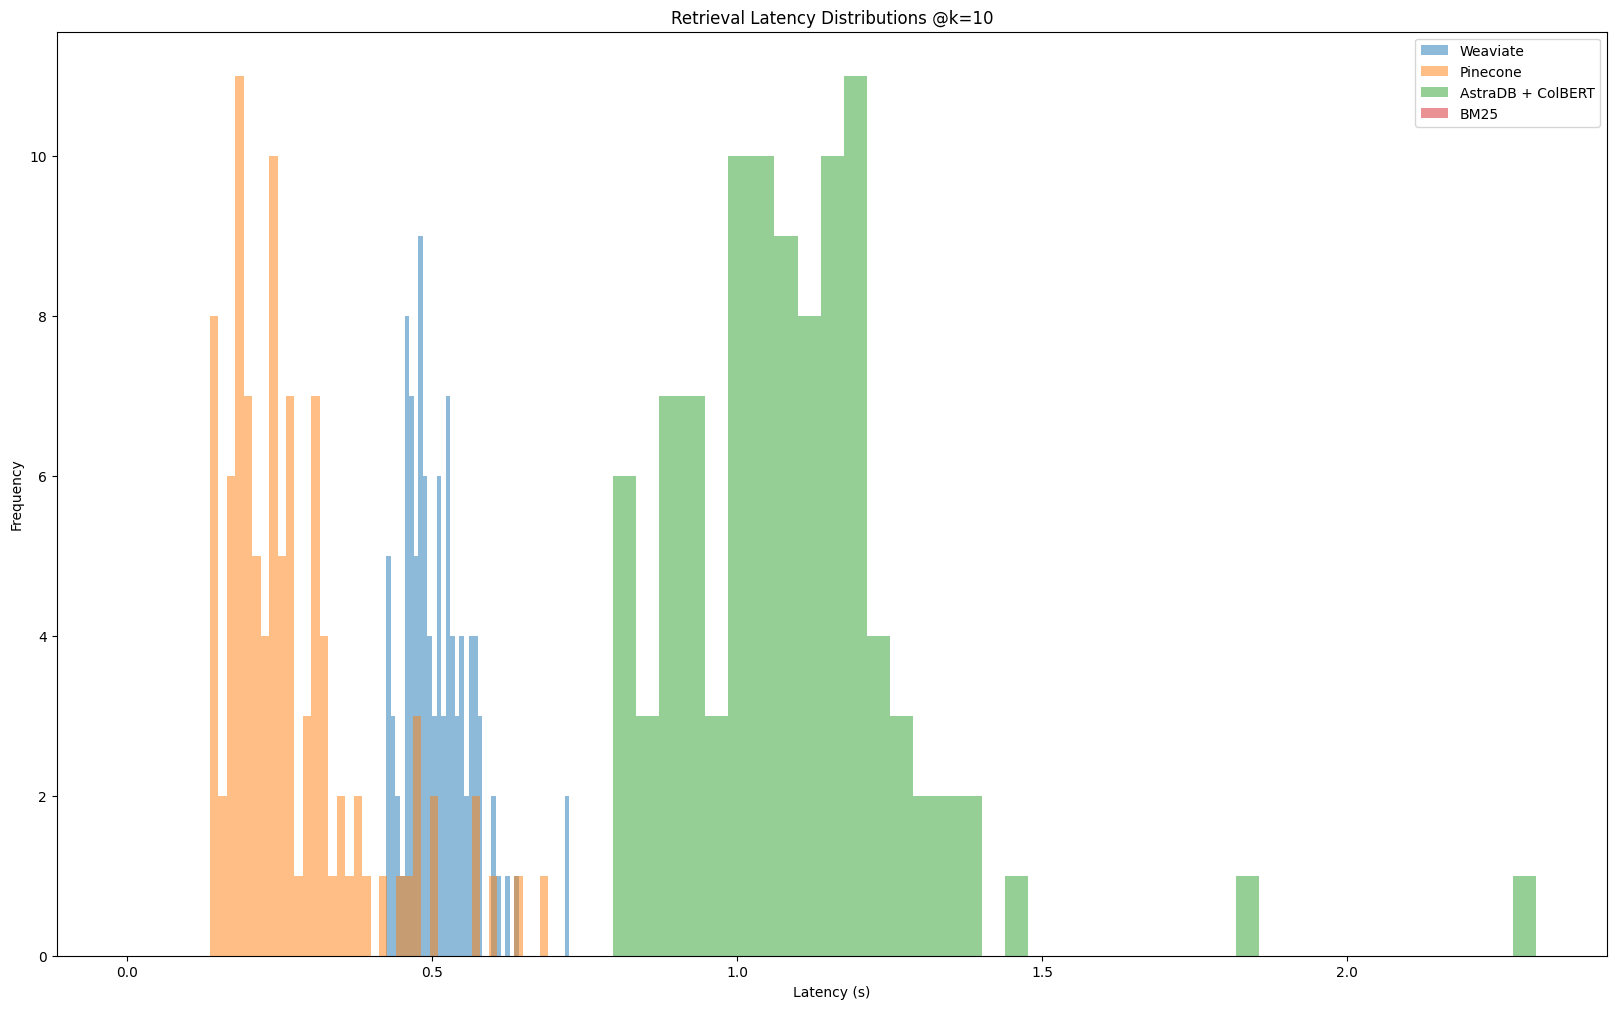

In [207]:
# Plot latency distributions
import matplotlib.pyplot as plt

bins = 40
plt.hist(weaviate_latencies, bins=bins, alpha=0.5, label='Weaviate')
plt.hist(pinecone_latencies, bins=bins, alpha=0.5, label='Pinecone')
plt.hist(colbert_latencies, bins=bins, alpha=0.5, label='AstraDB + ColBERT')
plt.hist(bm25_latencies, bins=bins, alpha=0.5, label='BM25')

plt.legend(loc='upper right')
plt.xlabel('Latency (s)')
plt.ylabel('Frequency')
plt.title('Retrieval Latency Distributions @k={}'.format(n_results))

# set the size bigger
plt.rcParams["figure.figsize"] = (20, 12)